In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import collections
import itertools
import tables
#from adjustText import adjust_text

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
import fbpca
# import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)

<module 'CEMBA_clst_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py'>

# focus on getting a list of pairs for correlated vs linked, as well as recreate other plots for corr vs linked

# get new set of genes/enhs with a stricter threshold on which genes are included

### Enhancer-gene project pilot notebook


- mCG (not normalized, cluster level)
- RNA logTPM (normalized, cluster level) 
- mCH normalized by global mean (normalized, cluster level)
- ATAC logTPM (normalized, cluster level)


### Basic settings 

- gene annotation
- cluster annotation
- enhancers annotation
- gene features
- enhancer features

# Annotate in gene-body pairs

In [25]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

output_figures = 'figures/corr_and_linked{}_{{}}'.format(today)
output_results = 'results_new/corr_and_linked{}_{{}}'.format(today)


In [3]:
f = '/cndd/Public_Datasets/CEMBA/snmCSeq/References/Annotation/gencode.vM16.annotation_genes.tsv'
df_genes = pd.read_csv(f, sep='\t')
df_genes['chrom'] = df_genes['chr'].apply(lambda x: x[3:])
df_genes = df_genes[df_genes['chrom'].isin(snmcseq_utils.get_mouse_chromosomes())]
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes['length'] = df_genes['end'] - df_genes['start']
print(df_genes.shape)
df_genes.head()

(51772, 10)


gene_id      gene_name   chr    start      end strand  \
0  ENSMUSG00000102693.1  4933401J01Rik  chr1  3073253  3074322      +   
1  ENSMUSG00000064842.1        Gm26206  chr1  3102016  3102125      +   
2  ENSMUSG00000051951.5           Xkr4  chr1  3205901  3671498      -   
3  ENSMUSG00000102851.1        Gm18956  chr1  3252757  3253236      +   
4  ENSMUSG00000103377.1        Gm37180  chr1  3365731  3368549      -   

              gene_type chrom                 gid  length  
0                   TEC     1  ENSMUSG00000102693    1069  
1                 snRNA     1  ENSMUSG00000064842     109  
2        protein_coding     1  ENSMUSG00000051951  465597  
3  processed_pseudogene     1  ENSMUSG00000102851     479  
4                   TEC     1  ENSMUSG00000103377    2818

In [4]:
df_genes_v2 = df_genes.groupby('gene_name').first()
df_genes_v2['chrom'] = df_genes_v2['chr'].apply(lambda x: (x[3:]))
gid_to_name = df_genes.set_index('gid')['gene_name']
df_genes_v2.head()

gene_id    chr      start        end strand  \
gene_name                                                                 
0610005C13Rik  ENSMUSG00000109644.1   chr7   45567794   45575327      -   
0610006L08Rik  ENSMUSG00000108652.1   chr7   74818818   74853813      -   
0610009B22Rik  ENSMUSG00000007777.9  chr11   51685386   51688874      -   
0610009E02Rik  ENSMUSG00000086714.1   chr2   26445696   26459390      +   
0610009L18Rik  ENSMUSG00000043644.4  chr11  120348678  120351190      +   

                                   gene_type chrom                 gid  length  
gene_name                                                                       
0610005C13Rik                  antisense_RNA     7  ENSMUSG00000109644    7533  
0610006L08Rik                        lincRNA     7  ENSMUSG00000108652   34995  
0610009B22Rik                 protein_coding    11  ENSMUSG00000007777    3488  
0610009E02Rik           processed_transcript     2  ENSMUSG00000086714   13694  
0610009L18Rik  bidirectional_promoter_lncRNA    11  ENSMUSG00000043644    2512

In [5]:
gid_to_name.head()

gid
ENSMUSG00000102693    4933401J01Rik
ENSMUSG00000064842          Gm26206
ENSMUSG00000051951             Xkr4
ENSMUSG00000102851          Gm18956
ENSMUSG00000103377          Gm37180
Name: gene_name, dtype: object

In [6]:
data_dir = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/'

In [7]:
# list of enhancers
f = os.path.join(data_dir, 'results/enhancers.bed')
df_enhs = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'clsts'])
df_enhs['length'] = df_enhs['end'] - df_enhs['start']
df_enhs['index'] = df_enhs.index.values
df_enhs['chrom'] = df_enhs['chr'].apply(lambda x: x[3:]) 
print(df_enhs.shape)
df_enhs.head()

(233524, 7)


chr    start      end  clsts  length  index chrom
0  chr1  3083769  3083816    NaN      47      0     1
1  chr1  3112234  3112467    NaN     233      1     1
2  chr1  3112770  3112986    NaN     216      2     1
3  chr1  3113717  3114035    NaN     318      3     1
4  chr1  3118790  3118935    NaN     145      4     1

In [8]:
# list of clusters
f = os.path.join(data_dir, 'ref/annotations_order.tsv')
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

### get features 

In [9]:
# global mC levels
import pickle as pkl

fs = [
    os.path.join(data_dir, 'results/cluster_global_mcg_round2.pkl'),
    os.path.join(data_dir, 'results/cluster_global_mcg_round3.pkl'),
]
global_mean_mcg = []
for f in fs:
    with open(f, 'rb') as fh:
        global_mean_mcg.append(pkl.load(fh))
global_mean_mcg = pd.concat(global_mean_mcg) 


fs = [
    os.path.join(data_dir, 'results/cluster_global_mch_round2.pkl'),
    os.path.join(data_dir, 'results/cluster_global_mch_round3.pkl'),
]
global_mean_mch = []
for f in fs:
    with open(f, 'rb') as fh:
        global_mean_mch.append(pkl.load(fh))
global_mean_mch = pd.concat(global_mean_mch)
    
print(global_mean_mcg.shape, global_mean_mch.shape)
global_mean_mcg.head()

(82,) (82,)


1-1     0.773445
1-2     0.774822
10-1    0.833052
2-1     0.787654
2-2     0.804645
dtype: float64

In [10]:
# gene rna
f = os.path.join(data_dir, 'results/gene_counts_10x_cells_v3_ethan38.tsv')
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0)
nclsts = gene_rna_clsts.shape[1]
print(gene_rna_clsts.shape)

# remove genes with coverage in less than half of clusters
cov_mat = (gene_rna_clsts > 50)
gene_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 1000 genes 
gene_rna_clsts = gene_rna_clsts.loc[gene_conds, clsts_conds]
print(gene_rna_clsts.shape)

# logtpm normalization
gene_lengths = df_genes.set_index('gid').reindex(gene_rna_clsts.index)['length'].dropna()
gene_lengths = gene_lengths.fillna(np.nanmean(gene_lengths))
gene_rna_clsts = snmcseq_utils.logcpm(gene_rna_clsts.loc[gene_lengths.index])

print(gene_rna_clsts.shape)
gene_rna_clsts.head()

(31053, 39)
(12209, 38)
(12154, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2  \
ENSMUSG00000051951  2.801480  2.894186  2.985782  3.001907  3.014618   
ENSMUSG00000089699  1.244222  1.284566  1.371247  1.429299  1.424190   
ENSMUSG00000033845  1.284728  1.266288  1.290867  1.314300  1.321816   
ENSMUSG00000104217  1.094065  1.006404  1.022574  1.090213  1.091222   
ENSMUSG00000033813  1.307825  1.265078  1.268211  1.297372  1.283206   

                       2-2-1     2-3-1     2-3-2     2-3-3     3-1-1  ...  \
ENSMUSG00000051951  3.023382  2.800215  2.931833  2.801815  2.844474  ...   
ENSMUSG00000089699  1.428170  1.272676  1.360412  1.268425  1.250595  ...   
ENSMUSG00000033845  1.275147  1.346788  1.327600  1.313422  1.301344  ...   
ENSMUSG00000104217  1.053478  1.060420  1.111219  1.071961  1.040543  ...   
ENSMUSG00000033813  1.270376  1.259129  1.317751  1.447241  1.243948  ...   

                       6-4-2       6-5     7-1-1     7-1-2     7-2-1  \
ENSMUSG00000051951  3.186321  2.899825  2.813543  2.788181  3.141053   
ENSMUSG00000089699  1.607115  1.304379  1.290516  1.264604  1.555252   
ENSMUSG00000033845  1.315826  1.368978  1.330725  1.386153  1.300538   
ENSMUSG00000104217  1.045038  1.004258  1.070479  1.162510  1.109549   
ENSMUSG00000033813  1.334368  1.291285  1.314016  1.441668  1.344910   

                       7-2-2     8-1-1     8-2-1     9-1-1     9-2-1  
ENSMUSG00000051951  3.162582  2.983622  3.007000  2.657125  2.326829  
ENSMUSG00000089699  1.590223  1.488852  1.433490  0.927883  0.562643  
ENSMUSG00000033845  1.344454  1.210740  1.285395  1.236515  1.507480  
ENSMUSG00000104217  1.127910  1.062761  1.131036  0.717851  1.183543  
ENSMUSG00000033813  1.388695  1.148226  1.280465  1.275612  1.320086  

[5 rows x 38 columns]

In [11]:
# gene mch
f = os.path.join(data_dir, 'results/gene_counts_mch_mch_ethan38.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=0)
f = os.path.join(data_dir, 'results/gene_counts_mch_ch_ethan38.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=0)
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage genes
# remove low coverage clusters
base_call_cutoff = 1e3
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 genes are covered in that cell type
gene_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the gene
gene_mch_c_clsts = c_table.loc[gene_cond, clst_cond]
gene_mch_mc_clsts = mc_table.loc[gene_cond, clst_cond]
print(gene_mch_c_clsts.shape)
print(gene_mch_mc_clsts.shape)

# get mcc
gene_mch_clsts = snmcseq_utils.get_mcc_lite_v2(gene_mch_c_clsts, gene_mch_mc_clsts, base_call_cutoff=base_call_cutoff)
gene_mch_clsts = gene_mch_clsts.divide(global_mean_mch.loc[gene_mch_clsts.columns.values], axis=1)

del gene_mch_c_clsts, gene_mch_mc_clsts
print(gene_mch_clsts.shape)
gene_mch_clsts.head()

(55487, 39) (55487, 39)
(39556, 38)
(39556, 38)
(39556, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2  \
ENSMUSG00000102693  1.044560  1.388850  1.814953  0.986151  1.137234   
ENSMUSG00000051951  0.585127  0.492982  0.405509  0.509483  0.519171   
ENSMUSG00000103377  0.626740  0.512025  0.425547  0.587109  0.574752   
ENSMUSG00000104017  0.579676  0.462759  0.387327  0.721597  0.792361   
ENSMUSG00000103025  0.642186  0.546094  0.462418  0.621182  0.532478   

                       2-2-1     2-3-1     2-3-2     2-3-3     3-1-1  ...  \
ENSMUSG00000102693  1.012576  1.489216  1.085170  1.015275  0.949874  ...   
ENSMUSG00000051951  0.479962  0.664061  0.627431  0.781421  0.512411  ...   
ENSMUSG00000103377  0.596842  0.727876  0.910802  0.896544  0.597430  ...   
ENSMUSG00000104017  0.671177  0.811555  0.614899  1.093287  0.622296  ...   
ENSMUSG00000103025  0.493473  0.720957  0.623816  0.906200  0.649551  ...   

                       6-4-2       6-5     7-1-1     7-1-2     7-2-1  \
ENSMUSG00000102693  1.104607  0.967632  1.201295  1.261993  1.113230   
ENSMUSG00000051951  0.586042  0.690053  0.667905  0.556561  0.483934   
ENSMUSG00000103377  0.356648  0.690416  1.573784  1.312456  1.371550   
ENSMUSG00000104017  0.800520  1.044661  0.616798  0.747225  0.624706   
ENSMUSG00000103025  0.865781  0.871531  0.760678  0.574916  0.697269   

                       7-2-2     8-1-1     8-2-1     9-1-1     9-2-1  
ENSMUSG00000102693  1.147272  1.132247  0.968678  0.981316  1.029372  
ENSMUSG00000051951  0.468551  0.328460  0.373701  0.910935  0.810503  
ENSMUSG00000103377  1.124712  0.397388  0.388527  0.711115  1.022159  
ENSMUSG00000104017  0.871620  0.515409  0.319068  0.868590  0.659482  
ENSMUSG00000103025  0.578430  0.290371  0.488555  0.966604  0.771126  

[5 rows x 38 columns]

In [12]:
# enhancer mcg
f = os.path.join(data_dir, 'results/enhancer_cluster_mcg.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
f = os.path.join(data_dir, 'results/enhancer_cluster_cg.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage enhs
# remove low coverage clusters
base_call_cutoff = 20
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 enhs are covered in that cell type
enh_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the enh
enh_mcg_c_clsts = c_table.loc[enh_cond, clst_cond]
enh_mcg_mc_clsts = mc_table.loc[enh_cond, clst_cond]
print(enh_mcg_c_clsts.shape, enh_mcg_mc_clsts.shape)

# get mcc
enh_mcg_clsts = snmcseq_utils.get_mcc_lite_v2(enh_mcg_c_clsts, enh_mcg_mc_clsts, base_call_cutoff=base_call_cutoff)
enh_mcg_clsts = enh_mcg_clsts.divide(global_mean_mcg.loc[enh_mcg_clsts.columns.values], axis=1)
print(enh_mcg_clsts.shape)

# index
enh_mcg_clsts.index = df_enhs.set_index(['chrom', 'start', 'end']).reindex(enh_mcg_clsts.index)['index']
print(enh_mcg_clsts.shape)

del enh_mcg_c_clsts, enh_mcg_mc_clsts

print(enh_mcg_clsts.shape)
enh_mcg_clsts.head()

(233514, 38) (233514, 38)
(155652, 38) (155652, 38)
(155652, 38)
(155652, 38)
(155652, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2     2-2-1     2-3-1  \
index                                                                         
1      1.240298  1.248431  1.241011  1.220681  1.233649  1.222340  1.227358   
3      0.732653  0.633566  0.699519  0.218281  0.211427  0.147583  0.313127   
4      0.117538  0.072983  0.046292  0.948267  0.853397  1.017745  1.093087   
5      0.021914  0.000000  0.000000  0.027021  0.072489  0.071764  0.158069   
6      0.472017  0.397952  0.432056  0.264584  0.156398  0.253389  0.361300   

          2-3-2     2-3-3     3-1-1  ...     6-4-2       6-5     7-1-1  \
index                                ...                                 
1      1.252849  1.130344  1.236917  ...  1.102198  1.160278  1.164447   
3      0.743879  0.689585  0.351170  ...  0.366996  0.998848  0.952729   
4      0.636395  0.645230  1.020415  ...  0.629163  1.210724  0.604933   
5      0.186484  0.189072  0.184250  ...  0.184364  0.180213  0.893183   
6      0.298297  0.380712  0.356650  ...  0.371232  0.362874  0.356935   

          7-1-2     7-2-1     7-2-2     8-1-1     8-2-1     9-1-1     9-2-1  
index                                                                        
1      1.169190  1.153231  1.196036  1.175057  1.143372  1.240520  1.135905  
3      0.937336  0.649250  0.966029  0.656137  0.643699  0.692691  0.589149  
4      1.053982  0.607489  0.607537  0.613934  0.602296  0.648136  0.648404  
5      0.572816  0.178013  0.178027  0.179902  0.176491  0.189924  0.190003  
6      0.536903  0.358444  0.358471  0.362246  0.355379  0.382427  0.382585  

[5 rows x 38 columns]

In [13]:
# enhancer atac
f = os.path.join(data_dir, 'results/enhancer_cluster_atac.tsv')
enh_atac_clsts = pd.read_csv(f, sep='\t', index_col=[0, 1, 2])
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

nclsts = enh_atac_clsts.shape[1]
print(enh_atac_clsts.shape)

# remove enhs with coverage in less than half of clusters
# remove clusters with low coverage
cov_mat = (enh_atac_clsts > 0)
enh_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 10000 enhs 
enh_atac_clsts = enh_atac_clsts.loc[enh_conds, clsts_conds]
print(enh_atac_clsts.shape)

# logtpm normalization
enh_lengths = df_enhs.copy()
enh_lengths['start'] = df_enhs['start'] - 1000
enh_lengths['end'] = df_enhs['end'] + 1000
enh_lengths['length'] = df_enhs['length'] + 2*1000 # 1kb flanking
enh_lengths = enh_lengths.set_index(['chr', 'start', 'end']).reindex(enh_atac_clsts.index) 

enh_atac_clsts = snmcseq_utils.logtpm(enh_atac_clsts, enh_lengths['length'])
enh_atac_clsts.index = enh_lengths['index']
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

(233524, 38)
(233524, 38)
(225713, 38)
(225713, 38)


1-1-1     1-2-1     1-2-2     2-1-1     2-1-2     2-2-1     2-3-1  \
index                                                                         
0      0.130886  0.119725  0.000000  0.096849  0.192041  0.084071  0.000000   
1      0.099659  0.047817  0.000000  0.227126  0.214111  0.077658  0.181955   
2      0.239656  0.246094  0.000000  0.454261  0.484983  0.590365  0.491015   
3      0.262038  0.278067  0.000000  0.458675  0.489559  0.617380  0.477878   
4      1.205729  1.191456  1.167327  1.167571  1.150293  1.174013  1.042267   

          2-3-2     2-3-3     3-1-1  ...     6-4-2       6-5     7-1-1  \
index                                ...                                 
0      0.000000  0.000000  0.110173  ...  0.564528  0.608619  0.000000   
1      0.809963  0.000000  0.101991  ...  0.629618  0.000000  0.433551   
2      1.079025  0.000000  0.470720  ...  0.879333  0.000000  0.435650   
3      0.796291  0.000000  0.470562  ...  0.862421  0.000000  0.000000   
4      0.000000  1.252377  1.045489  ...  0.643045  0.295275  0.996498   

          7-1-2     7-2-1     7-2-2     8-1-1  8-2-1     9-1-1  9-2-1  
index                                                                  
0      0.000000  0.000000  0.000000  0.000000    0.0  0.164258    0.0  
1      0.000000  0.000000  0.000000  0.000000    0.0  0.152714    0.0  
2      0.706488  0.411634  0.000000  0.746975    0.0  0.523153    0.0  
3      0.690856  0.399770  0.000000  0.730996    0.0  0.481399    0.0  
4      0.865335  0.808972  0.971425  1.182083    0.0  0.473350    0.0  

[5 rows x 38 columns]

In [14]:
gene_rna_clsts.head()

1-1-1     1-2-1     1-2-2     2-1-1     2-1-2  \
ENSMUSG00000051951  2.801480  2.894186  2.985782  3.001907  3.014618   
ENSMUSG00000089699  1.244222  1.284566  1.371247  1.429299  1.424190   
ENSMUSG00000033845  1.284728  1.266288  1.290867  1.314300  1.321816   
ENSMUSG00000104217  1.094065  1.006404  1.022574  1.090213  1.091222   
ENSMUSG00000033813  1.307825  1.265078  1.268211  1.297372  1.283206   

                       2-2-1     2-3-1     2-3-2     2-3-3     3-1-1  ...  \
ENSMUSG00000051951  3.023382  2.800215  2.931833  2.801815  2.844474  ...   
ENSMUSG00000089699  1.428170  1.272676  1.360412  1.268425  1.250595  ...   
ENSMUSG00000033845  1.275147  1.346788  1.327600  1.313422  1.301344  ...   
ENSMUSG00000104217  1.053478  1.060420  1.111219  1.071961  1.040543  ...   
ENSMUSG00000033813  1.270376  1.259129  1.317751  1.447241  1.243948  ...   

                       6-4-2       6-5     7-1-1     7-1-2     7-2-1  \
ENSMUSG00000051951  3.186321  2.899825  2.813543  2.788181  3.141053   
ENSMUSG00000089699  1.607115  1.304379  1.290516  1.264604  1.555252   
ENSMUSG00000033845  1.315826  1.368978  1.330725  1.386153  1.300538   
ENSMUSG00000104217  1.045038  1.004258  1.070479  1.162510  1.109549   
ENSMUSG00000033813  1.334368  1.291285  1.314016  1.441668  1.344910   

                       7-2-2     8-1-1     8-2-1     9-1-1     9-2-1  
ENSMUSG00000051951  3.162582  2.983622  3.007000  2.657125  2.326829  
ENSMUSG00000089699  1.590223  1.488852  1.433490  0.927883  0.562643  
ENSMUSG00000033845  1.344454  1.210740  1.285395  1.236515  1.507480  
ENSMUSG00000104217  1.127910  1.062761  1.131036  0.717851  1.183543  
ENSMUSG00000033813  1.388695  1.148226  1.280465  1.275612  1.320086  

[5 rows x 38 columns]

# subset to variable

In [15]:
gene_var = gene_rna_clsts.std(axis=1)
var_genes = gene_var  > np.percentile(gene_var, 70)

In [16]:
np.sum(var_genes)

3646

In [17]:
#gene_rna_clsts = gene_rna_clsts[var_genes]

In [18]:
gene_rna_clsts.shape

(12154, 38)

### Shared enhancers, shared genes, shared clusters, and nan check

In [19]:
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

shared_genes = np.intersect1d(gene_rna_clsts.index.values, gene_mch_clsts.index.values)
shared_enhs = np.intersect1d(enh_mcg_clsts.index.values, enh_atac_clsts.index.values) 
shared_clusters = np.array(list(set(gene_rna_clsts.columns.tolist())
                              & set(gene_mch_clsts.columns.tolist())
                              & set(enh_mcg_clsts.columns.tolist())
                              & set(enh_atac_clsts.columns.tolist())
                        ))
print(shared_genes.shape, shared_enhs.shape, shared_clusters.shape)
print(shared_genes[:2])
print(shared_enhs[:2])
print(shared_clusters[:2])


(12154, 38)
(39556, 38)
(155652, 38)
(225713, 38)
(12095,) (152104,) (38,)
['ENSMUSG00000000001' 'ENSMUSG00000000056']
[1 3]
['9-2-1' '7-1-2']


In [20]:
gene_rna_clsts = gene_rna_clsts.loc[shared_genes, shared_clusters]
gene_mch_clsts = gene_mch_clsts.loc[shared_genes, shared_clusters]
enh_mcg_clsts = enh_mcg_clsts.loc[shared_enhs, shared_clusters]
enh_atac_clsts = enh_atac_clsts.loc[shared_enhs, shared_clusters]
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

(12095, 38)
(12095, 38)
(152104, 38)
(152104, 38)


In [21]:
print(gene_rna_clsts.isnull().sum().sum())
print(gene_mch_clsts.isnull().sum().sum())
print(enh_mcg_clsts.isnull().sum().sum())
print(enh_atac_clsts.isnull().sum().sum())

0
0
0
0


### Get nearest gene info for each region

In [22]:
f = os.path.join(data_dir, 'results/enhancer_nearest_genes.bed')
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str})
regions_info.head()

# regions_info = regions_info.iloc[:, [0,1,2,8,9,11]] 
regions_info = regions_info.iloc[:, [0,1,2,7,8,9,10,11]] 
regions_info.columns = ['chr', 'start', 'end', 'transcript_id', 'transcript_name', 'gene_id', 'gene_name', 'distance']
regions_info = pd.merge(regions_info, df_enhs, on=['chr', 'start', 'end']).sort_values('index')
# regions_info = regions_info.groupby('index').first().reset_index()

print(regions_info.shape)
regions_info.head()

(224577, 12)


chr    start      end         transcript_id    transcript_name  \
0  chr1  3083769  3083816  ENSMUST00000193812.1  4933401J01Rik-201   
1  chr1  3112234  3112467  ENSMUST00000082908.1        Gm26206-201   
2  chr1  3112770  3112986  ENSMUST00000082908.1        Gm26206-201   
3  chr1  3113717  3114035  ENSMUST00000082908.1        Gm26206-201   
4  chr1  3118790  3118935  ENSMUST00000082908.1        Gm26206-201   

                gene_id      gene_name  distance  clsts  length  index chrom  
0  ENSMUSG00000102693.1  4933401J01Rik     10516    NaN      47      0     1  
1  ENSMUSG00000064842.1        Gm26206     10218    NaN     233      1     1  
2  ENSMUSG00000064842.1        Gm26206     10754    NaN     216      2     1  
3  ENSMUSG00000064842.1        Gm26206     11701    NaN     318      3     1  
4  ENSMUSG00000064842.1        Gm26206     16774    NaN     145      4     1

## Correlation  

In [23]:
# select common clusters
# clusters_selected = np.array(list(clst_annot.keys())) 

# clusters_selected = np.intersect1d(gene_rna_clsts.columns.values, enh_mcg_clsts.columns.values)
# clusters_selected_labels = np.array([str(clst)+" "+clst_annot[clst] for clst in clusters_selected])
# clusters_selected_labels

#### Length of enhancers 

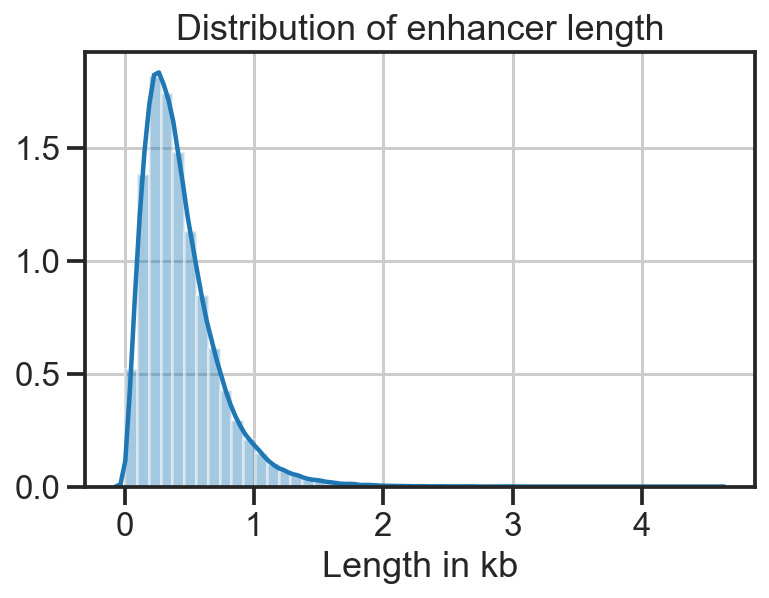

In [71]:
lens = df_enhs.loc[shared_enhs, 'length']
fig, ax = plt.subplots()
sns.distplot(lens.values/1000, ax=ax)
ax.set_xlabel('Length in kb')
ax.set_title('Distribution of enhancer length')
output_name = 'Enhancer length distribution' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

In [27]:
# full correlation

# gene 
_x_features = shared_genes 
_X = gene_rna_clsts.values
# # enhancer
_y_features = shared_enhs
_Y = enh_mcg_clsts.values 

# # enhancer
_y2_features = shared_enhs
_Y2 = enh_atac_clsts.values 
print(_X.shape, _Y.shape, _Y2.shape)

# row genes_list 
def get_tss(row):
    if row['strand'] == '+':
        return row['start']
    elif row['strand'] == '-':
        return row['end']
genes_list = df_genes.set_index('gid').reindex(shared_genes).reset_index().copy()
genes_list['chrom'] = genes_list['chr'].apply(lambda x: x[len('chr'):])
genes_list['tss'] = genes_list.apply(get_tss, axis=1)

# row ens_list
ens_list = df_enhs.set_index('index').loc[shared_enhs].reset_index()
ens_list['center'] = ens_list[['start', 'end']].mean(axis=1).astype(int)

print(ens_list.shape, genes_list.shape)
genes_list.head()

(12095, 38) (152104, 38) (152104, 38)
(152104, 8) (12095, 11)


gid                gene_id gene_name    chr      start  \
0  ENSMUSG00000000001   ENSMUSG00000000001.4     Gnai3   chr3  108107280   
1  ENSMUSG00000000056   ENSMUSG00000000056.7      Narf  chr11  121237253   
2  ENSMUSG00000000058   ENSMUSG00000000058.6      Cav2   chr6   17281185   
3  ENSMUSG00000000078   ENSMUSG00000000078.7      Klf6  chr13    5861482   
4  ENSMUSG00000000085  ENSMUSG00000000085.16     Scmh1   chr4  120405281   

         end strand       gene_type chrom  length        tss  
0  108146146      -  protein_coding     3   38866  108146146  
1  121255856      +  protein_coding    11   18603  121237253  
2   17289115      +  protein_coding     6    7930   17281185  
3    5870394      +  protein_coding    13    8912    5861482  
4  120530186      +  protein_coding     4  124905  120405281

In [28]:
np.sum(genes_list.length > 100000)

2149

In [29]:
_X_ranks = snmcseq_utils.rank_rows(_X)
_Y_ranks = snmcseq_utils.rank_rows(_Y)
_Y2_ranks = snmcseq_utils.rank_rows(_Y2)

In [30]:
# more than 15 mins for ~500,000 enhancers

# tss and enhancer center: 500KB ~ 2KB
# to_evals - ens, gene, val, dist

KB = 1000
window_size = 2000*KB # (+/- 1Mb)
inner_window_size = 4*KB #(+/- 2kb)
to_evals = [] 

ti = time.time()
# ens, gene
in_genes = []
for idx, gene in genes_list.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos, start, end = gene['chrom'], gene['tss'], gene['start'], gene['end']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]
    in_gene = [start, end]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    in_gene = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= in_gene[0]) 
             & (pos_enh <= in_gene[1])
              )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    in_gene = in_gene[cond]
    for ens in ens_include:
        to_evals.append((gene['gid'], ens))
    in_genes.append(in_gene.values)


0 0.012218475341796875
1000 34.6354193687439
2000 70.89903545379639
3000 106.99145102500916
4000 144.57790994644165
5000 190.46665048599243
6000 225.41867899894714
7000 262.6532688140869
8000 300.32003116607666
9000 336.24751806259155
10000 378.1122622489929
11000 412.3633997440338
12000 447.0182399749756


In [31]:
to_evals = np.array(to_evals)
to_evals = pd.DataFrame(np.array([to_evals[:, 0], to_evals[:, 1], np.concatenate(in_genes)]).T, columns=['gene', 'ens', 'in_gene'])

output_toevals = output_results.format('to_evals.tsv')
print(to_evals.shape)
to_evals.head()
to_evals.to_csv(output_toevals, sep="\t", header=True, index=False)

(1710144, 3)


In [32]:
f = output_results.format('to_evals.tsv')
to_evals = pd.read_csv(f, sep="\t")
print(to_evals.shape)
to_evals.head()

(1710144, 3)


gene     ens  in_gene
0  ENSMUSG00000000001  147520    False
1  ENSMUSG00000000001  147522    False
2  ENSMUSG00000000001  147523    False
3  ENSMUSG00000000001  147527    False
4  ENSMUSG00000000001  147528    False

In [33]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals['ens'].values)
_y2_idx = snmcseq_utils.get_index_from_array(_y2_features, to_evals['ens'].values)

to_evals['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals['val2'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y2_ranks[_y2_idx]) 

_X_ranks
to_evals['val_clustershuffled'] = snmcseq_utils.vcorrcoef(_X_ranks[:, np.random.permutation(_X_ranks.shape[1])][_x_idx], 
                                                          _Y_ranks[:, np.random.permutation(_Y_ranks.shape[1])][_y_idx]) 

to_evals['val2_clustershuffled'] = snmcseq_utils.vcorrcoef(_X_ranks[:, np.random.permutation(_X_ranks.shape[1])][_x_idx], 
                                                           _Y2_ranks[:, np.random.permutation(_Y2_ranks.shape[1])][_y2_idx]) 

to_evals['dist'] = np.abs(ens_list.set_index('index').loc[to_evals['ens'].values, 'center'].values 
                        - genes_list.set_index('gid').loc[to_evals['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals.head()

12.079256296157837


gene     ens  in_gene       val      val2  \
0  ENSMUSG00000000001  147520    False -0.416129  0.207791   
1  ENSMUSG00000000001  147522    False -0.048692 -0.142357   
2  ENSMUSG00000000001  147523    False -0.109531  0.267535   
3  ENSMUSG00000000001  147527    False -0.134916  0.096838   
4  ENSMUSG00000000001  147528    False -0.355291  0.098807   

   val_clustershuffled  val2_clustershuffled    dist  
0             0.071233             -0.002079  995118  
1             0.120473             -0.145858  985740  
2             0.027902             -0.259875  983725  
3             0.201007             -0.100120  970444  
4             0.248714             -0.124412  969372

In [72]:
to_evals.head()

gene     ens  in_gene       val      val2  \
0  ENSMUSG00000000001  147520    False -0.416129  0.207791   
1  ENSMUSG00000000001  147522    False -0.048692 -0.142357   
2  ENSMUSG00000000001  147523    False -0.109531  0.267535   
3  ENSMUSG00000000001  147527    False -0.134916  0.096838   
4  ENSMUSG00000000001  147528    False -0.355291  0.098807   

   val_clustershuffled  val2_clustershuffled    dist   pvalues  fdr<100kb  \
0             0.071233             -0.002079  995118  0.090151   0.428458   
1             0.120473             -0.145858  985740  0.414462   0.719874   
2             0.027902             -0.259875  983725  0.346690   0.676042   
3             0.201007             -0.100120  970444  0.319497   0.657509   
4             0.248714             -0.124412  969372  0.127221   0.482321   

   fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  \
0   0.520486   0.669566                           32.735334  0.230154   
1   0.777051   0.859596                            1.183878  0.716560   
2   0.740894   0.834201                            1.570314  0.166588   
3   0.725010   0.823293                            1.817085  0.375447   
4   0.570199   0.709733                           14.019220  0.372630   

   fdr2<100kb  fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  
0    0.605463    0.678469    0.795896                             2.014674  
1    0.871078    0.898293    0.937717                             0.868963  
2    0.549899    0.630306    0.760320                             2.956335  
3    0.704613    0.763367    0.854526                             1.237911  
4    0.702923    0.761896    0.853526                             1.245585

In [73]:
# shuffle

ti = time.time()
np.random.seed(0)

to_evals_shuffled = [] 
# shuffle gene_name label
genes_list_shuffle = genes_list.copy()
# genes_list_shuffle['gene_name'] = np.random.permutation(genes_list_shuffle['gene_name'].values)
genes_list_shuffle['gid'] = np.random.permutation(genes_list_shuffle['gid'].values)

# ens, gene
for idx, gene in genes_list_shuffle.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals_shuffled.append((gene['gid'], ens))
to_evals_shuffled = pd.DataFrame(to_evals_shuffled, columns=['gene', 'ens'])

print(len(to_evals_shuffled))

f = output_results.format('to_evals_shuffled.tsv')
print(to_evals_shuffled.shape)
to_evals_shuffled.to_csv(f, sep="\t", header=True, index=False)
to_evals_shuffled.head()

0 0.016822338104248047
1000 29.323713064193726
2000 57.64264369010925
3000 89.39752268791199
4000 118.77098679542542
5000 145.39296197891235
6000 170.89298105239868
7000 197.71862626075745
8000 226.2029459476471
9000 253.88964891433716
10000 281.4908559322357
11000 309.3537039756775
12000 337.41254782676697
1710144
(1710144, 2)


gene     ens
0  ENSMUSG00000033159  147520
1  ENSMUSG00000033159  147522
2  ENSMUSG00000033159  147523
3  ENSMUSG00000033159  147527
4  ENSMUSG00000033159  147528

In [74]:
to_evals_shuffled.head()

gene     ens
0  ENSMUSG00000033159  147520
1  ENSMUSG00000033159  147522
2  ENSMUSG00000033159  147523
3  ENSMUSG00000033159  147527
4  ENSMUSG00000033159  147528

In [75]:
f = output_results.format('to_evals_shuffled.tsv')
to_evals_shuffled = pd.read_csv(f, sep="\t")
print(to_evals_shuffled.shape)
to_evals_shuffled.head()

(1710144, 2)


gene     ens
0  ENSMUSG00000033159  147520
1  ENSMUSG00000033159  147522
2  ENSMUSG00000033159  147523
3  ENSMUSG00000033159  147527
4  ENSMUSG00000033159  147528

In [76]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals_shuffled['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals_shuffled['ens'].values)
to_evals_shuffled['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 

_y2_idx = snmcseq_utils.get_index_from_array(_y2_features, to_evals_shuffled['ens'].values)
to_evals_shuffled['val2'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y2_ranks[_y2_idx]) 

to_evals_shuffled['dist'] = np.abs(ens_list.set_index('index').loc[to_evals_shuffled['ens'].values, 'center'].values 
                        - genes_list_shuffle.set_index('gid').loc[to_evals_shuffled['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals_shuffled.head()

5.991684436798096


gene     ens       val      val2    dist
0  ENSMUSG00000033159  147520 -0.395339 -0.057665  995118
1  ENSMUSG00000033159  147522 -0.504760 -0.216763  985740
2  ENSMUSG00000033159  147523  0.002079  0.374986  983725
3  ENSMUSG00000033159  147527  0.074953 -0.109093  970444
4  ENSMUSG00000033159  147528  0.002079 -0.125287  969372

In [77]:
# mean within a distance bin
n = 100
_dist = np.linspace(0, window_size/(2*KB), n)


_tmp = to_evals.join(pd.qcut(to_evals['dist'], n, labels=False).to_frame('qcut')).groupby('qcut')['val']
_mval = _tmp.mean()
_stdval = _tmp.std()
_sizes = _tmp.size()

_tmp = to_evals.join(pd.qcut(to_evals['dist'], n, labels=False).to_frame('qcut')).groupby('qcut')['val2']
_mval2 = _tmp.mean()
_stdval2 = _tmp.std()
_sizes2 = _tmp.size()



print(_dist.shape, _mval.shape, _mval2.shape)

(100,) (100,) (100,)


In [78]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

### Statistical evaluation 
compute local FDR: 
- histogram -> density estimation (interpolate) -> cdf (cumsum), ratio of cdf
- quantile ranking (cdf) -> interpolate -> ratio of cdf

#### Setting up 

In [79]:
def bin_mean(x, y, bins):
    """Bin x according to bins, return bins, y_mean
    """
    # bin _x and mean_y
    _df = pd.DataFrame()
    _df['bin'] = np.digitize(_x, bins)
    _df['_y'] = _y
    _y_mean = _df.groupby('bin').mean()['_y']
    
    return bins[_y_mean.index], _y_mean.values

def fdr(x, x_bck, y_bck, x_fr, y_fr):
    """
    """
    return (np.interp(x, x_bck, y_bck))/(np.interp(x, x_fr, y_fr)+1e-6)

def pvalue(x, x_bck, y_bck):
    """
    """
    return np.interp(x, x_bck, y_bck)


In [80]:
regions = df_enhs # back compatibility

In [81]:
# randomly sample many genes and enhancers
ti = time.time()

p = 0.05
np.random.seed(0)
_x_selected_idx = np.arange(len(_x_features))
_x_selected_features = _x_features[_x_selected_idx]

_sampled = np.random.rand(len(_y_features))<p
_y_selected_idx = np.arange(len(_y_features))[_sampled]
_y_selected_features = _y_features[_y_selected_idx]

_y2_selected_idx = np.arange(len(_y2_features))[_sampled]
_y2_selected_features = _y2_features[_y2_selected_idx]

# same chrom or not
x_chroms = df_genes.set_index('gid').reindex(_x_selected_features)['chrom'].values
y_chroms = regions.set_index('index').reindex(_y_selected_features)['chrom'].values

corr = snmcseq_utils.spearman_corrcoef(_X[_x_selected_idx], 
                                       _Y[_y_selected_idx])[:len(_x_selected_idx), len(_x_selected_idx):]
corr2 = snmcseq_utils.spearman_corrcoef(_X[_x_selected_idx], 
                                       _Y2[_y2_selected_idx])[:len(_x_selected_idx), len(_x_selected_idx):]
corr_cis_mask = np.zeros_like(corr)
corr_cis_mask2 = np.zeros_like(corr2)
for i, x_chrom in enumerate(x_chroms):
    for j, y_chrom in enumerate(y_chroms):
        if x_chrom == y_chrom:
            corr_cis_mask[i,j] = 1
            corr_cis_mask2[i,j] = 1
            
corr_cis = corr[corr_cis_mask.nonzero()]
corr_cis2 = corr2[corr_cis_mask2.nonzero()]
print(time.time()-ti)

33.04115056991577


In [82]:
labels = [
        'All',
        'Same chrom',
        '<100kb shuffled (gene label)',
        '<100kb',
        '<200kb',
        '<500kb',
    
        '<100kb shuffled (cluster label)',
         ]

corr_tracks = [
       corr.flatten(),
       corr_cis,
       to_evals_shuffled.loc[to_evals_shuffled['dist']<=100*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=100*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=200*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=500*KB, 'val'].values,
    
       to_evals.loc[to_evals['dist']<=100*KB, 'val_clustershuffled'].values,
      ]

corr_tracks2 = [
       corr2.flatten(),
       corr_cis2,
       to_evals_shuffled.loc[to_evals_shuffled['dist']<=100*KB, 'val2'].values,
       to_evals.loc[to_evals['dist']<=100*KB, 'val2'].values,
       to_evals.loc[to_evals['dist']<=200*KB, 'val2'].values,
       to_evals.loc[to_evals['dist']<=500*KB, 'val2'].values,
    
       to_evals.loc[to_evals['dist']<=100*KB, 'val2_clustershuffled'].values,
    
       
      ]

subsample_rates = [
                  0.01,
                  0.1,
                  1,
                  1,
                  1,
                  1,
    
                  1,
                 ]


np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]
corr_tracks2 = [corr_tracks2[i][np.random.rand(len(corr_tracks2[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks2))]


In [83]:
corr_tracks[3].mean()

-0.11614149768288803

In [84]:
corr_tracks2[3].mean()

0.11181704656256576

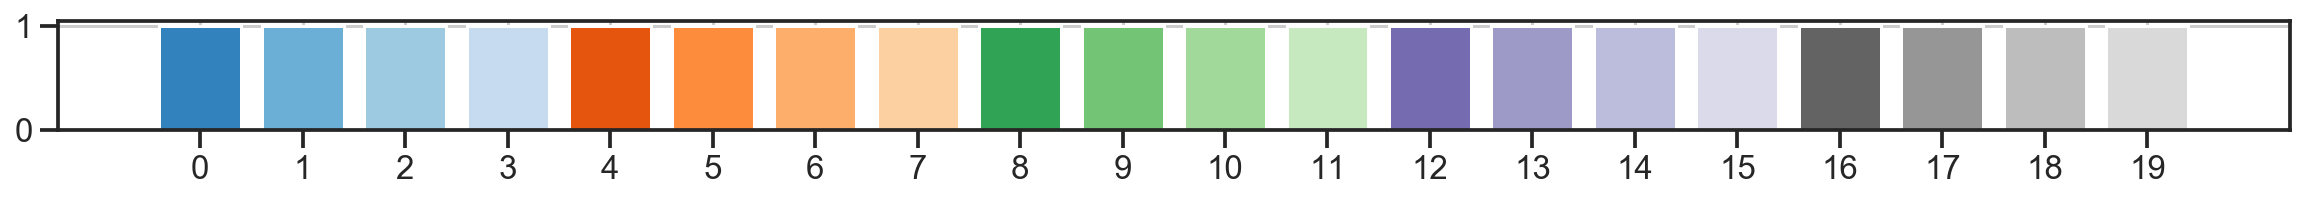

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


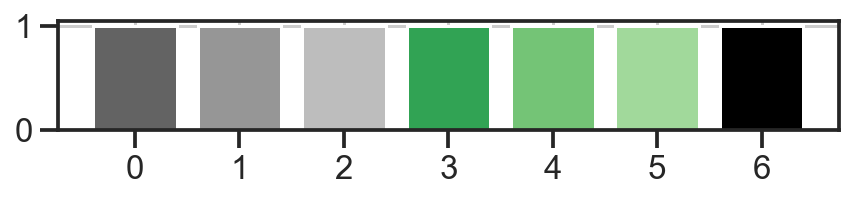

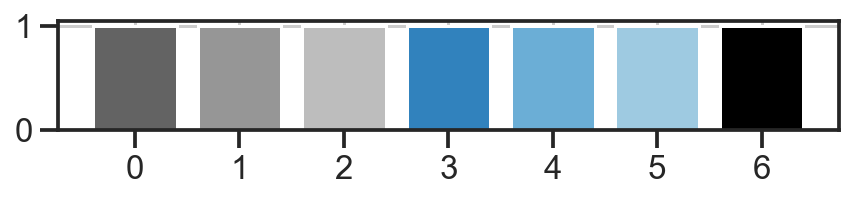

In [85]:
cm = plt.cm.tab20c.colors
# colors = [cm[16], cm[17], cm[18], cm[0], cm[1], cm[2], ]
# colors2 = [cm[16], cm[17], cm[18], cm[4], cm[5], cm[6], ]
colors = [cm[16], cm[17], cm[18], cm[8], cm[9], cm[10], 'black']
colors2 = [cm[16], cm[17], cm[18], cm[0], cm[1], cm[2], 'black']

n = len(cm)
fig, ax = plt.subplots(figsize=(1*n,1))
ax.bar(np.arange(n), 1, 
       color=list(cm))
ax.set_xticks(np.arange(n))
plt.show()

n = len(colors)
fig, ax = plt.subplots(figsize=(1*n,1))
ax.bar(np.arange(n), 1, 
       color=colors)
ax.set_xticks(np.arange(n))
plt.show()

n = len(colors2)
fig, ax = plt.subplots(figsize=(1*n,1))
ax.bar(np.arange(n), 1, 
       color=colors2)
ax.set_xticks(np.arange(n))
snmcseq_utils.savefig(fig, output_figures.format('palette', 'pdf'))
plt.show()

In [86]:
# FDR

bins = np.linspace(-1, 1, 200)
bins_eval = np.linspace(-1, 1, 2000)

# background
_x = np.sort(corr_tracks[0])
_y = np.arange(len(_x))/len(_x)
x_smooth_bck, y_smooth_bck = bin_mean(_x, _y, bins)
# pvalue
pvalues = pvalue(bins_eval, x_smooth_bck, y_smooth_bck)
to_evals['pvalues'] = pvalue(to_evals['val'].values, x_smooth_bck, y_smooth_bck)

# fore-ground - 2
# fdrs = []
for corr_track, track_name in zip(corr_tracks[3:], labels[3:]):
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr0, y_smooth_fr0 = bin_mean(_x, _y, bins)
    # ratio 2
#     fdrs.append(fdr(bins_eval, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0))
    to_evals['fdr{}'.format(track_name)] = fdr(to_evals['val'].values, 
                                               x_smooth_bck, y_smooth_bck, 
                                               x_smooth_fr0, y_smooth_fr0)

# FDR2
bins = np.linspace(-1, 1, 200)
bins_eval = np.linspace(-1, 1, 2000)

# background
_x = np.sort(corr_tracks2[0])
_y = 1 - np.arange(len(_x))/len(_x) # flipped cumulative function
x_smooth_bck2, y_smooth_bck2 = bin_mean(_x, _y, bins)
# pvalue
pvalues = pvalue(bins_eval, x_smooth_bck2, y_smooth_bck2)
to_evals['pvalues2'] = pvalue(to_evals['val2'].values, x_smooth_bck2, y_smooth_bck2)

# fore-ground - 2
# fdrs = []
for corr_track, track_name in zip(corr_tracks2[3:], labels[3:]):
    _x = np.sort(corr_track)
    _y = 1 - np.arange(len(_x))/len(_x) # flipped cumulative function
    x_smooth_fr0, y_smooth_fr0 = bin_mean(_x, _y, bins)
    # ratio 2
#     fdrs.append(fdr(bins_eval, x_smooth_bck2, y_smooth_bck2, x_smooth_fr0, y_smooth_fr0))
    to_evals['fdr2{}'.format(track_name)] = fdr(to_evals['val2'].values, 
                                                x_smooth_bck2, y_smooth_bck2, 
                                                x_smooth_fr0, y_smooth_fr0)

In [87]:
to_evals.head()

gene     ens  in_gene       val      val2  \
0  ENSMUSG00000000001  147520    False -0.416129  0.207791   
1  ENSMUSG00000000001  147522    False -0.048692 -0.142357   
2  ENSMUSG00000000001  147523    False -0.109531  0.267535   
3  ENSMUSG00000000001  147527    False -0.134916  0.096838   
4  ENSMUSG00000000001  147528    False -0.355291  0.098807   

   val_clustershuffled  val2_clustershuffled    dist   pvalues  fdr<100kb  \
0             0.071233             -0.002079  995118  0.090151   0.428458   
1             0.120473             -0.145858  985740  0.414462   0.719874   
2             0.027902             -0.259875  983725  0.346690   0.676042   
3             0.201007             -0.100120  970444  0.319497   0.657509   
4             0.248714             -0.124412  969372  0.127221   0.482321   

   fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  \
0   0.520486   0.669566                           32.735334  0.230154   
1   0.777051   0.859596                            1.183878  0.716560   
2   0.740894   0.834201                            1.570314  0.166588   
3   0.725010   0.823293                            1.817085  0.375447   
4   0.570199   0.709733                           14.019220  0.372630   

   fdr2<100kb  fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  
0    0.605463    0.678469    0.795896                             2.014674  
1    0.871078    0.898293    0.937717                             0.868963  
2    0.549899    0.630306    0.760320                             2.956335  
3    0.704613    0.763367    0.854526                             1.237911  
4    0.702923    0.761896    0.853526                             1.245585

In [88]:
track_name

'<100kb shuffled (cluster label)'

In [89]:
corr_track

array([-0.04015757, -0.04781705, -0.09924499, ..., -0.00689353,
       -0.00536164,  0.01236459])

In [90]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val'].values,
})

res_num_sig = []
_fdr_ = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck, y_smooth_bck, x_smooth_fr, y_smooth_fr)
    _fdr_.append(fdr_new)
    num_sig = np.sum(fdr_new < 0.20)
    res_num_sig.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig = pd.DataFrame(res_num_sig)
print(res_num_sig.shape)
res_num_sig.head()

(5, 2)


track_name  num_sig
0      2-100     8614
1    100-200      392
2    200-300       44
3    300-400        0
4    400-500        0

In [91]:
_x = np.sort(corr_tracks[-1])
_y = np.arange(len(_x))/len(_x)
x_smooth_bck, y_smooth_bck = bin_mean(_x, _y, bins)

In [92]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val'].values,
})

res_num_sig = []
_fdr_correlated = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck, y_smooth_bck, x_smooth_fr, y_smooth_fr)
    _fdr_correlated.append(fdr_new)
    num_sig = np.sum(fdr_new < 0.05)
    res_num_sig.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig = pd.DataFrame(res_num_sig)
print(res_num_sig.shape)
res_num_sig.head()

(5, 2)


track_name  num_sig
0      2-100    49697
1    100-200    33751
2    200-300    27874
3    300-400    25354
4    400-500    23181

In [93]:
eval_list = [to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB))], 
             to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB))],
    to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB))],
  to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB))],
 to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB))]]

In [94]:
evals_fdr = pd.concat(eval_list)

In [95]:
evals_fdr.head()

gene     ens  in_gene       val      val2  \
94  ENSMUSG00000000001  147662    False -0.039720  0.024182   
95  ENSMUSG00000000001  147663    False  0.024620  0.031185   
96  ENSMUSG00000000001  147664    False -0.022212  0.043221   
97  ENSMUSG00000000001  147665    False -0.147171  0.000328   
98  ENSMUSG00000000001  147666    False  0.122880  0.132728   

    val_clustershuffled  val2_clustershuffled   dist   pvalues  fdr<100kb  \
94             0.335157             -0.040158  92177  0.424753   0.726171   
95             0.131196             -0.047817  91955  0.499537   0.770189   
96            -0.078017             -0.099245  84155  0.445083   0.738381   
97            -0.405624             -0.225079  76112  0.306678   0.648344   
98            -0.053288             -0.305176  63221  0.611970   0.829045   

    fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  \
94   0.782423   0.863117                            1.144364  0.481687   
95   0.819225   0.887301                            0.943758  0.471232   
96   0.792797   0.870113                            1.076033  0.453424   
97   0.717420   0.818000                            1.960113  0.517087   
98   0.866636   0.917363                            0.809528  0.325132   

    fdr2<100kb  fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  
94    0.761744    0.811176    0.885708                             1.023473  
95    0.756665    0.806893    0.882941                             1.038550  
96    0.748075    0.799725    0.878353                             1.066899  
97    0.779035    0.824873    0.894071                             0.978650  
98    0.673350    0.736533    0.836520                             1.405627

In [96]:
_fdr_

[array([0.72617121, 0.77018857, 0.73838108, ..., 0.33144997, 0.47168008,
        0.49810131]),
 array([0.86100196, 0.77900418, 0.91192849, ..., 0.57262178, 0.68170323,
        0.4684204 ]),
 array([0.93635142, 0.7845844 , 0.92934428, ..., 0.91617715, 0.89795976,
        0.7936162 ]),
 array([0.85239574, 0.94850901, 0.94598422, ..., 0.7290691 , 0.85119196,
        0.72616707]),
 array([0.97402794, 0.99306303, 0.96593823, ..., 0.8437016 , 0.98752398,
        0.92131132])]

In [97]:
evals_fdr['fdr_mcg'] = np.concatenate(_fdr_)

In [98]:
evals_fdr['fdr_mcg_corr'] = np.concatenate(_fdr_correlated)

In [99]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val2'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val2'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val2'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val2'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val2'].values,
})

res_num_sig2 = []
_fdr_2 = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = 1 - np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck2, y_smooth_bck2, x_smooth_fr, y_smooth_fr)
    num_sig = np.sum(fdr_new < 0.2)
    _fdr_2.append(fdr_new)
    res_num_sig2.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig2 = pd.DataFrame(res_num_sig2)
print(res_num_sig2.shape)
res_num_sig2.head()

(5, 2)


track_name  num_sig
0      2-100     3838
1    100-200       35
2    200-300        1
3    300-400        0
4    400-500        0

In [100]:
corr_tracks2[-1].mean()

0.006251399086078967

In [101]:
corr_tracks[-1].mean()

0.007642799842407503

In [102]:
_x = np.sort(corr_tracks2[-1])
_y = 1 - np.arange(len(_x))/len(_x)
x_smooth_bck2, y_smooth_bck2 = bin_mean(_x, _y, bins)

In [103]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val2'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val2'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val2'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val2'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val2'].values,
})

res_num_sig2 = []
_fdr_2_correlated = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = 1 - np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck2, y_smooth_bck2, x_smooth_fr, y_smooth_fr)
    num_sig = np.sum(fdr_new < 0.05)
    _fdr_2_correlated.append(fdr_new)
    res_num_sig2.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })

    
res_num_sig2 = pd.DataFrame(res_num_sig2)
print(res_num_sig2.shape)
res_num_sig2.head()

(5, 2)


track_name  num_sig
0      2-100    28587
1    100-200    16154
2    200-300    11981
3    300-400    10273
4    400-500     8794

In [104]:
evals_fdr['fdr_atac'] = np.concatenate(_fdr_2)

In [105]:
evals_fdr['fdr_atac_corr'] = np.concatenate(_fdr_2_correlated)

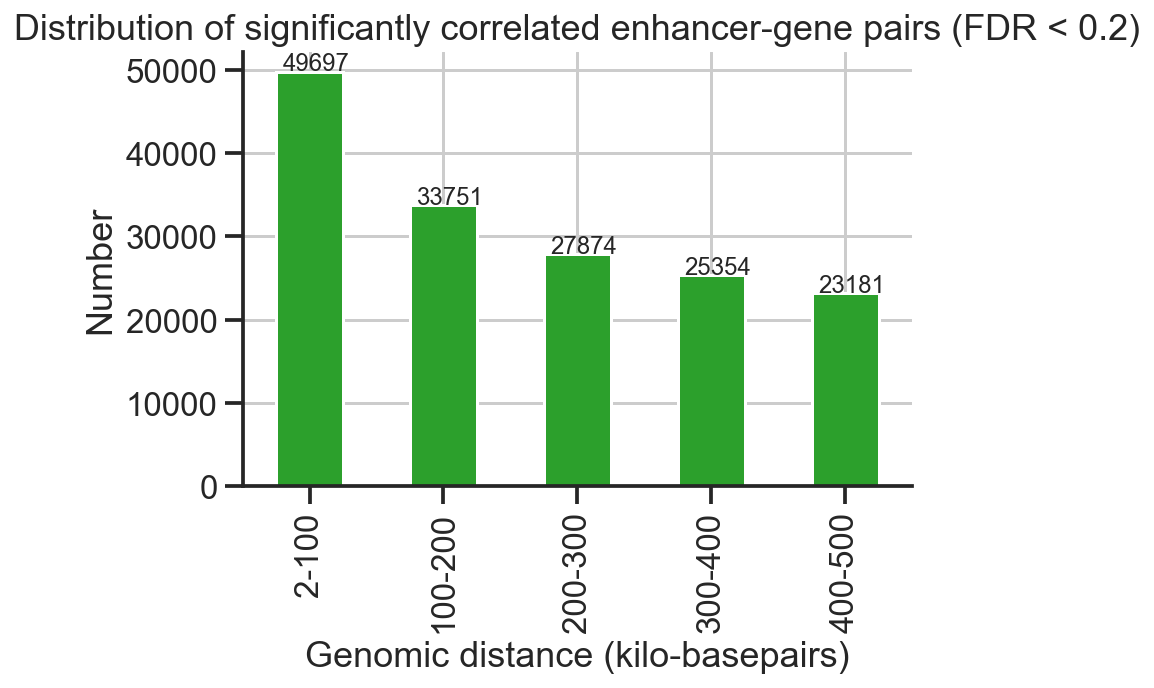

In [106]:
output_name = 'FDR_number'
fig, ax = plt.subplots()
res_num_sig.plot.bar(ax=ax, color=mod_palette['mc'], legend=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005), fontsize=12)
ax.set_ylabel('Number')
sns.despine(ax=ax)
ax.set_title('Distribution of significantly correlated enhancer-gene pairs (FDR < 0.2)')
ax.set_xticklabels(res_num_sig['track_name'].values)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

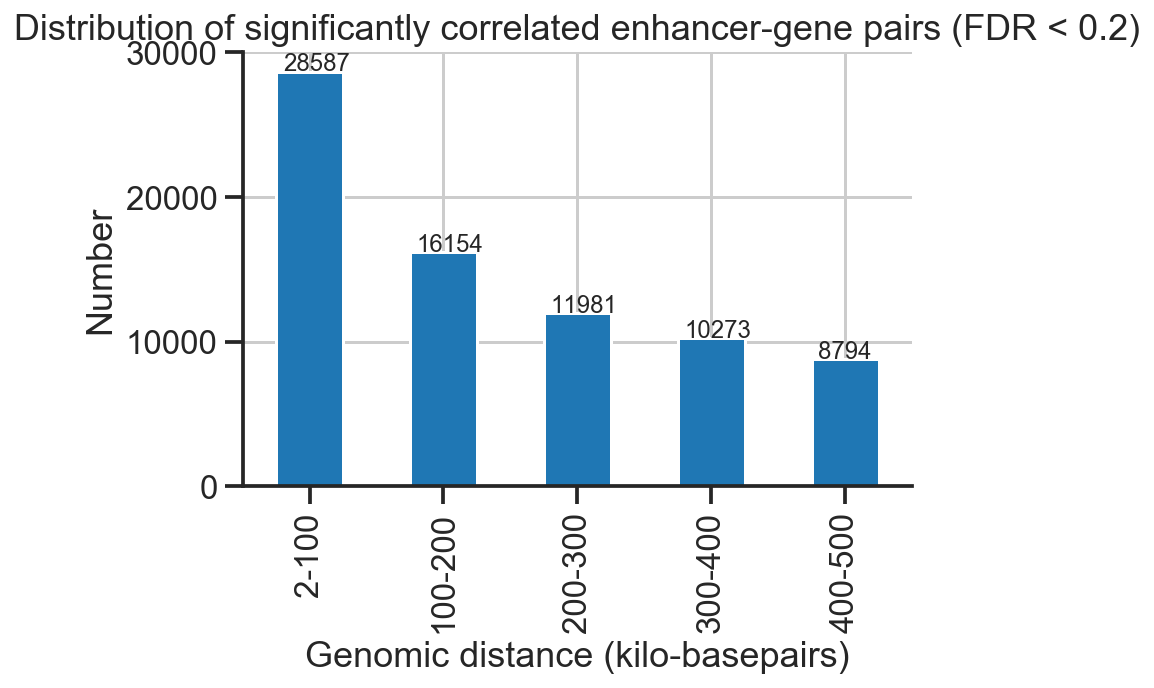

In [107]:
output_name = 'FDR_number2'
fig, ax = plt.subplots()
res_num_sig2.plot.bar(ax=ax, color=mod_palette['atac'], legend=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005), fontsize=12)
ax.set_ylabel('Number')
sns.despine(ax=ax)
ax.set_title('Distribution of significantly correlated enhancer-gene pairs (FDR < 0.2)')
ax.set_xticklabels(res_num_sig2['track_name'].values)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

#### Test individual pairs

In [109]:
evals_fdr.to_csv('results_new/evals_w_fdr_100kb_12k_genes.tsv', sep='\t')

In [110]:
gene_1 = (evals_fdr.loc[evals_fdr['fdr_mcg_corr'] < .05].gene.values)

In [111]:
gene_1.shape

(159857,)

In [113]:
gene_2 = (evals_fdr.loc[evals_fdr['fdr_atac_corr'] < .05].gene.values)

In [114]:
gene_2.shape

(75789,)

In [115]:
evals_fdr.head()

gene     ens  in_gene       val      val2  \
94  ENSMUSG00000000001  147662    False -0.039720  0.024182   
95  ENSMUSG00000000001  147663    False  0.024620  0.031185   
96  ENSMUSG00000000001  147664    False -0.022212  0.043221   
97  ENSMUSG00000000001  147665    False -0.147171  0.000328   
98  ENSMUSG00000000001  147666    False  0.122880  0.132728   

    val_clustershuffled  val2_clustershuffled   dist   pvalues  fdr<100kb  \
94             0.335157             -0.040158  92177  0.424753   0.726171   
95             0.131196             -0.047817  91955  0.499537   0.770189   
96            -0.078017             -0.099245  84155  0.445083   0.738381   
97            -0.405624             -0.225079  76112  0.306678   0.648344   
98            -0.053288             -0.305176  63221  0.611970   0.829045   

    ...  fdr<100kb shuffled (cluster label)  pvalues2  fdr2<100kb  fdr2<200kb  \
94  ...                            1.144364  0.481687    0.761744    0.811176   
95  ...                            0.943758  0.471232    0.756665    0.806893   
96  ...                            1.076033  0.453424    0.748075    0.799725   
97  ...                            1.960113  0.517087    0.779035    0.824873   
98  ...                            0.809528  0.325132    0.673350    0.736533   

    fdr2<500kb  fdr2<100kb shuffled (cluster label)   fdr_mcg  fdr_mcg_corr  \
94    0.885708                             1.023473  0.726171      0.634562   
95    0.882941                             1.038550  0.770189      0.816085   
96    0.878353                             1.066899  0.738381      0.686205   
97    0.894071                             0.978650  0.648344      0.330767   
98    0.836520                             1.405627  0.829045      1.024108   

    fdr_atac  fdr_atac_corr  
94  0.761744       0.744272  
95  0.756665       0.728577  
96  0.748075       0.701166  
97  0.779035       0.796029  
98  0.673350       0.479037  

[5 rows x 22 columns]

In [116]:
enh_1 = (evals_fdr.loc[evals_fdr['fdr_mcg_corr'] < .05].ens.values)
enh_2 = (evals_fdr.loc[evals_fdr['fdr_atac_corr'] < .05].ens.values)

In [117]:
np.unique(gene_2).shape

(8740,)

In [118]:
np.unique(gene_1).shape

(11002,)

In [119]:
np.unique(enh_2).shape

(47468,)

In [120]:
np.unique(enh_1).shape

(81118,)

In [121]:
pairs_1 = gene_1 + ':' + enh_1.astype(str)

In [122]:
pairs_2 = gene_2 + ':' +enh_2.astype(str)

In [123]:
np.unique(pairs_1).shape, np.unique(pairs_2).shape

((159857,), (75789,))

In [132]:
from matplotlib_venn import venn2

In [134]:
mod_palette['mc']

'C2'

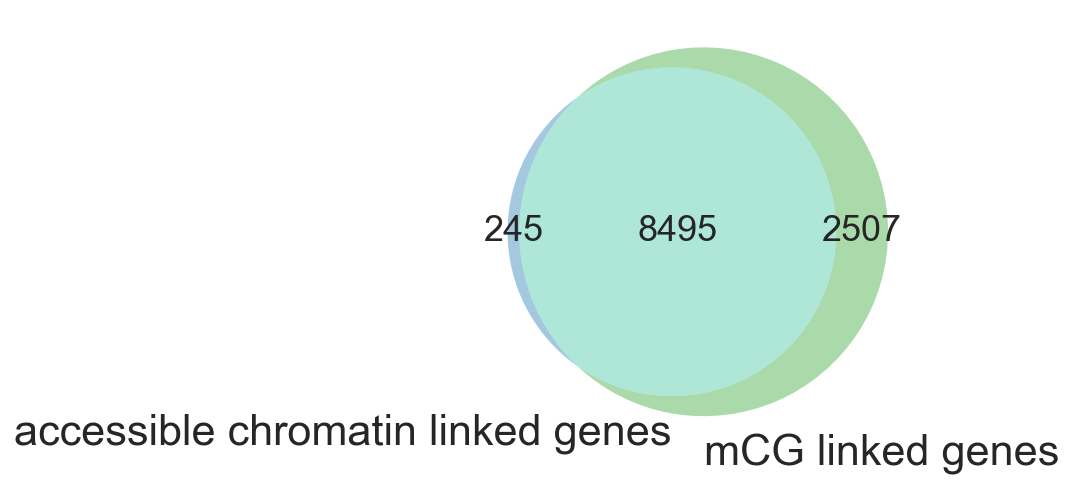

In [135]:
fig, ax = plt.subplots()
venn2([set(np.unique(gene_2)),
           set(np.unique(gene_1))],
      set_labels=['accessible chromatin linked genes', 'mCG linked genes'],
      set_colors=[ mod_palette['atac'], mod_palette['mc']], ax=ax
     )
fig.savefig(output_figures.format('ven_genes', 'pdf'), bbox_inches='tight')

In [136]:
811 + 1866 + 1664

4341

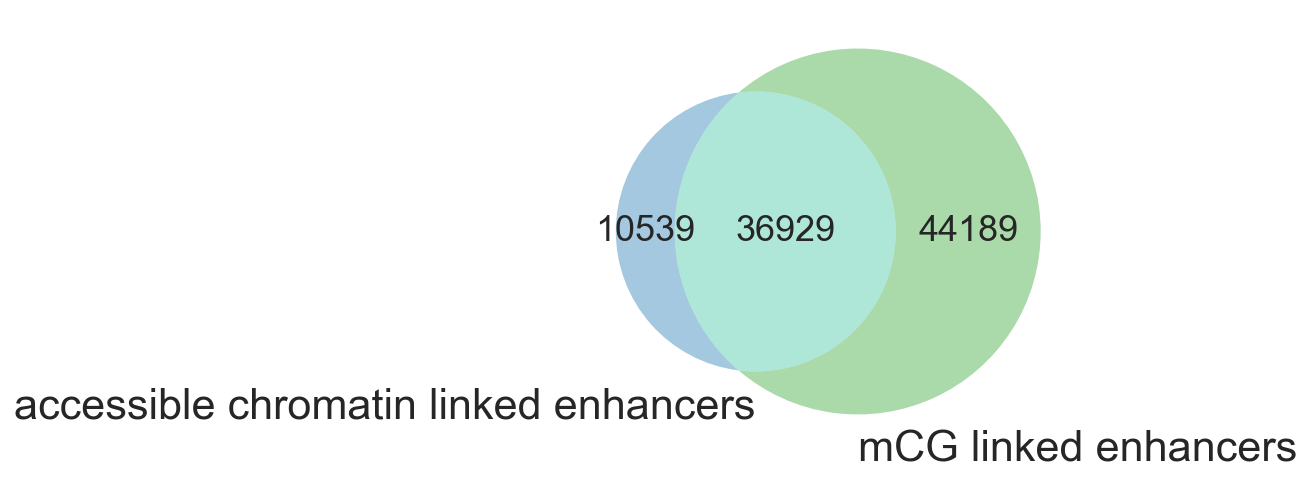

In [137]:
fig, ax = plt.subplots()
venn2([set(np.unique(enh_2)),
           set(np.unique(enh_1))],
      set_labels=['accessible chromatin linked enhancers', 'mCG linked enhancers'],
      set_colors=[ mod_palette['atac'], mod_palette['mc']]
     )
fig.savefig(output_figures.format('ven_ens', 'pdf'), bbox_inches='tight')

In [138]:
pairs_2.shape

(75789,)

In [139]:
np.unique(pairs_1).shape

(159857,)

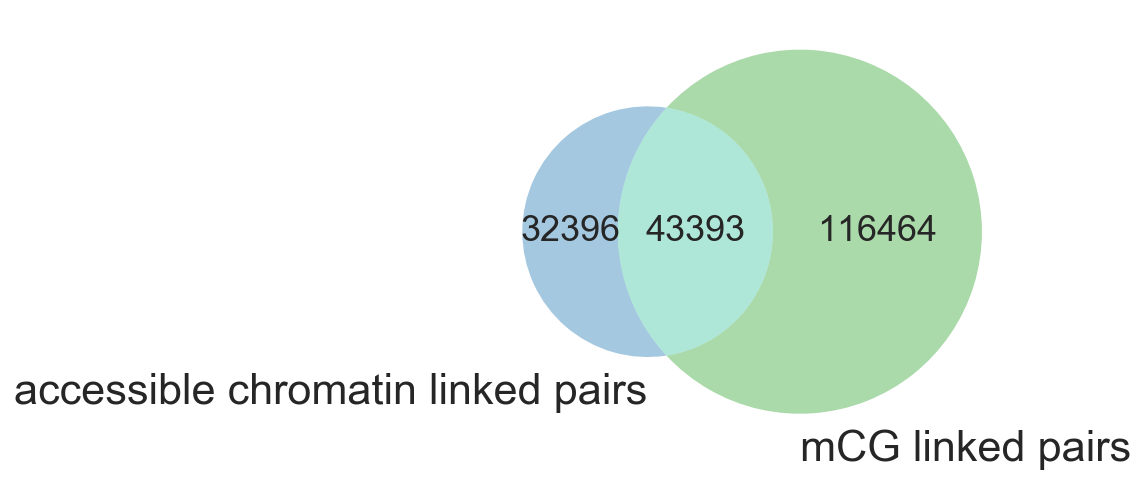

In [140]:
fig, ax = plt.subplots()
venn2([set(pairs_2),
           set(pairs_1)],
      set_labels=['accessible chromatin linked pairs', 'mCG linked pairs'],
      set_colors=[ mod_palette['atac'], mod_palette['mc']]
     )
fig.savefig(output_figures.format('ven_pairs', 'pdf'), bbox_inches='tight')

In [143]:
131193/(157321+131193)

0.45471970164359443

In [144]:
4315+3660+10726

18701

In [145]:
1821/12160

0.14975328947368421

In [146]:
1821/6362

0.2862307450487268

In [147]:
1109/6250

0.17744

In [148]:
to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB) & (to_evals['fdr<100kb'] < .1))].gene.unique().shape[0]

1135

In [149]:
def estimate_frac_tps(pvalues, bin_n=100, frac_bin_null=0.05):
    """
    """
    y = np.sort(pvalues)
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = y_norm[-int(frac_bin_null*bin_n):].mean()
    frac_tp = 1 - null_level 
    
    return frac_tp, null_level, bin_counts, bin_edges, y_norm
    


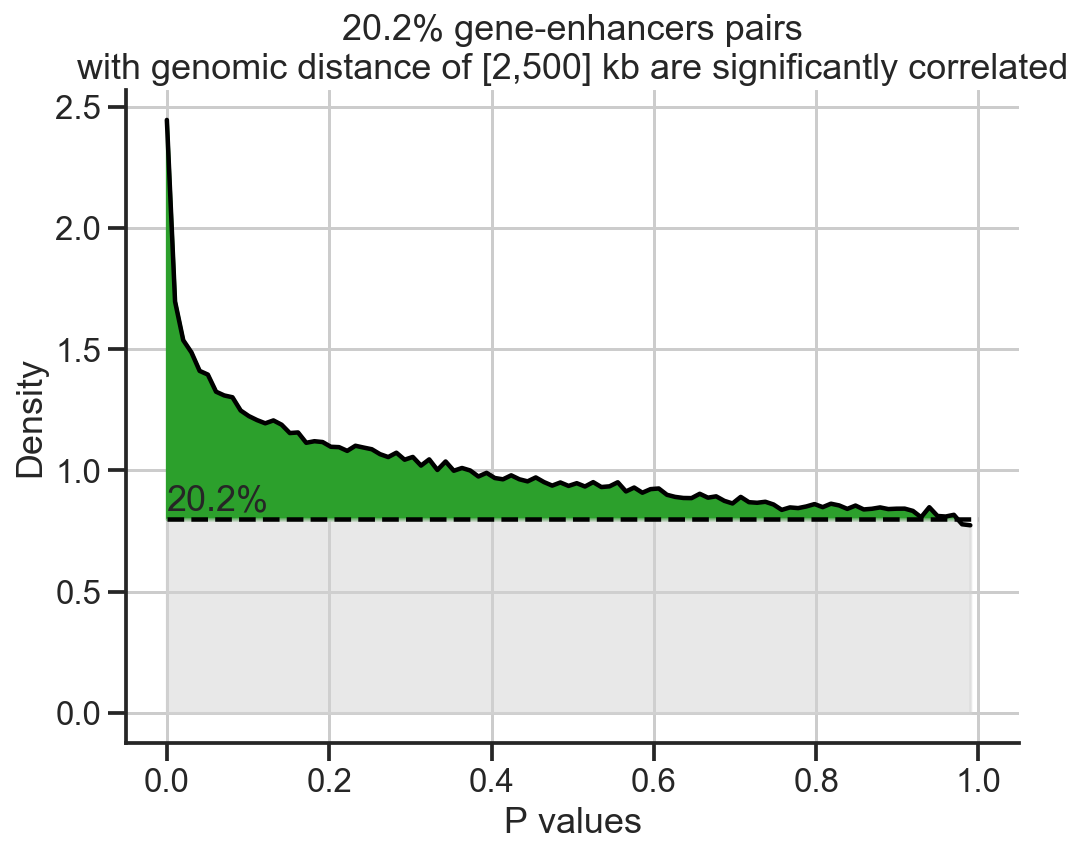

In [150]:
# plot pvalues
output_name = 'fraction-of-h1-one-example'

y = to_evals.loc[to_evals['dist']<500*KB, 'pvalues'].sort_values().values
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bin_edges[:-1], y_norm, color='k')
ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                where=y_norm>null_level, alpha=1, color=mod_palette['mc'])
ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='lightgray')
ax.text(0, null_level+0.2*(1-null_level), 
        "{:.1f}%".format(frac_tp*100), 
        fontsize=18)
sns.despine(ax=ax)

ax.set_xlabel('P values')
ax.set_ylabel('Density')
ax.set_title("{:.1f}% gene-enhancers pairs\nwith genomic distance of [2,500] kb are significantly correlated".format(frac_tp*100))
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

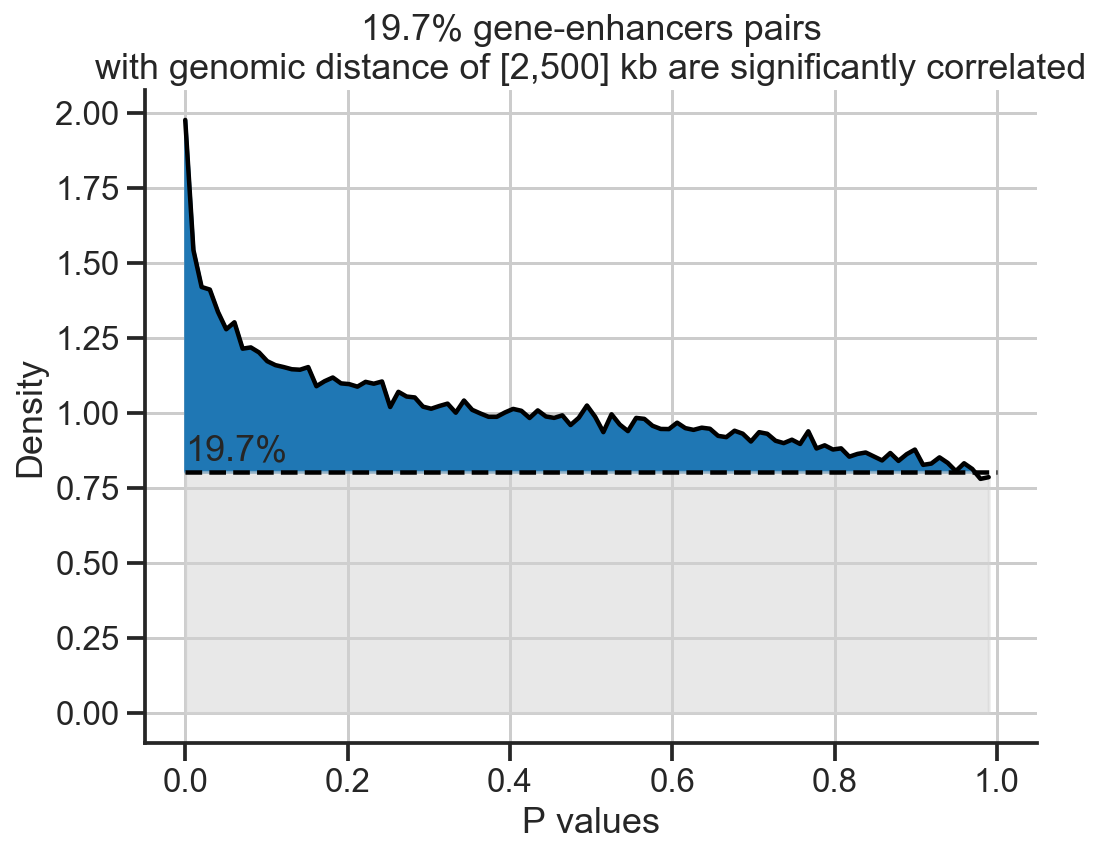

In [151]:
# plot pvalues
output_name = 'fraction-of-h1-one-example2'

y = to_evals.loc[to_evals['dist']<500*KB, 'pvalues2'].sort_values().values
frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bin_edges[:-1], y_norm, color='k')
ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                where=y_norm>null_level, alpha=1, color=mod_palette['atac'])
ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='lightgray')
ax.text(0, null_level+0.2*(1-null_level), 
        "{:.1f}%".format(frac_tp*100), 
        fontsize=18)
sns.despine(ax=ax)


ax.set_xlabel('P values')
ax.set_ylabel('Density')
ax.set_title("{:.1f}% gene-enhancers pairs\nwith genomic distance of [2,500] kb are significantly correlated".format(frac_tp*100))
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

In [152]:
frac_tps = []
num_tps = []
dists_kb = np.hstack([[10, 20, 50], np.arange(100, 1000+1, 100)]) 

for idx in np.arange(len(dists_kb)):
    dist_kb = dists_kb[idx]
    if idx == 0:
        cond = (to_evals['dist'] < dist_kb*KB)
    else:
        dist_kb_prev = dists_kb[idx-1]
        cond = ((to_evals['dist'] < dist_kb*KB) & 
                (to_evals['dist'] >= dist_kb_prev*KB))
    
    y = to_evals.loc[cond, 'pvalues'].values
    frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)
    frac_tps.append(frac_tp)
    num_tps.append(len(y)*frac_tp)
    
    
frac_tps2 = []
num_tps2 = []
dists_kb = np.hstack([[10, 20, 50], np.arange(100, 1000+1, 100)]) 

for idx in np.arange(len(dists_kb)):
    dist_kb = dists_kb[idx]
    if idx == 0:
        cond = (to_evals['dist'] < dist_kb*KB)
    else:
        dist_kb_prev = dists_kb[idx-1]
        cond = ((to_evals['dist'] < dist_kb*KB) & 
                (to_evals['dist'] >= dist_kb_prev*KB))
    
    y = to_evals.loc[cond, 'pvalues2'].values
    frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(y)
    frac_tps2.append(frac_tp)
    num_tps2.append(len(y)*frac_tp)

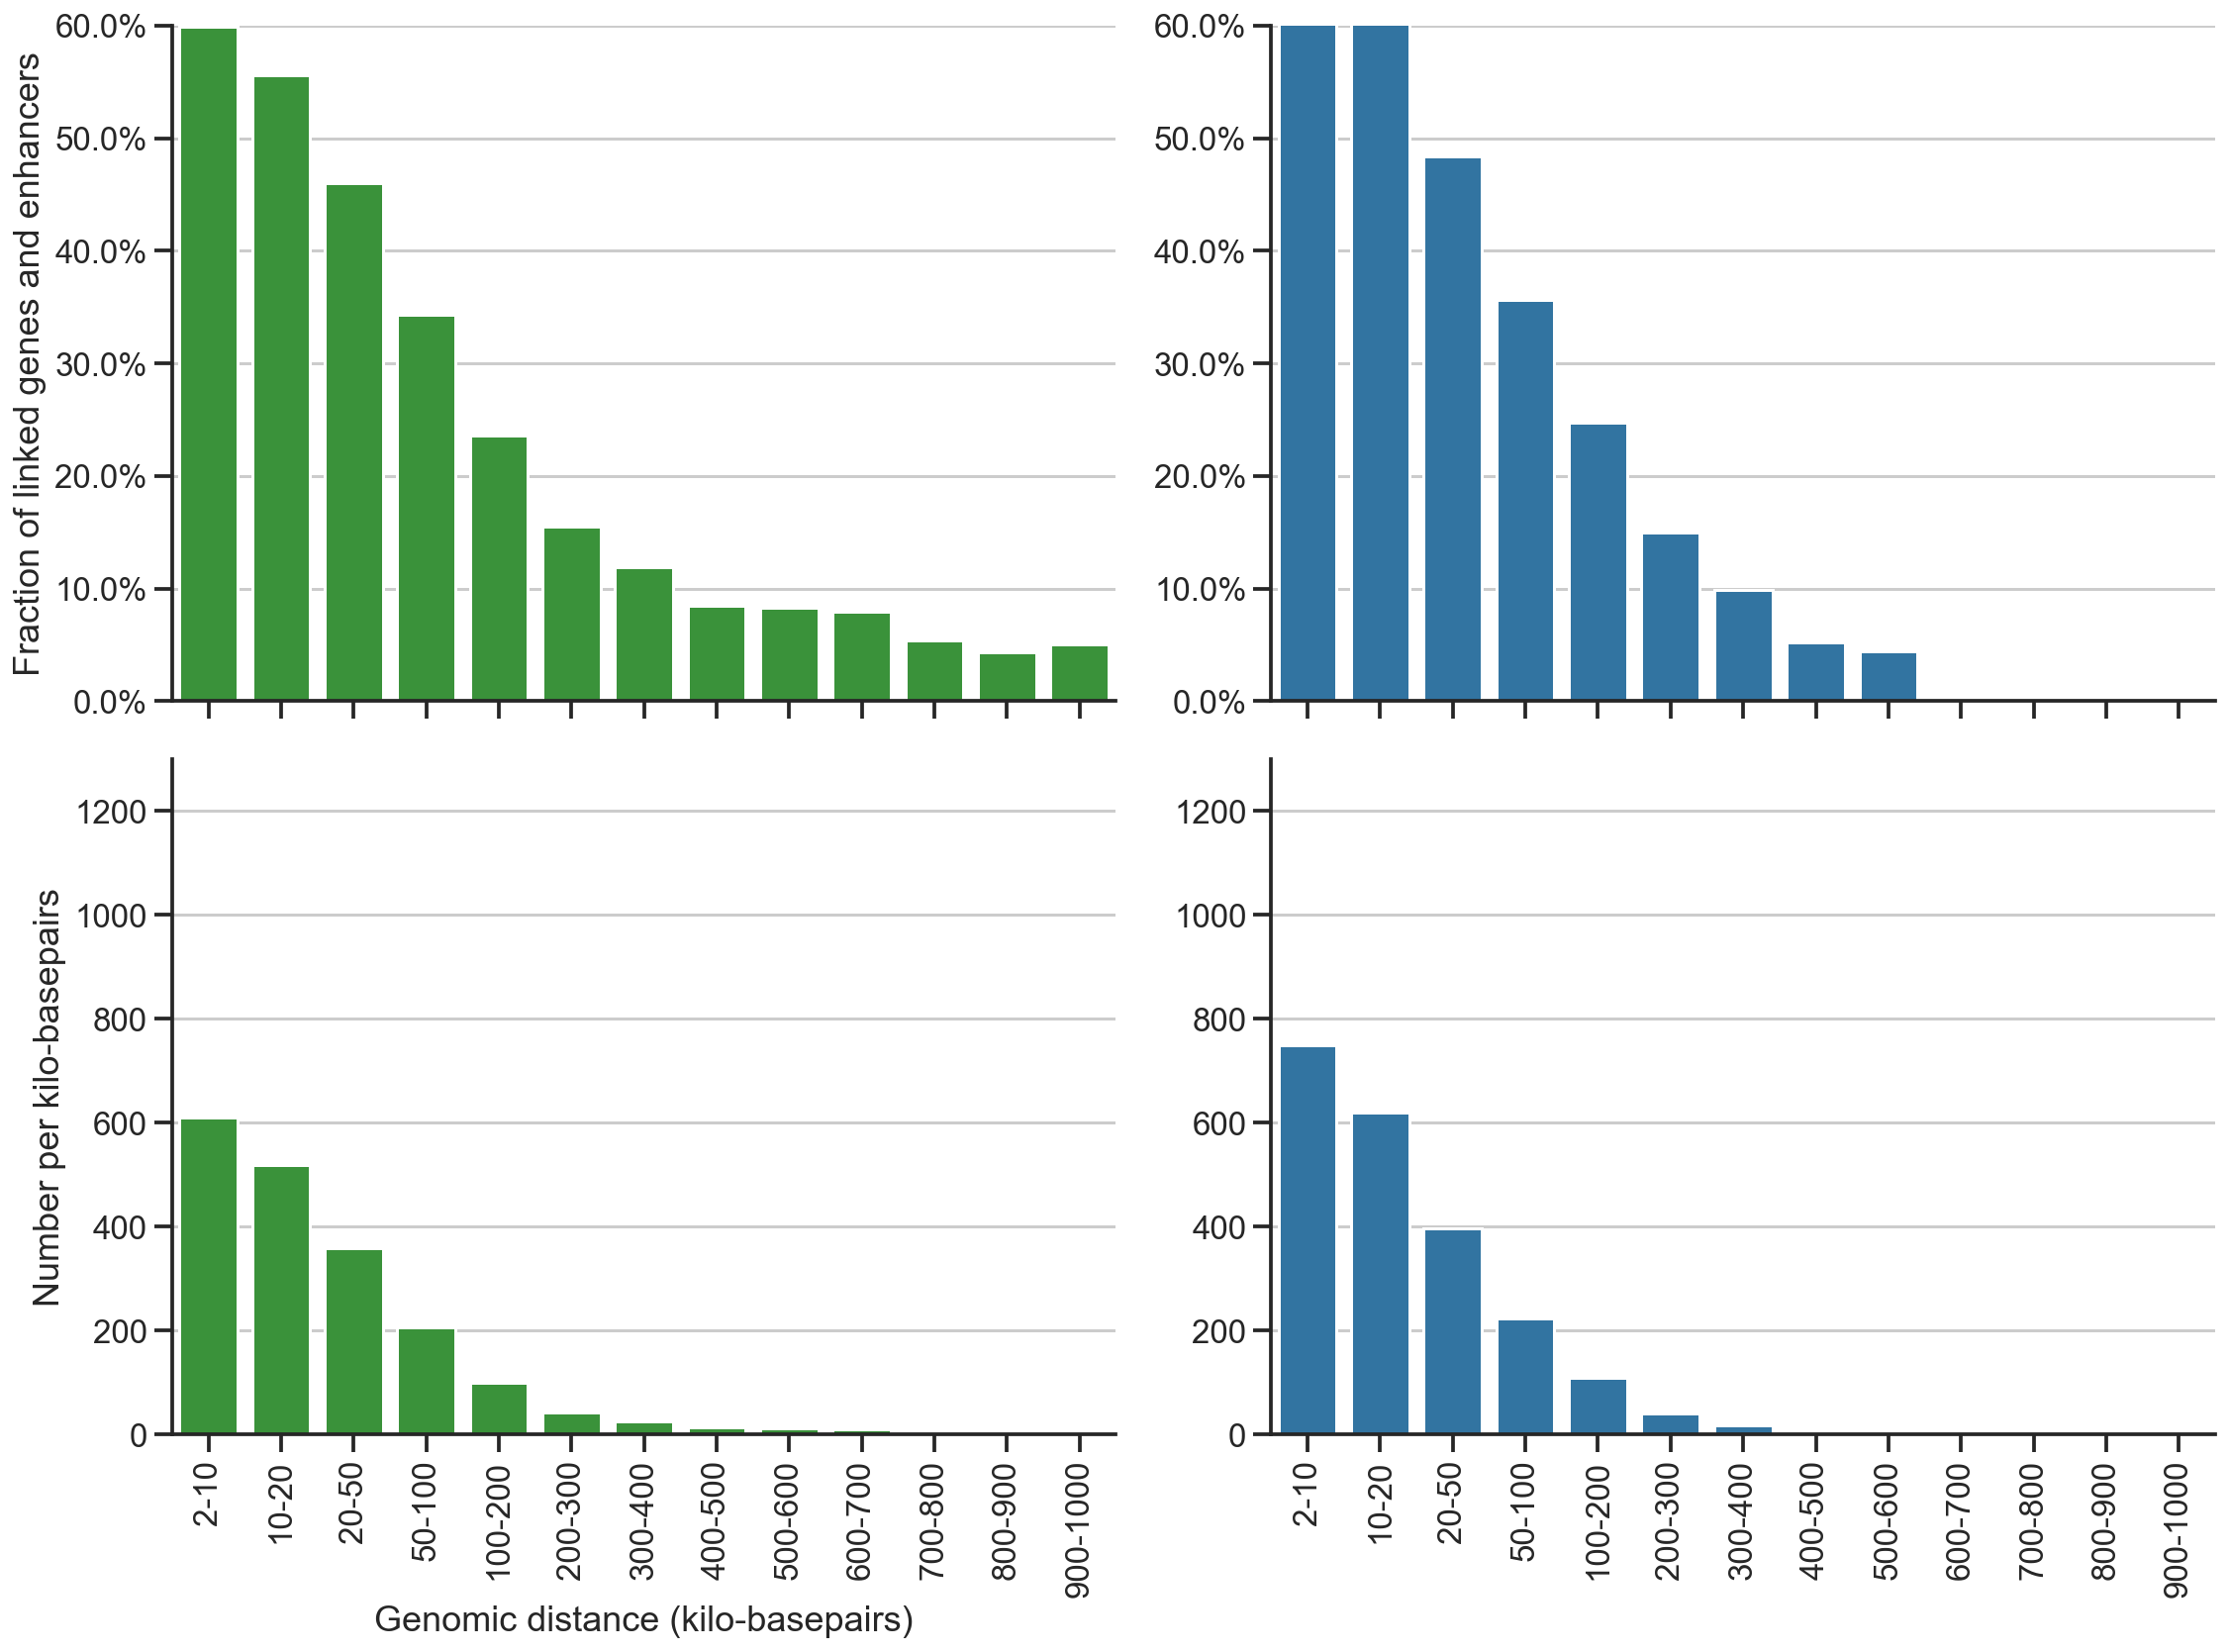

In [153]:
output_name = 'fraction-of-h1-summary'

dists_kb_plot = np.hstack([[2], dists_kb])

df_plot = pd.DataFrame(np.vstack([dists_kb, frac_tps]).T, columns=['x', 'y'])
df_plot['x_formatted'] = ["{}-{}".format(dists_kb_plot[i], dists_kb_plot[i+1]) for i in range(len(dists_kb))]
df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
df_plot['num'] = np.array(num_tps)*np.array(frac_tps)
df_plot['num_norm'] = df_plot['num']/df_plot['length']

df_plot2 = pd.DataFrame(np.vstack([dists_kb, frac_tps2]).T, columns=['x', 'y'])
df_plot2['x_formatted'] = ["{}-{}".format(dists_kb_plot[i], dists_kb_plot[i+1]) for i in range(len(dists_kb))]
df_plot2['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
df_plot2['num'] = np.array(num_tps2)*np.array(frac_tps2)
df_plot2['num_norm'] = df_plot2['num']/df_plot2['length']



fig, axs = plt.subplots(2, 2, figsize=(8*2,6*2), sharex=True)
ax = axs[0, 0]
color = mod_palette['mc']
sns.barplot(x='x_formatted', y='y', data=df_plot, color=color, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Fraction of linked genes and enhancers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(PercentFormat) 
sns.despine(ax=ax)
ax.set_ylim([0, 0.6])

ax = axs[0, 1]
color = mod_palette['atac']
sns.barplot(x='x_formatted', y='y', data=df_plot2, color=color, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(PercentFormat) 
sns.despine(ax=ax)
ax.set_ylim([0, 0.6])

ax = axs[1, 0]
color = mod_palette['mc']
sns.barplot(x='x_formatted', y='num_norm', data=df_plot, color=color, ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Number per kilo-basepairs')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax)
ax.set_ylim([0, 1300])

ax = axs[1, 1]
color = mod_palette['atac']
sns.barplot(x='x_formatted', y='num_norm', data=df_plot2, color=color, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax)
ax.set_ylim([0, 1300])

fig.tight_layout()
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()



In [154]:
# significant ones
sig_cond = (
    ((to_evals['fdr<100kb']<0.2) & (to_evals['dist']<100*KB)) |
    ((to_evals['fdr<200kb']<0.2) & (to_evals['dist']<200*KB)) |
    ((to_evals['fdr<500kb']<0.2) & (to_evals['dist']<500*KB))
)

top_sig = to_evals[sig_cond].sort_values(['val']) #.head(30)
top_sig['gene_name'] = gid_to_name.loc[top_sig['gene'].values].values

top_sig = pd.merge(top_sig, ens_list, left_on='ens', right_on='index')
top_sig_genes = top_sig.groupby('gene').size().sort_values(ascending=False).index.values
top_sig_ens = top_sig.groupby('ens').size().sort_values(ascending=False).index.values

n_pair, n_enh, n_gene = len(top_sig), len(top_sig_ens), len(top_sig_genes)
print('{} significantly correlated enhancer-gene pairs\n{}/{} enhancers {}/{} genes'
    .format(n_pair, n_enh, len(_y_features), n_gene, len(_x_features)) 
     )
top_sig.head()

11343 significantly correlated enhancer-gene pairs
9814/152104 enhancers 2781/12095 genes


gene     ens  in_gene       val      val2  \
0  ENSMUSG00000049556  221845     True -0.963891  0.656855   
1  ENSMUSG00000049556  221868     True -0.962140  0.710909   
2  ENSMUSG00000022332   83016     True -0.952730  0.168837   
3  ENSMUSG00000049556  221849     True -0.951198  0.431666   
4  ENSMUSG00000022332   83063     True -0.948134  0.636503   

   val_clustershuffled  val2_clustershuffled    dist       pvalues  fdr<100kb  \
0            -0.085458              0.323121  172329  0.000000e+00    0.00000   
1            -0.183280              0.130321  115681  0.000000e+00    0.00000   
2             0.135792             -0.122661  104705  0.000000e+00    0.00000   
3            -0.066637              0.010614  169279  0.000000e+00    0.00000   
4             0.077580              0.111719  159432  5.843406e-08    0.00455   

   ...  fdr2<100kb shuffled (cluster label)  gene_name   index    chr  \
0  ...                           429.207247     Lingo1  221845   chr9   
1  ...                           136.727057     Lingo1  221868   chr9   
2  ...                             1.647945    Khdrbs3   83016  chr15   
3  ...                            15.512834     Lingo1  221849   chr9   
4  ...                           365.485811    Khdrbs3   83063  chr15   

      start       end  clsts  length chrom    center  
0  56623683  56624596    NaN     913     9  56624139  
1  56680091  56681484    NaN    1393     9  56680787  
2  69032853  69033398    NaN     545    15  69033125  
3  56626636  56627742    NaN    1106     9  56627189  
4  69087116  69088589    NaN    1473    15  69087852  

[5 rows x 27 columns]

In [155]:
# sig2nificant ones
sig2_cond = (
    ((to_evals['fdr2<100kb']<0.2) & (to_evals['dist']<100*KB)) |
    ((to_evals['fdr2<200kb']<0.2) & (to_evals['dist']<200*KB)) |
    ((to_evals['fdr2<500kb']<0.2) & (to_evals['dist']<500*KB))
)

top_sig2 = to_evals[sig2_cond].sort_values(['val2'], ascending=False) #.head(30)
top_sig2['gene_name'] = gid_to_name.loc[top_sig2['gene'].values].values

top_sig2 = pd.merge(top_sig2, ens_list, left_on='ens', right_on='index')
top_sig2_genes = top_sig2.groupby('gene').size().sort_values(ascending=False).index.values
top_sig2_ens = top_sig2.groupby('ens').size().sort_values(ascending=False).index.values

n_pair2, n_enh2, n_gene2 = len(top_sig2), len(top_sig2_ens), len(top_sig2_genes)
print('{} sig2nificantly correlated enhancer-gene pairs\n{}/{} enhancers {}/{} genes'
    .format(n_pair2, n_enh2, len(_y_features), n_gene2, len(_x_features)) 
     )
top_sig2.head()

4496 sig2nificantly correlated enhancer-gene pairs
4054/152104 enhancers 1568/12095 genes


gene     ens  in_gene       val      val2  \
0  ENSMUSG00000039156  171582    False -0.696247  0.918153   
1  ENSMUSG00000039156  171583    False -0.790130  0.916621   
2  ENSMUSG00000049907  173242    False -0.763213  0.900427   
3  ENSMUSG00000062309  221967    False -0.448736  0.888172   
4  ENSMUSG00000049907  173241    False -0.811796  0.886640   

   val_clustershuffled  val2_clustershuffled   dist   pvalues  fdr<100kb  ...  \
0             0.156144              0.085020  56976  0.005647   0.161369  ...   
1             0.145858              0.094212  56473  0.000710   0.071136  ...   
2             0.163147              0.213262  58655  0.001478   0.095139  ...   
3            -0.090054              0.079549   4254  0.073370   0.400512  ...   
4             0.065324              0.225079  58168  0.000342   0.049630  ...   

   fdr2<100kb shuffled (cluster label)  gene_name   index   chr     start  \
0                             0.236209      Stim2  171582  chr5  53941272   
1                             0.236209      Stim2  171583  chr5  53941798   
2                             0.236209    Rasl11b  173242  chr5  74253791   
3                             0.236209      Rpp25  221967  chr9  57499560   
4                             0.236209    Rasl11b  173241  chr5  74253361   

        end  clsts  length chrom    center  
0  53941774    NaN     502     5  53941523  
1  53942254    NaN     456     5  53942026  
2  74254091    NaN     300     5  74253941  
3  57499984    NaN     424     9  57499772  
4  74253548    NaN     187     5  74253454  

[5 rows x 27 columns]

#### Plots 

<ipython-input-156-aeb9585c12c9>:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


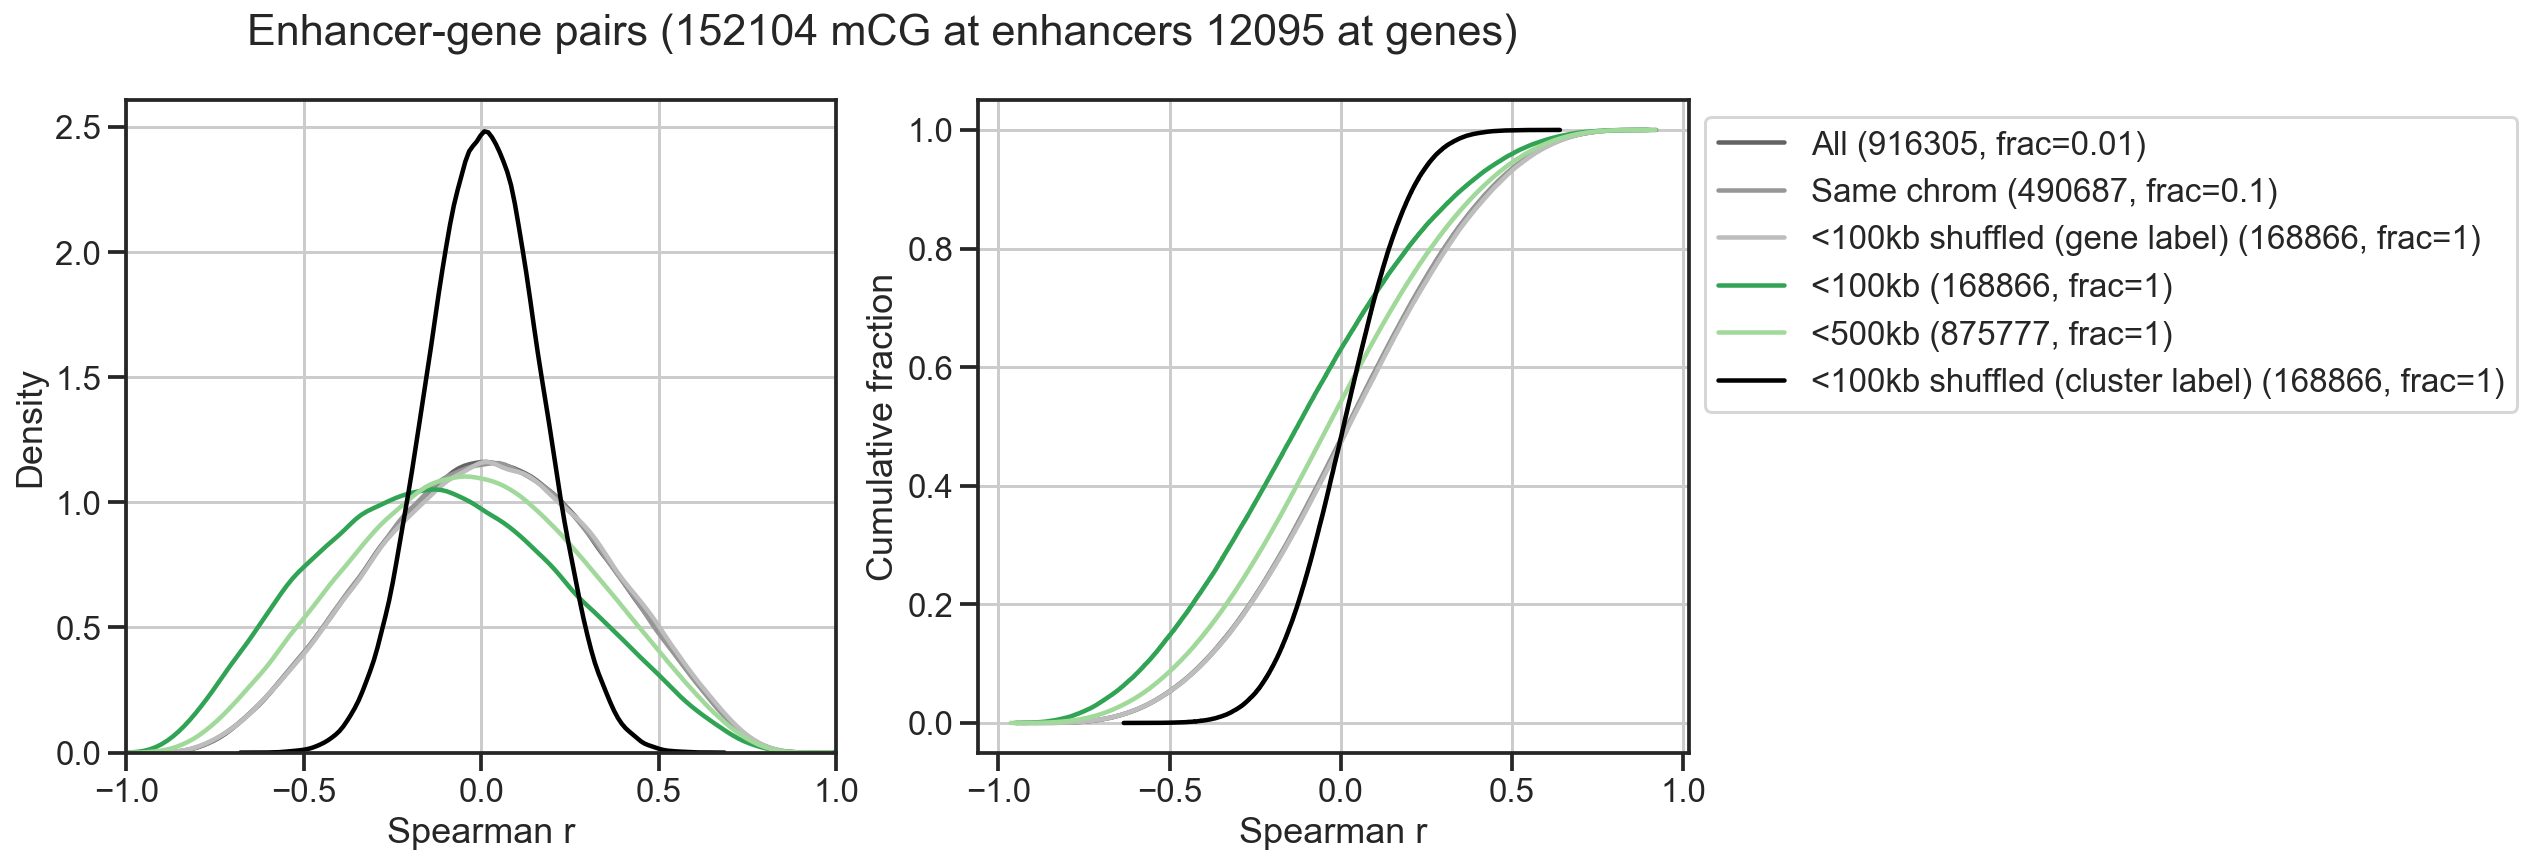

In [156]:
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color in zip(corr_tracks, labels, colors):
        if label == '<200kb':
            continue
        sns.distplot(np.sort(_x), ax=ax, 
#                      label='{} ({})'.format(label, len(_x)),
                     color=color,
                     hist=False,
                    )

    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Density')
    ax.set_xlim([-1, 1])
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        if label == '<200kb':
            continue
            
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Cumulative fraction')
    
    fig.suptitle('Enhancer-gene pairs ({} mCG at enhancers {} at genes)'.format(len(_y_features), len(_x_features)), 
                )
    
    output_name = 'distribution-different-categories' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.tight_layout()
    plt.show()

<ipython-input-157-072482ba6d3a>:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


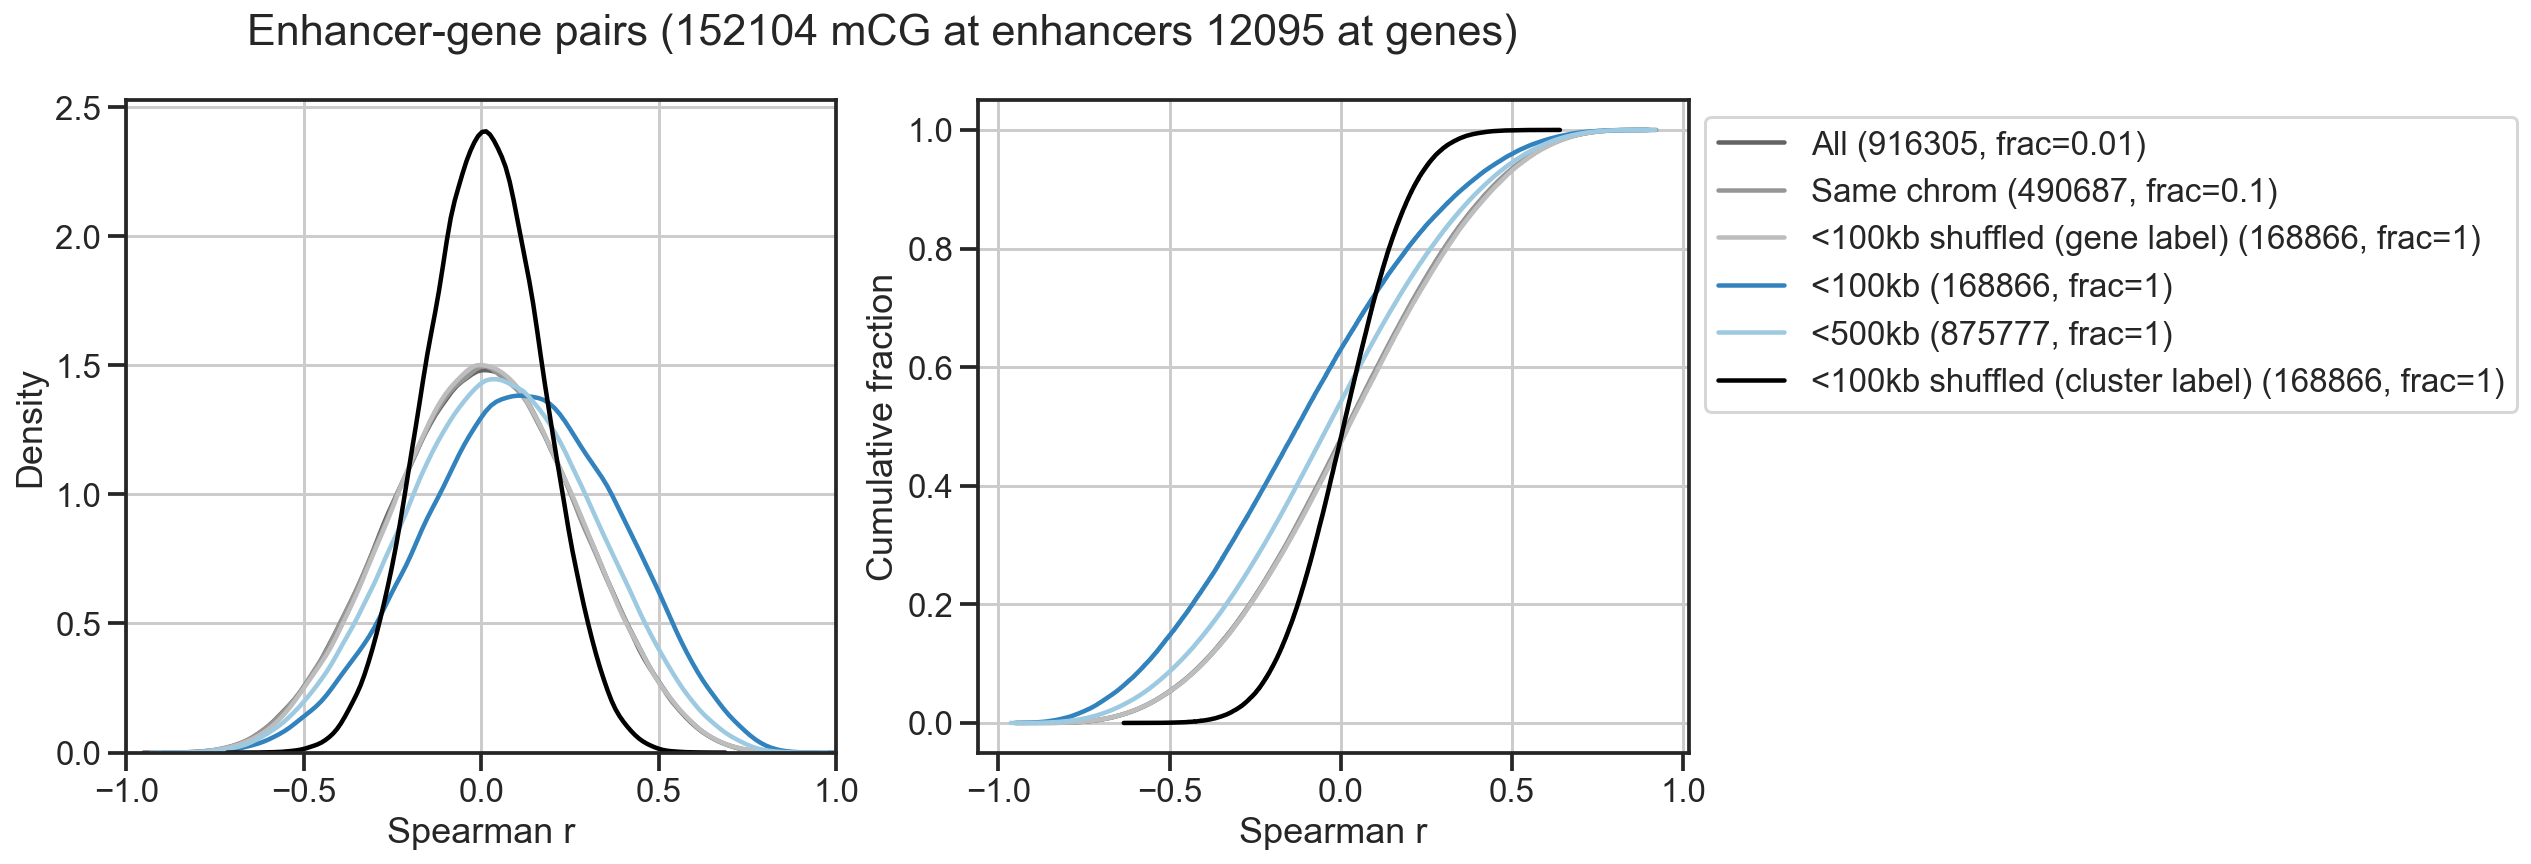

In [157]:
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color in zip(corr_tracks2, labels, colors2):
        if label == '<200kb':
            continue
        sns.distplot(np.sort(_x), ax=ax, 
#                      label='{} ({})'.format(label, len(_x)),
                     color=color,
                     hist=False,
                    )

    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Density')
    ax.set_xlim([-1, 1])
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors2, subsample_rates):
        if label == '<200kb':
            continue
            
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Cumulative fraction')
    
    fig.suptitle('Enhancer-gene pairs ({} mCG at enhancers {} at genes)'.format(len(_y_features), len(_x_features)), 
                )
    
    output_name = 'distribution-different-categories2' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.tight_layout()
    plt.show()

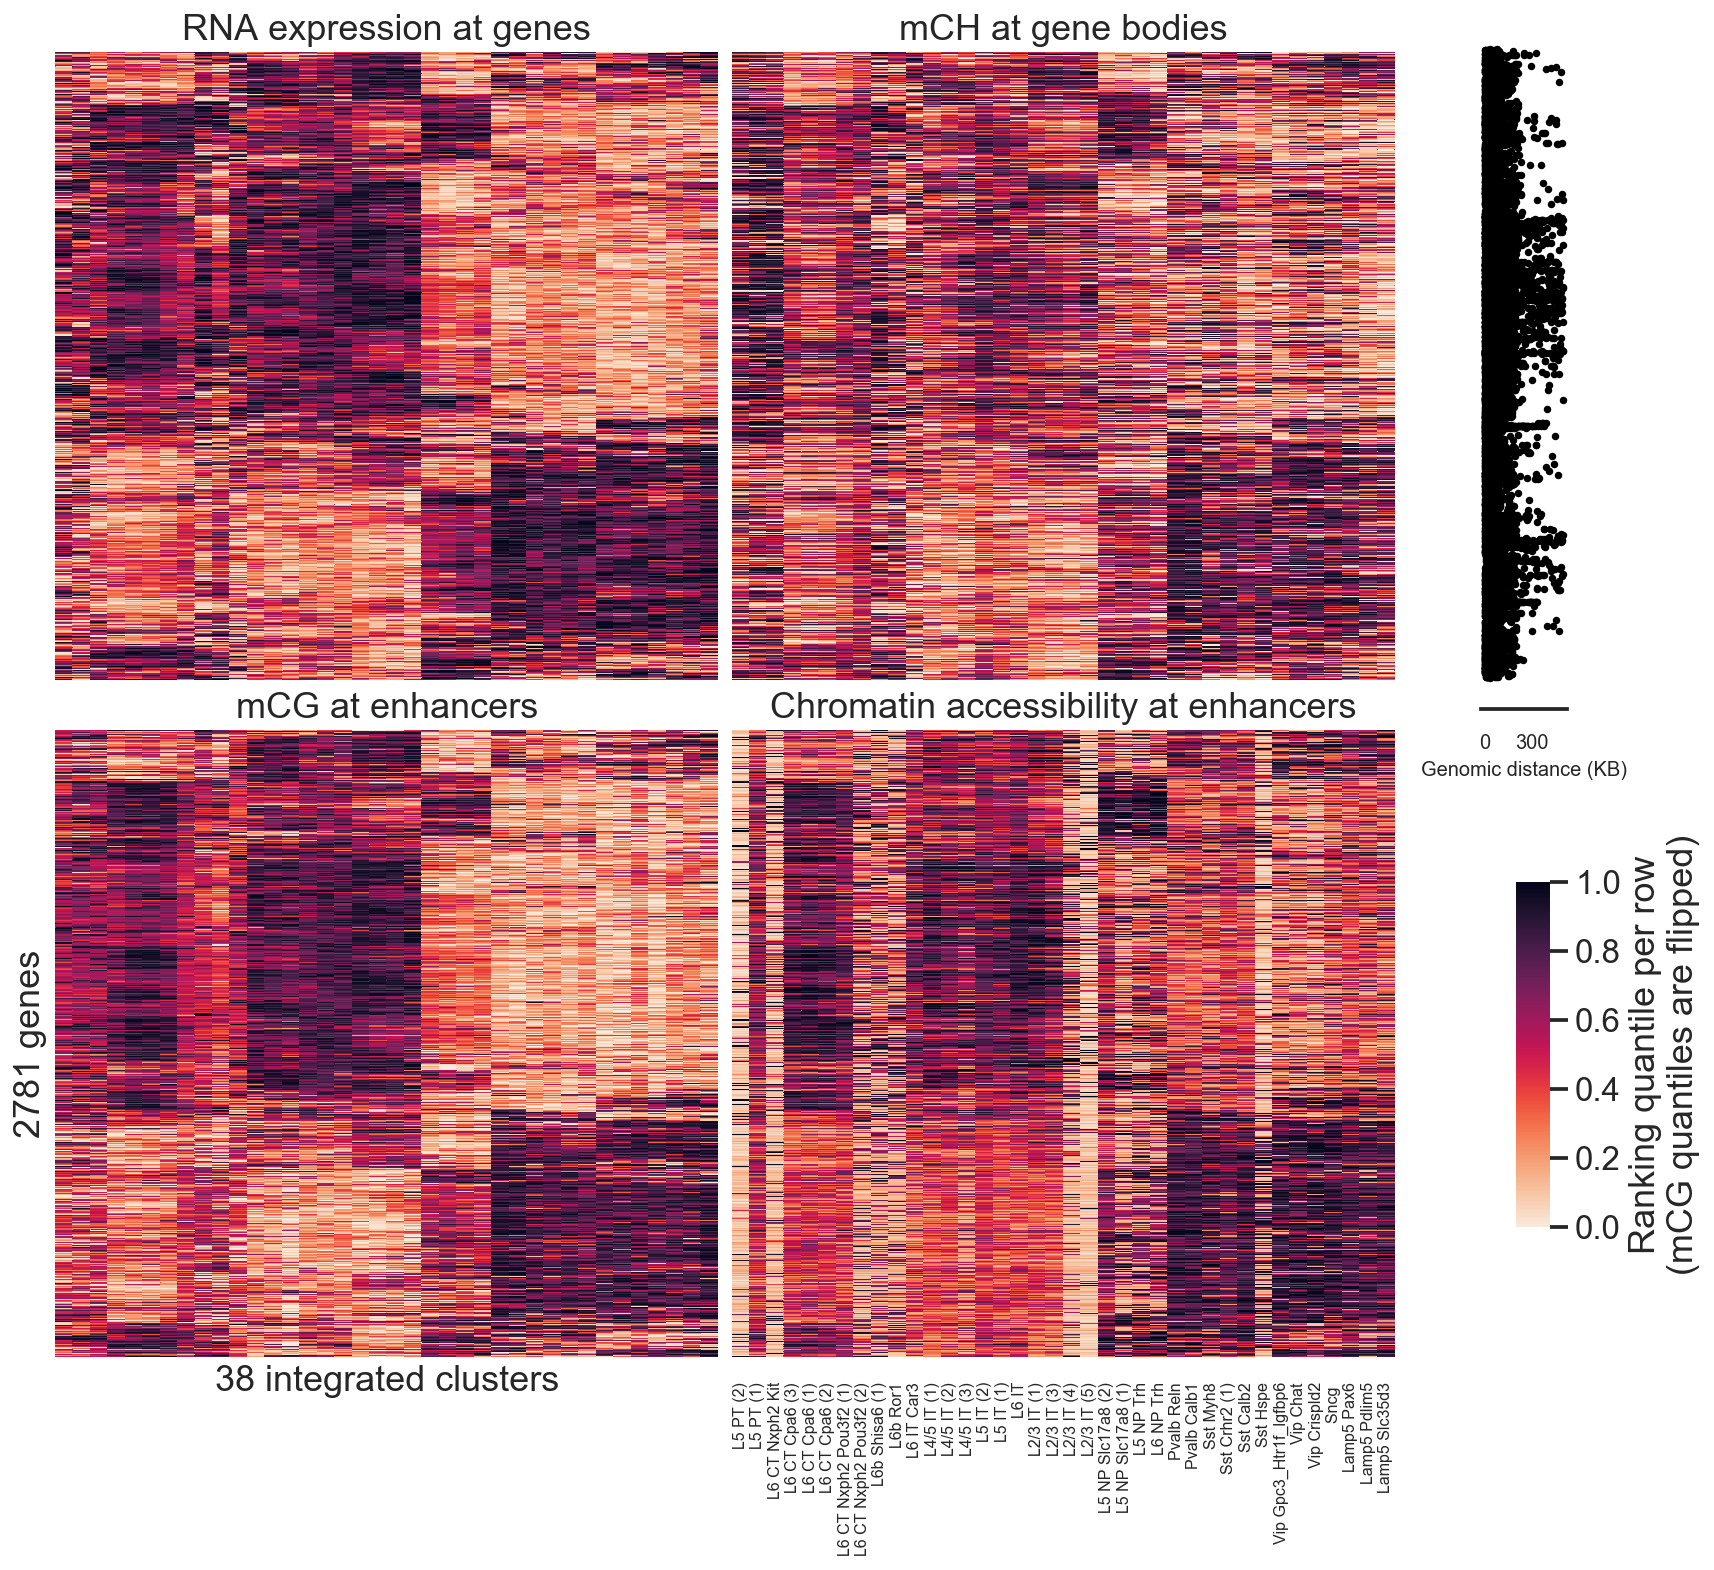

In [158]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

# back compactibility
clusters_selected = shared_clusters
clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clusters_selected])

def zscore(x):
    return (x - np.mean(x))/np.std(x)

cmap = 'rocket_r'

# rna at genes 
rna_mat = gene_rna_clsts.loc[top_sig_genes, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

# 
genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = top_sig.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    cbar_ax = fig.add_axes([.97, .2, .02, .2])
    
    # distance panel
    dist_ax = fig.add_axes([.95, .5, .05, .4])
    ax = dist_ax
    
    dists = top_sig.set_index('gene').loc[genes_ordered,  'dist']/KB
    genes_idx = snmcseq_utils.get_index_from_array(genes_ordered, dists.index.values)
    
    ax.scatter(dists.values, genes_idx, s=5, c='black',
               rasterized=True,
              )
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Genomic distance (KB)', fontsize=10)
    
    
    ax = axs[0,0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
#                     xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                    rasterized=True,
                   )
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,0]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    # xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    ax.set_title('mCG at enhancers')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))
    
    ax = axs[0,1]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,1]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
#     fig.tight_layout()
    output_name = 'heatmap-example-enhancer-genes' 
    snmcseq_utils.savefig(fig, output_figures.format(output_name, 'pdf'))
    plt.show()

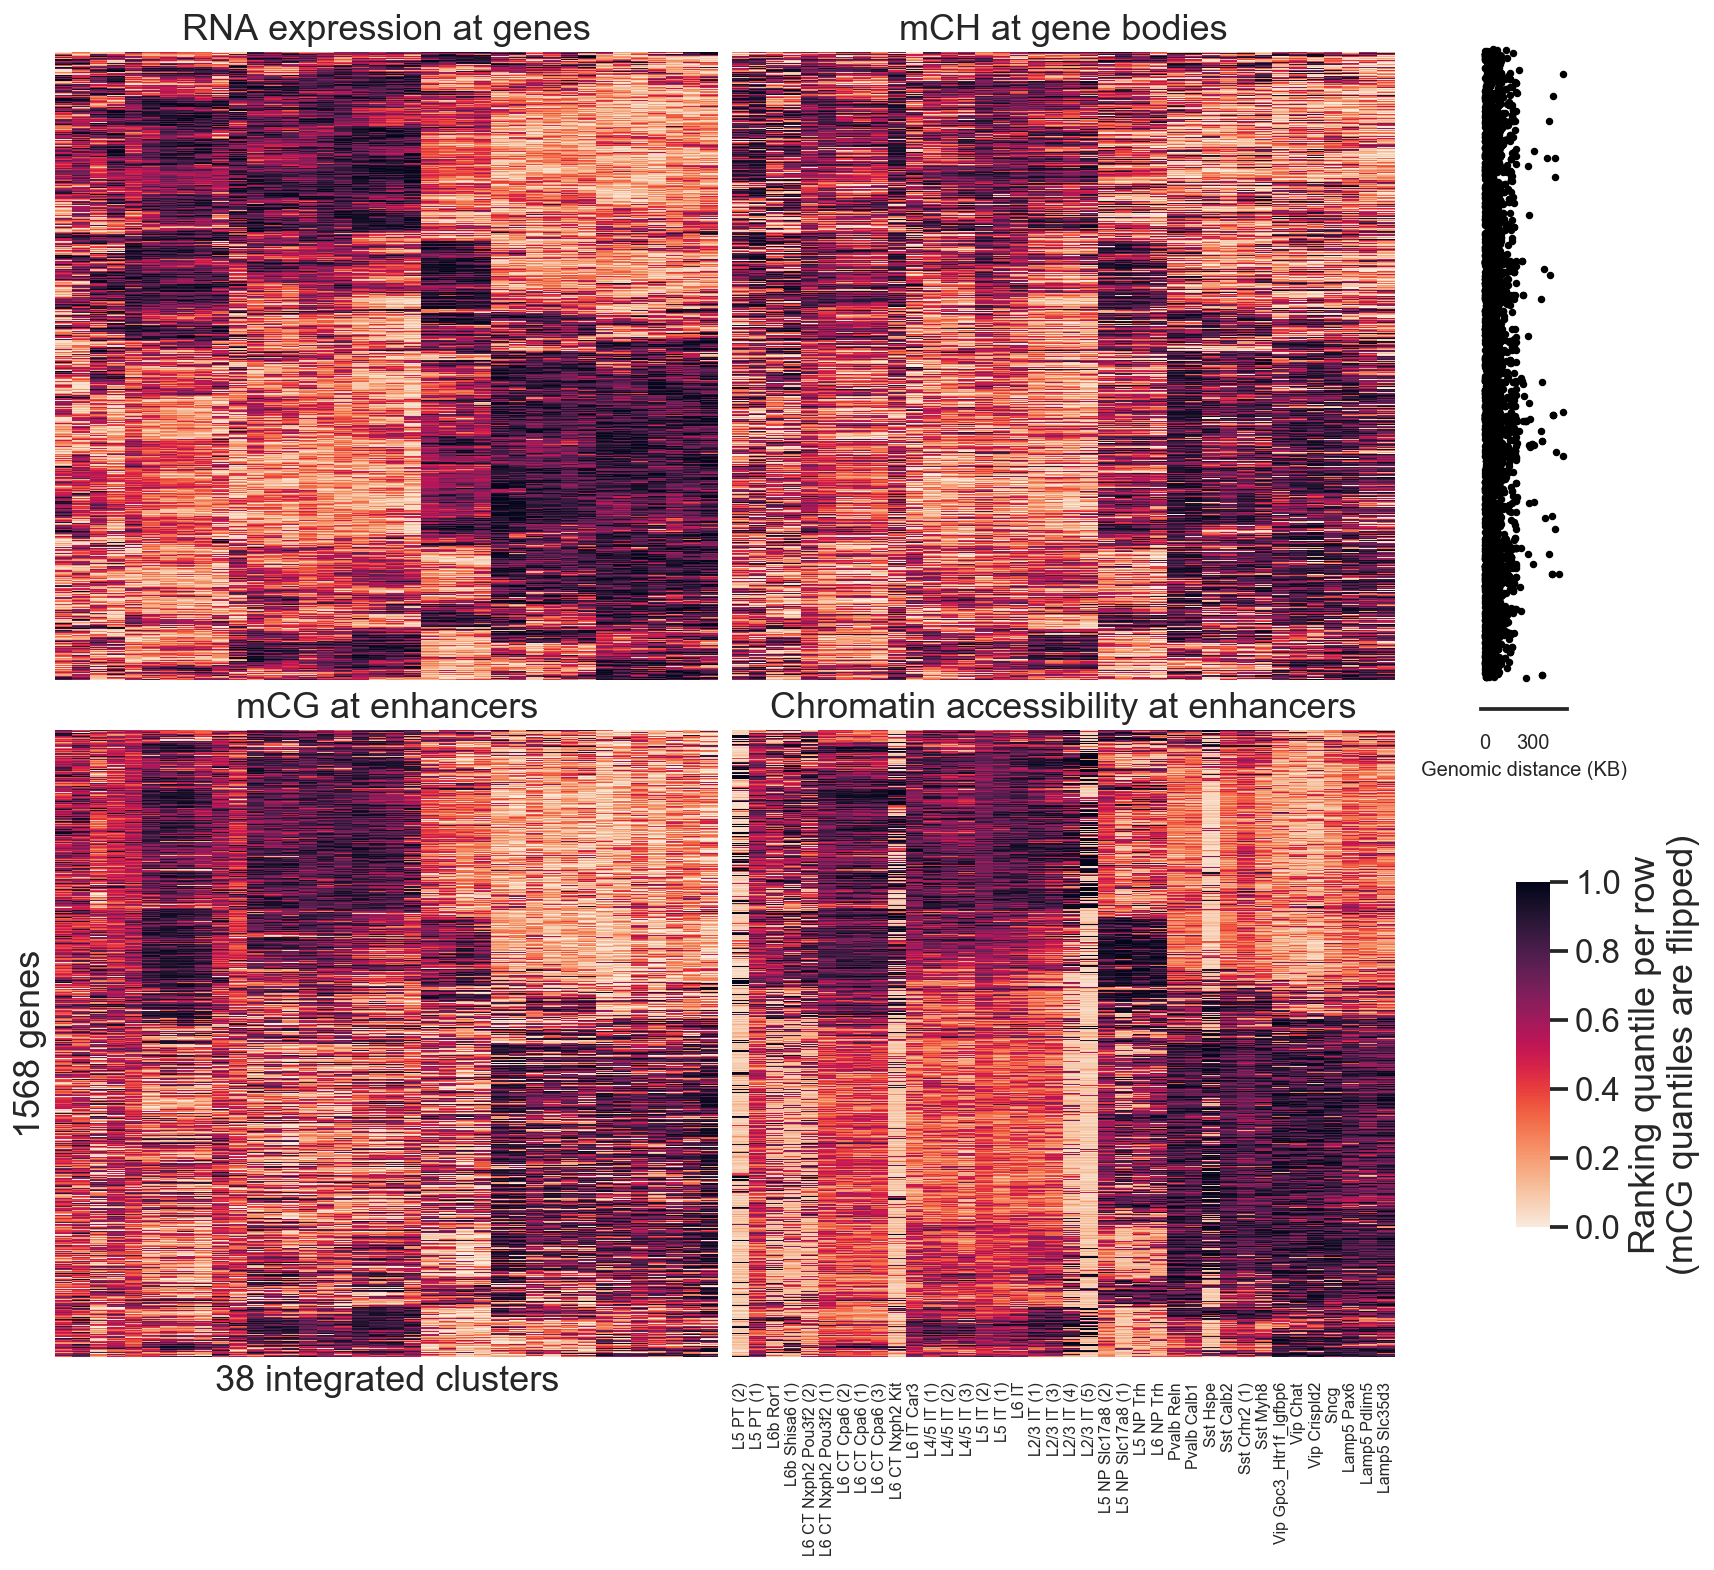

In [159]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

# back compactibility
clusters_selected = shared_clusters
clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clusters_selected])

def zscore(x):
    return (x - np.mean(x))/np.std(x)

cmap = 'rocket_r'

# rna at genes 
rna_mat = gene_rna_clsts.loc[top_sig2_genes, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

# 
genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = top_sig2.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    cbar_ax = fig.add_axes([.97, .2, .02, .2])
    
    # distance panel
    dist_ax = fig.add_axes([.95, .5, .05, .4])
    ax = dist_ax
    
    dists = top_sig2.set_index('gene').loc[genes_ordered,  'dist']/KB
    genes_idx = snmcseq_utils.get_index_from_array(genes_ordered, dists.index.values)
    
    ax.scatter(dists.values, genes_idx, s=5, c='black', 
                rasterized=True,
              )
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Genomic distance (KB)', fontsize=10)
    
    
    ax = axs[0,0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    vmin=0, vmax=1,
                    ax=ax,
                    rasterized=True,
                    cmap=cmap,
                   )
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,0]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    # xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    ax.set_title('mCG at enhancers')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))
    
    ax = axs[0,1]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,1]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    rasterized=True,
                    ax=ax)
    
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
#     fig.tight_layout()
    output_name = 'heatmap-example-enhancer-genes2' 
    snmcseq_utils.savefig(fig, output_figures.format(output_name, 'pdf'))
    plt.show()

In [160]:
output_toevals = output_results.format('to_evals.tsv')
to_evals.to_csv(output_toevals, sep="\t", header=True, index=False)
print(to_evals.shape)

(1710144, 18)


### one example correlation

In [161]:
def scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_gene_enh'):
    """
    """
    fontsize = 10
    
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5))
    ax = axs[0]
    _x = enh_mcg_clsts.loc[enh, clusters_selected]
    _y = gene_rna_clsts.loc[gene, clusters_selected]
    _c = pd.Series(clst_annot)[clusters_selected]
    print(_x.sort_values().index.tolist())
    ax.invert_xaxis()

    ax.scatter(_x.values, _y.values, c=mod_palette['mc'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
#     for __x, __y, __c in zip(_x, _y, _c):
#         if __y > 1:
#             ax.text(__x, __y, __c, fontsize=fontsize)
    ax.set_xlabel('{}\nenhancer mCG'.format(enh_name))
    ax.set_ylabel('{} expression\nlog10(TPM+1)'.format(gid_to_name.loc[gene]))

    ax = axs[1]
    _x = enh_atac_clsts.loc[enh, clusters_selected]
    _y = gene_rna_clsts.loc[gene, clusters_selected]
    _c = pd.Series(clst_annot)[clusters_selected]

    ax.scatter(_x.values, _y.values, c=mod_palette['atac'])
    r, p = stats.spearmanr(_x.values, _y.values)
    ax.set_title('r = {:.2f}'.format(r))
#     for __x, __y, __c in zip(_x, _y, _c):
#         if __y > 1:
#             ax.text(__x, __y, __c, fontsize=fontsize)
    ax.set_xlabel('enhancer ATAC\nlog10(RPM+1)')
    ax.set_ylabel('')

    fig.tight_layout()
    if output:
        fig.savefig(output_figures.format(output, 'pdf'), bbox_inches='tight')
    plt.show()

In [162]:
to_evals['val_both'] = to_evals['val'] + (-to_evals['val2'])

In [163]:
to_evals.sort_values('val2', ascending=False).head(40)

gene     ens  in_gene       val      val2  \
1070093  ENSMUSG00000039156  171582    False -0.696247  0.918153   
1070094  ENSMUSG00000039156  171583    False -0.790130  0.916621   
1300635  ENSMUSG00000049907  173242    False -0.763213  0.900427   
1458718  ENSMUSG00000062309  221967    False -0.448736  0.888172   
1300634  ENSMUSG00000049907  173241    False -0.811796  0.886640   
1300633  ENSMUSG00000049907  173240    False -0.819674  0.884014   
1033532  ENSMUSG00000038256  146495     True -0.765401  0.881387   
610167   ENSMUSG00000028161  150012    False -0.745486  0.878980   
1545786  ENSMUSG00000075224  129318    False -0.667360  0.874166   
610166   ENSMUSG00000028161  150011    False -0.774592  0.872853   
302152   ENSMUSG00000021719   64445     True -0.602801  0.871321   
1070095  ENSMUSG00000039156  171584    False -0.872634  0.870883   
1555065  ENSMUSG00000078591  202629     True -0.734982  0.868476   
1563549  ENSMUSG00000079434    7749    False -0.673487  0.868038   
437092   ENSMUSG00000024646  114787    False -0.336689  0.867600   
435758   ENSMUSG00000024617  111314    False -0.785535  0.864755   
1281044  ENSMUSG00000048644  204535    False -0.750301  0.864318   
610168   ENSMUSG00000028161  150013    False -0.837181  0.864318   
1354504  ENSMUSG00000053519   33288     True -0.774155  0.861254   
1618105  ENSMUSG00000092060  172601     True -0.709159  0.859941   
1033533  ENSMUSG00000038256  146496     True -0.866068  0.859503   
1281045  ENSMUSG00000048644  204536    False -0.711566  0.859066   
811538   ENSMUSG00000032020  219849     True -0.772842  0.858847   
959463   ENSMUSG00000036158   86170    False -0.711785  0.858409   
811539   ENSMUSG00000032020  219850     True -0.633001  0.858190   
1511819  ENSMUSG00000070880  127546    False -0.153518  0.855345   
854159   ENSMUSG00000032788   24901     True -0.802604  0.855126   
711780   ENSMUSG00000029651  180522     True -0.705001  0.853813   
146900   ENSMUSG00000017412  125809     True -0.722946  0.853376   
1109468  ENSMUSG00000040195   30489    False -0.055258  0.852938   
1478481  ENSMUSG00000064065   18120     True -0.596674  0.852938   
811537   ENSMUSG00000032020  219848     True -0.484189  0.852938   
611116   ENSMUSG00000028184  151565     True -0.803698  0.852938   
1493619  ENSMUSG00000067879     278    False -0.751395  0.852063   
1458717  ENSMUSG00000062309  221966    False -0.778094  0.851844   
1674507  ENSMUSG00000106515  151565    False -0.778094  0.851406   
921911   ENSMUSG00000034813   29638     True -0.729730  0.850531   
435757   ENSMUSG00000024617  111311    False -0.829303  0.849874   
854158   ENSMUSG00000032788   24900     True -0.612211  0.849436   
1695595  ENSMUSG00000112663   45559    False -0.614619  0.848342   

         val_clustershuffled  val2_clustershuffled    dist   pvalues  \
1070093             0.156144              0.085020   56976  0.005647   
1070094             0.145858              0.094212   56473  0.000710   
1300635             0.163147              0.213262   58655  0.001478   
1458718            -0.090054              0.079549    4254  0.073370   
1300634             0.065324              0.225079   58168  0.000342   
1300633            -0.009301              0.235584   57497  0.000255   
1033532            -0.029872             -0.104278    2922  0.001399   
610167              0.026152              0.164679  697994  0.002243   
1545786             0.336689              0.203195   20661  0.008840   
610166             -0.040814              0.211511  698424  0.001107   
302152             -0.209104              0.085896   16300  0.019928   
1070095             0.063355              0.154393   55618  0.000017   
1555065             0.340190             -0.002517  238251  0.002788   
1563549            -0.010614              0.268191   93599  0.008103   
437092             -0.348069              0.060072   40016  0.140012   
435758             -0.189189              0.360762   99835  0.000817   
1281044   

In [164]:
to_evals.sort_values('val_both', ascending=False).head()

gene     ens  in_gene       val      val2  \
1107956  ENSMUSG00000040133  131993    False  0.874385 -0.904366   
838877   ENSMUSG00000032501   81627    False  0.863442 -0.839807   
58162    ENSMUSG00000004508  200167    False  0.860160 -0.799322   
1539439  ENSMUSG00000074656  135937    False  0.866287 -0.790130   
329979   ENSMUSG00000022216   70350    False  0.840464 -0.796695   

         val_clustershuffled  val2_clustershuffled    dist   pvalues  \
1107956             0.152643             -0.274319  984955  0.999968   
838877              0.006675              0.074297  847920  0.999943   
58162               0.062479             -0.226174  243110  0.999933   
1539439             0.131853              0.000547  929989  0.999951   
329979             -0.035343             -0.063574  985634  0.999822   

         fdr<100kb  fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  \
1107956   0.999989   0.999991   0.999992                            0.999973   
838877    0.999985   0.999985   0.999991                            0.999948   
58162     0.999983   0.999982   0.999991                            0.999938   
1539439   0.999987   0.999987   0.999992                            0.999956   
329979    0.999951   0.999967   0.999977                            0.999827   

         pvalues2  fdr2<100kb  fdr2<200kb  fdr2<500kb  \
1107956  1.000000    0.999999    0.999999    0.999999   
838877   0.999994    0.999993    0.999993    0.999998   
58162    0.999950    0.999966    0.999963    0.999985   
1539439  0.999923    0.999955    0.999946    0.999968   
329979   0.999942    0.999963    0.999959    0.999980   

         fdr2<100kb shuffled (cluster label)  val_both  
1107956                             0.999999  1.778750  
838877                              0.999993  1.703250  
58162                               0.999949  1.659481  
1539439                             0.999922  1.656418  
329979                              0.999941  1.637159

In [165]:
to_evals

gene     ens  in_gene       val      val2  \
0        ENSMUSG00000000001  147520    False -0.416129  0.207791   
1        ENSMUSG00000000001  147522    False -0.048692 -0.142357   
2        ENSMUSG00000000001  147523    False -0.109531  0.267535   
3        ENSMUSG00000000001  147527    False -0.134916  0.096838   
4        ENSMUSG00000000001  147528    False -0.355291  0.098807   
...                     ...     ...      ...       ...       ...   
1710139  ENSMUSG00000115850   78351    False -0.379144  0.171244   
1710140  ENSMUSG00000115850   78352    False  0.118284 -0.274975   
1710141  ENSMUSG00000115850   78353    False  0.086771 -0.193785   
1710142  ENSMUSG00000115850   78354    False -0.129664 -0.044316   
1710143  ENSMUSG00000115850   78355    False  0.151111 -0.143013   

         val_clustershuffled  val2_clustershuffled    dist   pvalues  \
0                   0.071233             -0.002079  995118  0.090151   
1                   0.120473             -0.145858  985740  0.414462   
2                   0.027902             -0.259875  983725  0.346690   
3                   0.201007             -0.100120  970444  0.319497   
4                   0.248714             -0.124412  969372  0.127221   
...                      ...                   ...     ...       ...   
1710139             0.007769             -0.058540  987455  0.111818   
1710140            -0.124631              0.215888  990293  0.606826   
1710141            -0.126381              0.138855  991444  0.570992   
1710142            -0.226611             -0.092899  992735  0.325111   
1710143            -0.085896              0.099245  999670  0.643496   

         fdr<100kb  fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  \
0         0.428458   0.520486   0.669566                           32.735334   
1         0.719874   0.777051   0.859596                            1.183878   
2         0.676042   0.740894   0.834201                            1.570314   
3         0.657509   0.725010   0.823293                            1.817085   
4         0.482321   0.570199   0.709733                           14.019220   
...            ...        ...        ...                                 ...   
1710139   0.462009   0.551961   0.694596                           19.448042   
1710140   0.826504   0.864620   0.916113                            0.812695   
1710141   0.808300   0.850034   0.906870                            0.842109   
1710142   0.661514   0.728377   0.825660                            1.760751   
1710143   0.844515   0.878938   0.925422                            0.795631   

         pvalues2  fdr2<100kb  fdr2<200kb  fdr2<500kb  \
0        0.230154    0.605463    0.678469    0.795896   
1        0.716560    0.871078    0.898293    0.937717   
2        0.166588    0.549899    0.630306    0.760320   
3        0.375447    0.704613    0.763367    0.854526   
4        0.372630    0.702923    0.761896    0.853526   
...           ...         ...         ...         ...   
1710139  0.274302    0.638126    0.706717    0.815636   
1710140  0.858808    0.934276    0.948378    0.967818   
1710141  0.777998    0.898012    0.919585    0.950255   
1710142  0.582614    0.809840    0.849722    0.909184   
1710143  0.717389    0.871442    0.898578    0.937877   

         fdr2<100kb shuffled (cluster label)  val_both  
0                                   2.014674 -0.623919  
1                                   0.868963  0.093665  
2                                   2.956335 -0.377065  
3                                   1.237911 -0.231754  
4                                   1.245585 -0.454098  
...                                      ...       ...  
1710139                             1.666536 -0.550388  
1710140                             0.893362  0.393260  
1710141                             0.869359  0.280556  
1710142                             0.920102 -0.085349  
1710143                             0.868863  0.294124  

[1710144 r

In [166]:
to_evals.sort_values('val').head()

gene     ens  in_gene       val      val2  \
1295374  ENSMUSG00000049556  221845     True -0.963891  0.656855   
1295391  ENSMUSG00000049556  221868     True -0.962140  0.710909   
336719   ENSMUSG00000022332   83016     True -0.952730  0.168837   
1295377  ENSMUSG00000049556  221849     True -0.951198  0.431666   
336757   ENSMUSG00000022332   83063     True -0.948134  0.636503   

         val_clustershuffled  val2_clustershuffled    dist       pvalues  \
1295374            -0.085458              0.323121  172329  0.000000e+00   
1295391            -0.183280              0.130321  115681  0.000000e+00   
336719              0.135792             -0.122661  104705  0.000000e+00   
1295377            -0.066637              0.010614  169279  0.000000e+00   
336757              0.077580              0.111719  159432  5.843406e-08   

         fdr<100kb  fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  \
1295374    0.00000   0.000000   0.000000                            0.000000   
1295391    0.00000   0.000000   0.000000                            0.000000   
336719     0.00000   0.000000   0.000000                            0.000000   
1295377    0.00000   0.000000   0.000000                            0.000000   
336757     0.00455   0.005681   0.012486                            0.058434   

         pvalues2  fdr2<100kb  fdr2<200kb  fdr2<500kb  \
1295374  0.002971    0.174310    0.245810    0.387214   
1295391  0.000946    0.125530    0.185621    0.310883   
336719   0.277376    0.640286    0.708555    0.816934   
1295377  0.050867    0.386987    0.475807    0.633044   
336757   0.004215    0.192344    0.263507    0.408603   

         fdr2<100kb shuffled (cluster label)  val_both  
1295374                           429.207247 -1.620746  
1295391                           136.727057 -1.673050  
336719                              1.647945 -1.121567  
1295377                            15.512834 -1.382865  
336757                            365.485811 -1.584637

In [167]:
to_evals.sort_values('val_both').head()

gene     ens  in_gene       val      val2  \
1070095  ENSMUSG00000039156  171584    False -0.872634  0.870883   
1090712  ENSMUSG00000039706  170709     True -0.918153  0.819674   
95295    ENSMUSG00000008489  160142     True -0.904804  0.832367   
1033533  ENSMUSG00000038256  146496     True -0.866068  0.859503   
1419716  ENSMUSG00000058975  196262     True -0.885983  0.825364   

         val_clustershuffled  val2_clustershuffled   dist   pvalues  \
1070095             0.063355              0.154393  55618  0.000017   
1090712            -0.039282             -0.019368   3839  0.000001   
95295              -0.061823             -0.057008  37984  0.000002   
1033533             0.014115             -0.107123   2401  0.000026   
1419716             0.103184             -0.098370   9477  0.000008   

         fdr<100kb  fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  \
1070095   0.011035   0.018999   0.042217                           16.610180   
1090712   0.007012   0.011185   0.027319                            1.209024   
95295     0.005915   0.009662   0.023018                            2.296214   
1033533   0.013863   0.024039   0.052534                           25.517752   
1419716   0.007954   0.013315   0.030650                            7.507005   

         pvalues2  fdr2<100kb  fdr2<200kb  fdr2<500kb  \
1070095  0.000002    0.021269    0.043120    0.098514   
1090712  0.000029    0.058539    0.086512    0.167994   
95295    0.000016    0.053491    0.082047    0.167671   
1033533  0.000005    0.042181    0.078853    0.170330   
1419716  0.000023    0.056604    0.084547    0.167333   

         fdr2<100kb shuffled (cluster label)  val_both  
1070095                             0.236209 -1.743517  
1090712                             4.161131 -1.737827  
95295                               2.374222 -1.737170  
1033533                             0.776026 -1.725572  
1419716                             3.269606 -1.711347

In [168]:
gene = 'ENSMUSG00000040133'
to_evals[to_evals['gene']==gene].sort_values('val_both').head(10)

gene     ens  in_gene       val      val2  \
1108018  ENSMUSG00000040133  132088     True -0.934566  0.730605   
1108019  ENSMUSG00000040133  132089     True -0.778750  0.824707   
1108020  ENSMUSG00000040133  132090     True -0.789255  0.789036   
1107995  ENSMUSG00000040133  132054    False -0.909180  0.534304   
1108015  ENSMUSG00000040133  132084     True -0.723383  0.694496   
1108054  ENSMUSG00000040133  132137    False -0.781377  0.616369   
1108012  ENSMUSG00000040133  132077     True -0.706970  0.648977   
1108039  ENSMUSG00000040133  132114    False -0.808513  0.511106   
1108008  ENSMUSG00000040133  132072     True -0.743298  0.575665   
1108016  ENSMUSG00000040133  132085     True -0.628843  0.667360   

         val_clustershuffled  val2_clustershuffled    dist       pvalues  \
1108018            -0.055914              0.104497   18922  5.495508e-07   
1108019            -0.070139              0.190721    9799  9.842702e-04   
1108020            -0.097275              0.257249    8988  7.275445e-04   
1107995            -0.150235              0.105154  213432  1.939758e-06   
1108015             0.033811              0.245651   40889  3.481754e-03   
1108054            -0.078236              0.010395  409071  9.192460e-04   
1108012            -0.049349              0.173651   76419  4.700267e-03   
1108039            -0.050224              0.294671  273610  3.808708e-04   
1108008            -0.045847              0.211949   88300  2.352500e-03   
1108016            -0.054820              0.135573   39800  1.484934e-02   

         fdr<100kb  fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  \
1108018   0.013718   0.015314   0.037072                            0.549551   
1108019   0.081024   0.125787   0.235767                          984.270224   
1108020   0.071969   0.112350   0.213403                          727.544478   
1107995   0.006806   0.011011   0.026606                            1.939758   
1108015   0.135620   0.196851   0.335552                         3481.754018   
1108054   0.079020   0.122827   0.230901                          919.246012   
1108012   0.151262   0.216978   0.361810                         4700.267245   
1108039   0.051982   0.083682   0.165153                          380.870799   
1108008   0.115860   0.171656   0.302943                         2352.499754   
1108016   0.234123   0.314791   0.475713                        14849.338292   

         pvalues2  fdr2<100kb  fdr2<200kb  fdr2<500kb  \
1108018  0.000586    0.111487    0.168549    0.289398   
1108019  0.000023    0.056872    0.084821    0.167427   
1108020  0.000096    0.075759    0.118660    0.224521   
1107995  0.017825    0.291760    0.375437    0.534121   
1108015  0.001377    0.140038    0.202694    0.331554   
1108054  0.005849    0.212287    0.287487    0.437898   
1108012  0.003426    0.181482    0.253259    0.396778   
1108039  0.023375    0.314410    0.399223    0.560888   
1108008  0.010523    0.251002    0.330633    0.486066   
1108016  0.002420    0.165541    0.234609    0.371256   

         fdr2<100kb shuffled (cluster label)  val_both  
1108018                            84.643740 -1.665171  
1108019                             3.372475 -1.603458  
1108020                            13.816130 -1.578291  
1107995                            82.752876 -1.443484  
1108015                           198.971762 -1.417879  
1108054                           291.953707 -1.397746  
1108012                           494.940029 -1.355947  
1108039                            59.237697 -1.319619  
1108008                           173.840587 -1.318963  
1108016                           349.591376 -1.296203

In [169]:
gene = 131993
to_evals[to_evals['ens']==gene].sort_values('val_both').head(10)

gene     ens  in_gene       val      val2  \
568824   ENSMUSG00000027347  131993    False -0.721414  0.746143   
569305   ENSMUSG00000027351  131993    False -0.686180  0.728417   
568991   ENSMUSG00000027349  131993    False -0.537367  0.593610   
1574934  ENSMUSG00000085316  131993    False -0.482000  0.603677   
1107956  ENSMUSG00000040133  131993    False  0.874385 -0.904366   

         val_clustershuffled  val2_clustershuffled    dist   pvalues  \
568824             -0.048911              0.216107   45463  0.003611   
569305              0.064011              0.348506  267090  0.006664   
568991             -0.011270              0.209979  138725  0.037659   
1574934            -0.050443              0.141482  488312  0.058346   
1107956             0.152643             -0.274319  984955  0.999968   

         fdr<100kb  fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  \
568824    0.137557   0.199309   0.338807                         3610.826639   
569305    0.171876   0.243614   0.394707                         6663.931176   
568991    0.321876   0.411182   0.574994                          335.190880   
1574934   0.371207   0.463715   0.621773                           96.349615   
1107956   0.999989   0.999991   0.999992                            0.999973   

         pvalues2  fdr2<100kb  fdr2<200kb  fdr2<500kb  \
568824   0.000386    0.104268    0.159269    0.277220   
569305   0.000617    0.112390    0.169573    0.290766   
568991   0.008191    0.234414    0.311962    0.464698   
1574934  0.007073    0.225088    0.301543    0.453012   
1107956  1.000000    0.999999    0.999999    0.999999   

         fdr2<100kb shuffled (cluster label)  val_both  
568824                             55.757607 -1.467557  
569305                             89.125071 -1.414597  
568991                            211.487558 -1.130977  
1574934                           240.718773 -1.085677  
1107956                             0.999999  1.778750

In [170]:
gene = df_genes_v2.loc['Slc1a2', 'gid']
to_evals[to_evals['gene']==gene].sort_values('val').head()

gene     ens  in_gene       val      val2  \
64962  ENSMUSG00000005089  130608     True -0.847686  0.439982   
64969  ENSMUSG00000005089  130616     True -0.846810  0.613524   
64968  ENSMUSG00000005089  130614     True -0.844841  0.598643   
64964  ENSMUSG00000005089  130610     True -0.831491  0.609585   
64973  ENSMUSG00000005089  130621     True -0.818142  0.576102   

       val_clustershuffled  val2_clustershuffled   dist   pvalues  fdr<100kb  \
64962            -0.069045              0.136448  11277  0.000074   0.024305   
64969             0.049568             -0.113032  25421  0.000078   0.024949   
64968            -0.017398             -0.066856  23514  0.000086   0.026288   
64964            -0.062917             -0.064668  19639  0.000159   0.035295   
64973             0.026371              0.049130  29658  0.000270   0.044808   

       fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  \
64962   0.041586   0.088299                           73.980148  0.047242   
64969   0.042587   0.090279                           77.829870  0.006111   
64968   0.044657   0.094350                           86.491744  0.007597   
64964   0.058483   0.120412                          159.422646  0.006475   
64973   0.073229   0.146975                          270.454547  0.010460   

       fdr2<100kb  fdr2<200kb  fdr2<500kb  \
64962    0.379212    0.467648    0.626159   
64969    0.215300    0.290823    0.441479   
64968    0.229748    0.306584    0.458461   
64964    0.219190    0.295105    0.446041   
64973    0.250528    0.330113    0.485511   

       fdr2<100kb shuffled (cluster label)  val_both  
64962                            17.405134 -1.287668  
64969                           276.180998 -1.460335  
64968                           229.603492 -1.443484  
64964                           258.701602 -1.441077  
64973                           174.655891 -1.394244

Gpr176 chr2_117388097_117388832
['9-2-1', '4-2-2', '1-2-2', '1-1-1', '1-2-1', '2-3-2', '4-1-1', '3-1-1', '4-2-1', '2-1-1', '3-2-1', '9-1-1', '2-2-1', '3-1-2', '2-1-2', '8-2-1', '2-3-1', '8-1-1', '7-1-1', '2-3-3', '3-3-1', '4-2-3', '7-1-2', '7-2-2', '5-2-2', '5-3-2', '7-2-1', '6-1-1', '5-1-2', '5-2-1', '5-3-1', '5-1-1', '6-4-1', '6-3', '6-4-2', '6-5', '6-1-2', '6-2-1']


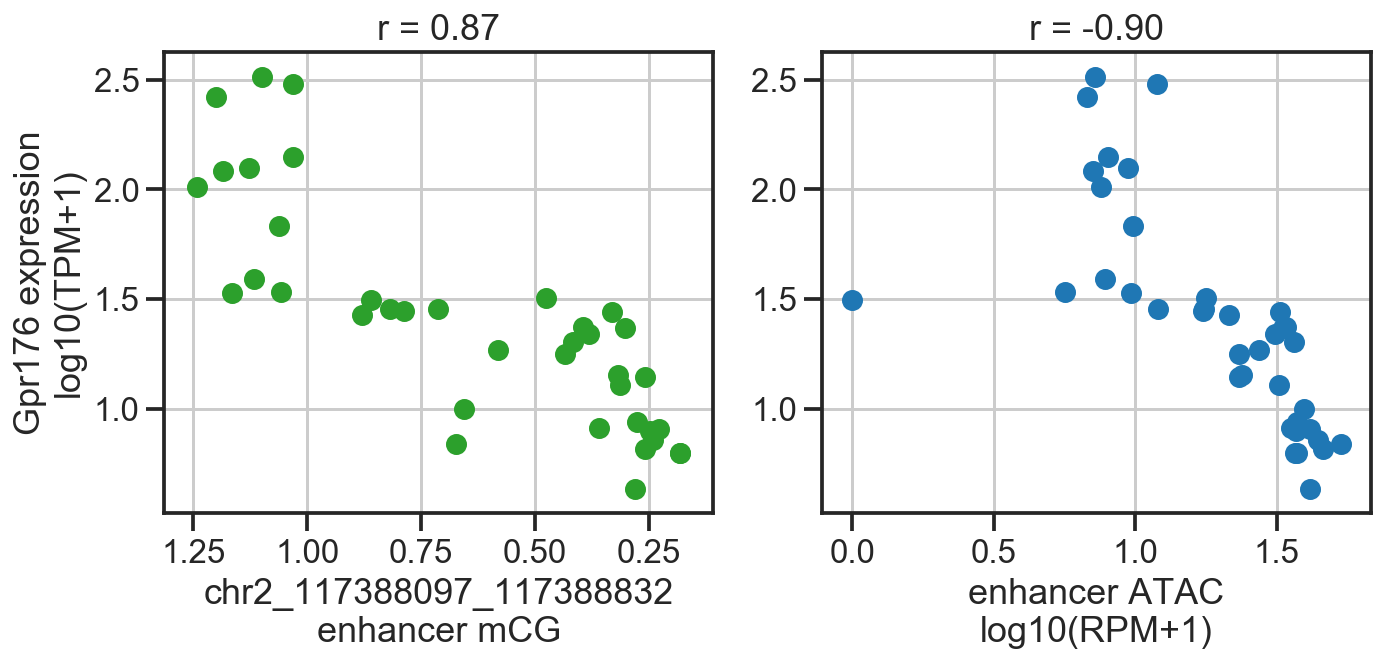

In [171]:
gene = 'ENSMUSG00000040133'
enh = 131993

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

Gpr176 chr2_118353416_118355578
['5-1-2', '5-1-1', '6-1-2', '6-3', '6-1-1', '6-5', '6-2-1', '6-4-1', '5-3-1', '5-2-1', '5-2-2', '6-4-2', '5-3-2', '7-1-2', '7-1-1', '7-2-2', '2-3-2', '2-2-1', '8-2-1', '9-1-1', '8-1-1', '9-2-1', '7-2-1', '2-1-1', '2-1-2', '3-2-1', '3-1-1', '2-3-1', '3-1-2', '3-3-1', '1-1-1', '2-3-3', '1-2-1', '4-2-3', '4-2-1', '1-2-2', '4-1-1', '4-2-2']


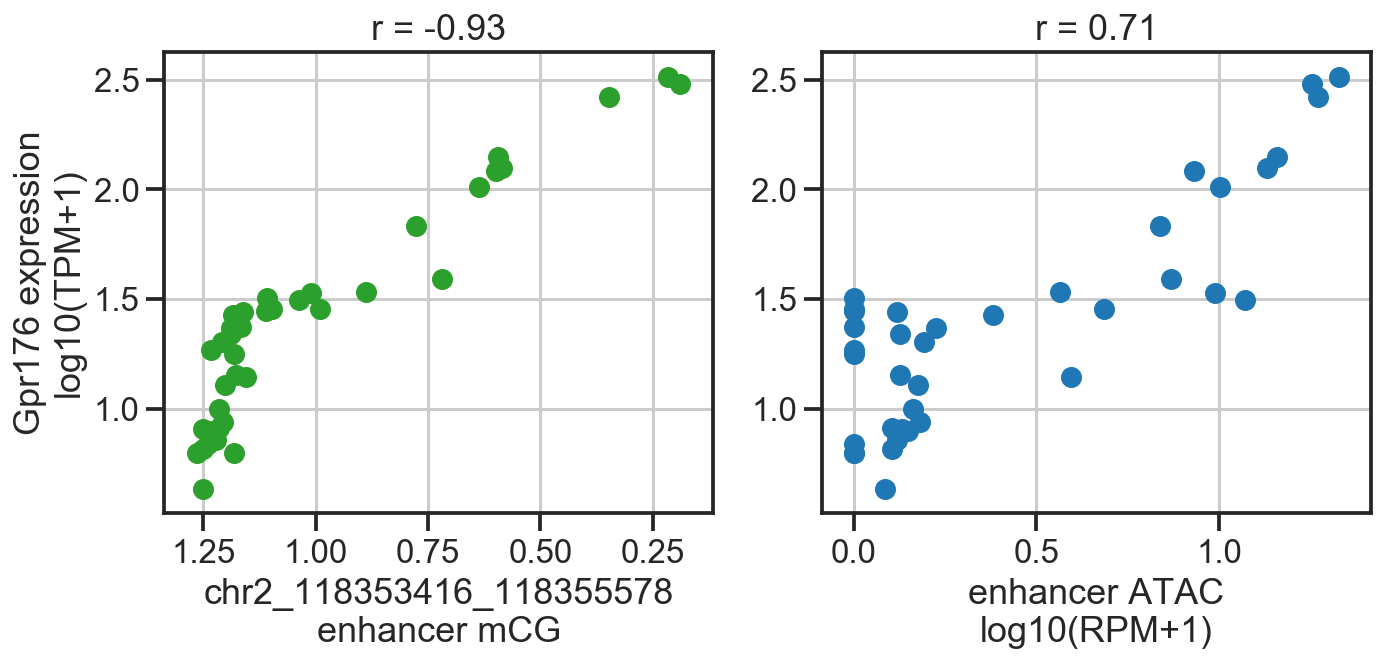

In [172]:
gene = 'ENSMUSG00000040133'
enh = 132088

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

Nemp1 chr10_127509882_127510420
['9-1-1', '6-1-1', '6-3', '2-1-1', '6-2-1', '6-4-1', '6-4-2', '6-5', '2-1-2', '2-3-1', '4-1-1', '2-3-2', '4-2-3', '8-2-1', '5-2-1', '2-2-1', '4-2-1', '5-2-2', '4-2-2', '3-1-1', '1-2-1', '2-3-3', '6-1-2', '1-1-1', '3-3-1', '3-2-1', '3-1-2', '9-2-1', '7-1-2', '8-1-1', '7-2-2', '1-2-2', '5-1-2', '7-2-1', '5-3-1', '5-1-1', '5-3-2', '7-1-1']


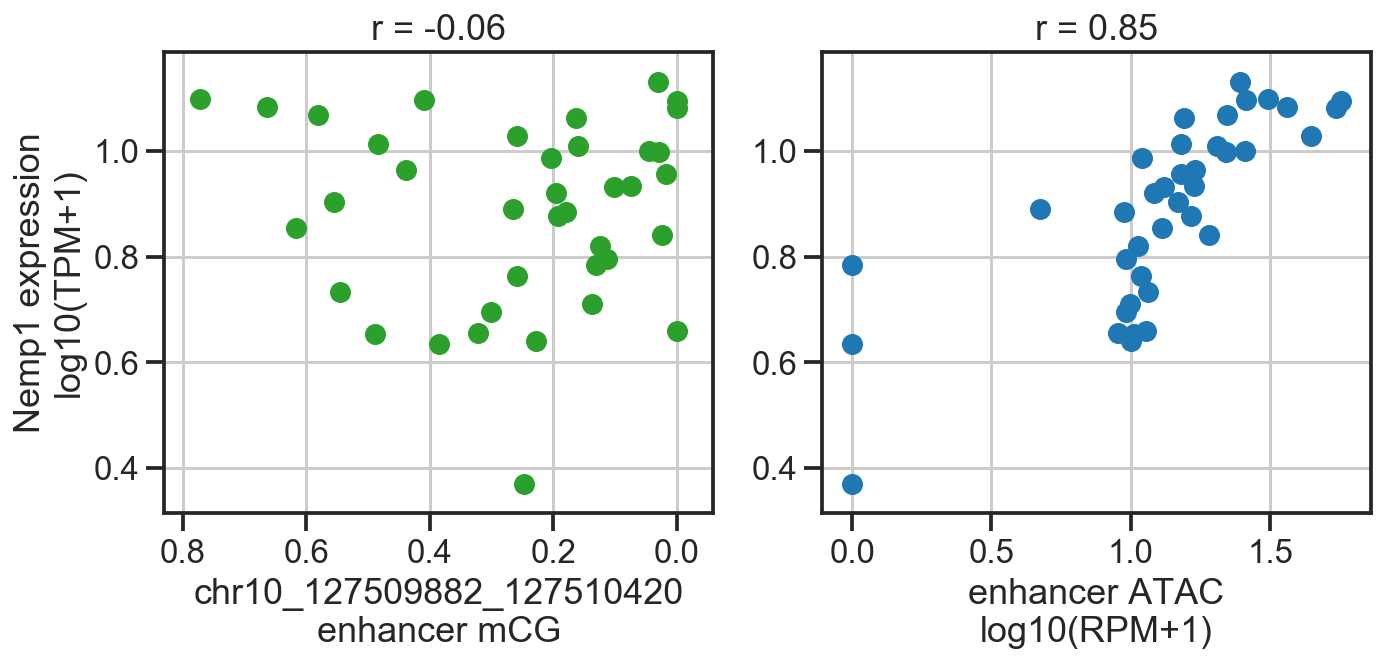

In [173]:
gene = 'ENSMUSG00000040195'
enh = 30489

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

Stim2 chr5_53942280_53943483
['2-1-1', '2-2-1', '2-1-2', '4-2-3', '2-3-3', '2-3-1', '4-1-1', '1-2-2', '3-1-2', '3-3-1', '1-2-1', '4-2-1', '9-1-1', '1-1-1', '4-2-2', '3-1-1', '3-2-1', '8-1-1', '7-2-2', '7-1-2', '2-3-2', '6-1-1', '7-2-1', '5-2-2', '9-2-1', '6-1-2', '8-2-1', '7-1-1', '5-3-1', '5-3-2', '6-3', '6-5', '5-1-2', '5-1-1', '6-4-2', '6-2-1', '5-2-1', '6-4-1']


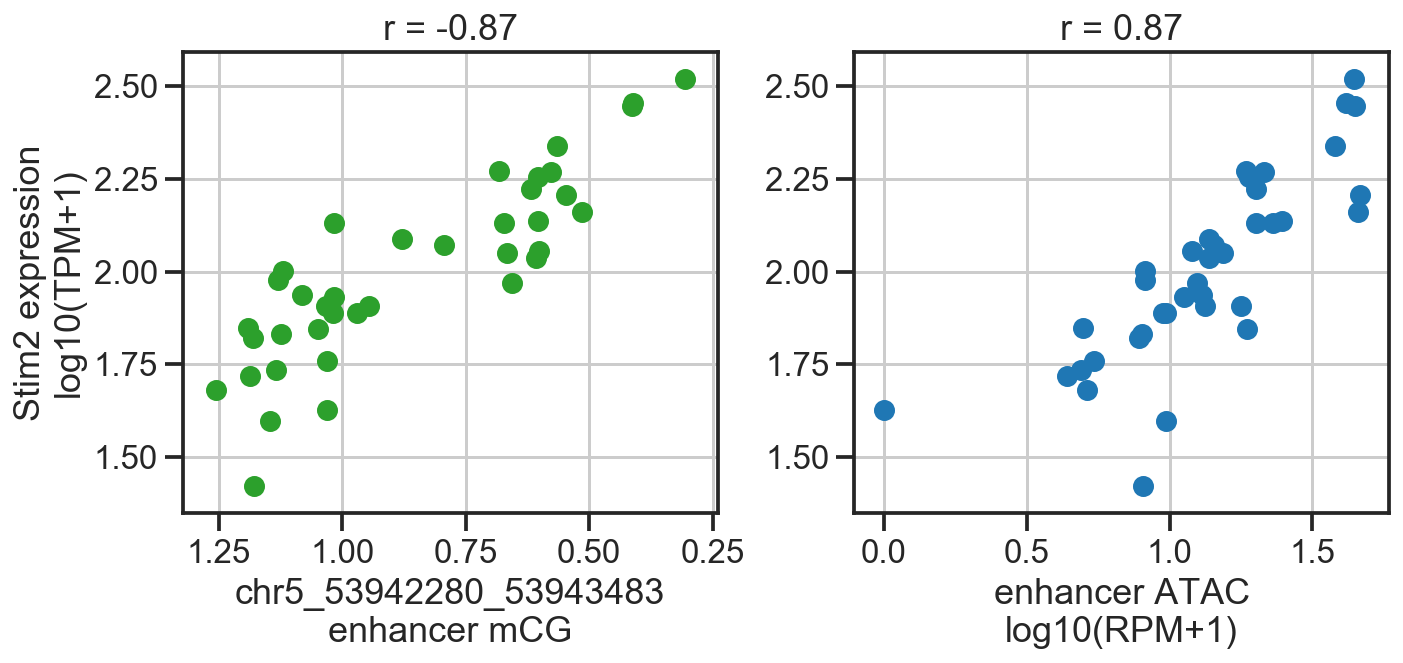

In [174]:
gene = 'ENSMUSG00000039156'
enh = 171584

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

Stim2 chr5_53941798_53942254
['2-1-1', '2-1-2', '2-2-1', '2-3-1', '4-2-1', '1-2-2', '4-2-2', '4-2-3', '8-1-1', '3-1-2', '9-1-1', '4-1-1', '1-1-1', '1-2-1', '7-1-1', '7-2-2', '3-1-1', '2-3-3', '5-3-2', '3-2-1', '6-4-2', '6-3', '6-1-2', '2-3-2', '7-1-2', '9-2-1', '3-3-1', '6-2-1', '6-1-1', '7-2-1', '5-1-2', '5-3-1', '5-1-1', '6-5', '5-2-1', '5-2-2', '6-4-1', '8-2-1']


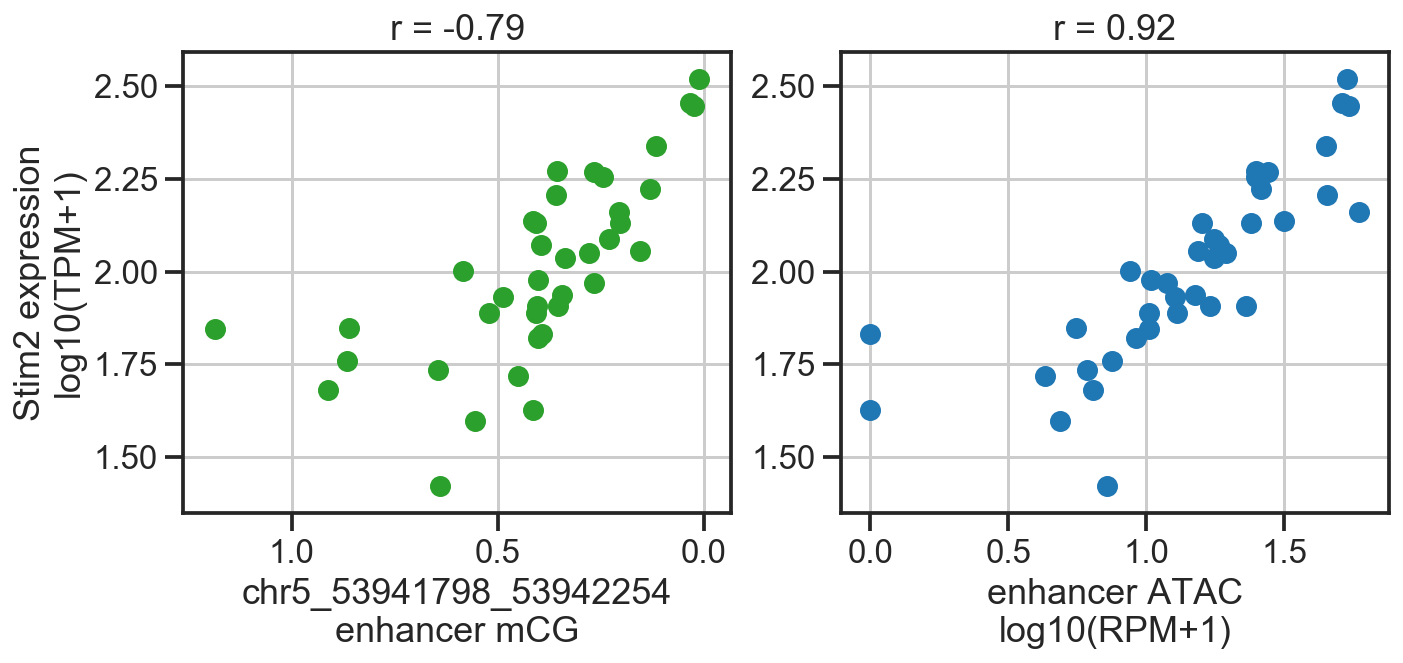

In [175]:
gene = 'ENSMUSG00000039156'
enh = 171583

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

Gpr176 chr2_117388097_117388832
['9-2-1', '4-2-2', '1-2-2', '1-1-1', '1-2-1', '2-3-2', '4-1-1', '3-1-1', '4-2-1', '2-1-1', '3-2-1', '9-1-1', '2-2-1', '3-1-2', '2-1-2', '8-2-1', '2-3-1', '8-1-1', '7-1-1', '2-3-3', '3-3-1', '4-2-3', '7-1-2', '7-2-2', '5-2-2', '5-3-2', '7-2-1', '6-1-1', '5-1-2', '5-2-1', '5-3-1', '5-1-1', '6-4-1', '6-3', '6-4-2', '6-5', '6-1-2', '6-2-1']


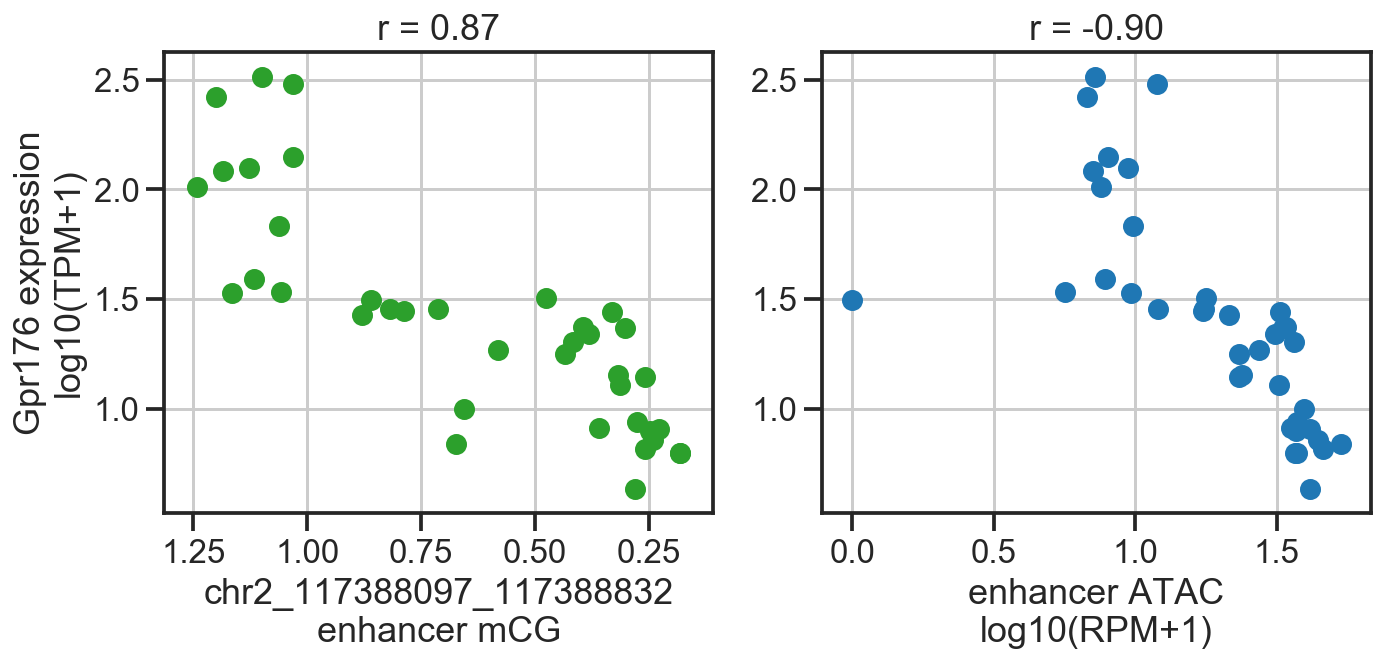

In [176]:
gene = 'ENSMUSG00000040133'
enh =  131993

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

Khdrbs3 chr15_69032853_69033398
['2-1-1', '2-3-1', '9-1-1', '2-3-3', '2-1-2', '2-2-1', '2-3-2', '3-1-2', '3-2-1', '8-1-1', '9-2-1', '8-2-1', '3-1-1', '6-4-1', '1-2-1', '1-2-2', '4-2-3', '5-2-2', '6-2-1', '6-4-2', '4-1-1', '1-1-1', '3-3-1', '4-2-2', '7-1-2', '4-2-1', '5-2-1', '7-1-1', '7-2-2', '5-1-2', '7-2-1', '6-1-2', '6-3', '6-5', '6-1-1', '5-3-2', '5-1-1', '5-3-1']


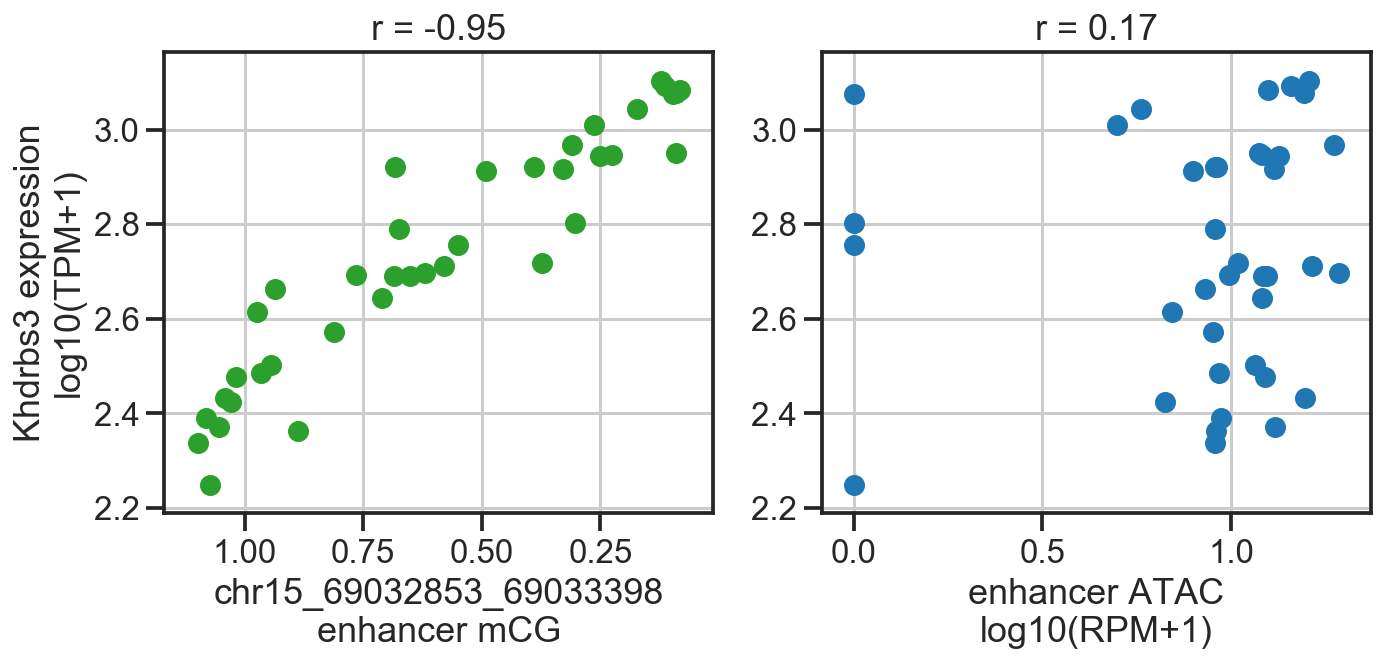

In [177]:
gene = 'ENSMUSG00000022332'
enh = 83016

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

Khdrbs3 chr15_69032853_69033398
['2-1-1', '2-3-1', '9-1-1', '2-3-3', '2-1-2', '2-2-1', '2-3-2', '3-1-2', '3-2-1', '8-1-1', '9-2-1', '8-2-1', '3-1-1', '6-4-1', '1-2-1', '1-2-2', '4-2-3', '5-2-2', '6-2-1', '6-4-2', '4-1-1', '1-1-1', '3-3-1', '4-2-2', '7-1-2', '4-2-1', '5-2-1', '7-1-1', '7-2-2', '5-1-2', '7-2-1', '6-1-2', '6-3', '6-5', '6-1-1', '5-3-2', '5-1-1', '5-3-1']


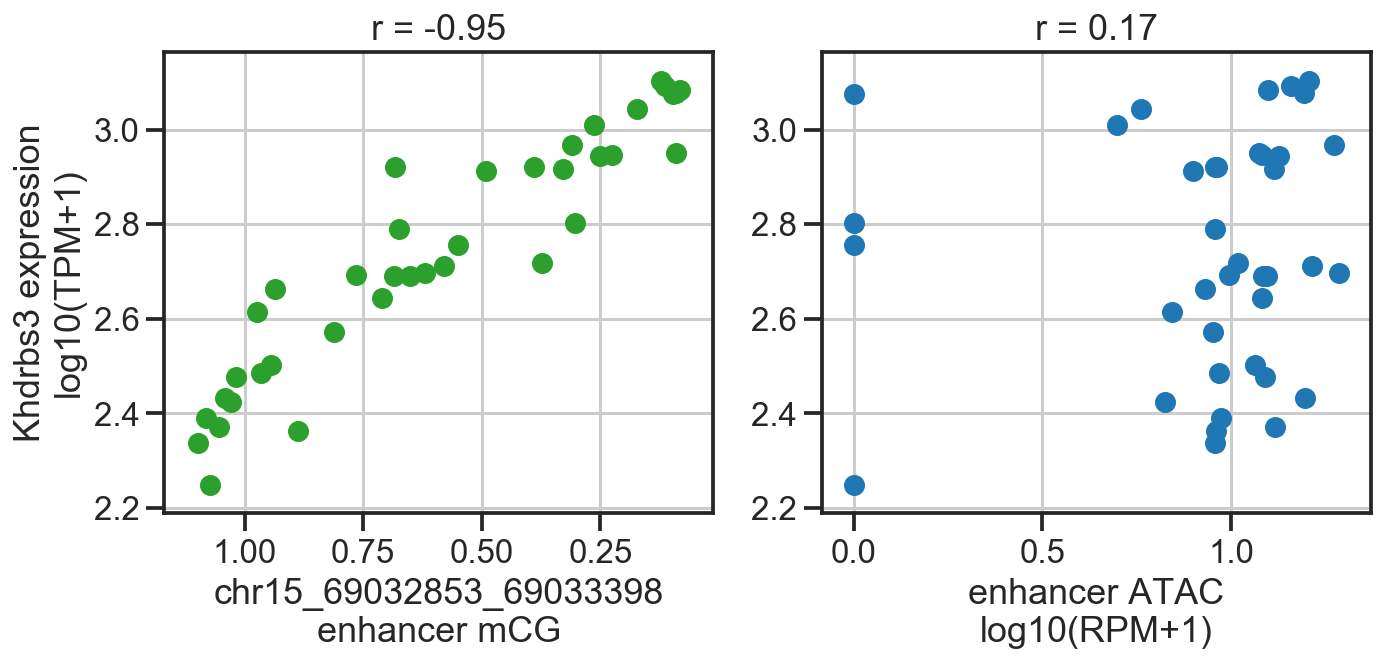

In [178]:
gene = 'ENSMUSG00000022332'
enh = 83016

gene_name = gid_to_name.loc[gene]
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
print(gene_name, enh_name)
scatter_gene_enh_example(gene, gene_name, enh, enh_name, output='scatter_{}_{}'.format(gene, enh_name))

## example for every cell type 

ENSMUSG00000039156 171584
Stim2 chr5_53942280_53943483
['2-1-1', '2-2-1', '2-1-2', '4-2-3', '2-3-3', '2-3-1', '4-1-1', '1-2-2', '3-1-2', '3-3-1', '1-2-1', '4-2-1', '9-1-1', '1-1-1', '4-2-2', '3-1-1', '3-2-1', '8-1-1', '7-2-2', '7-1-2', '2-3-2', '6-1-1', '7-2-1', '5-2-2', '9-2-1', '6-1-2', '8-2-1', '7-1-1', '5-3-1', '5-3-2', '6-3', '6-5', '5-1-2', '5-1-1', '6-4-2', '6-2-1', '5-2-1', '6-4-1']


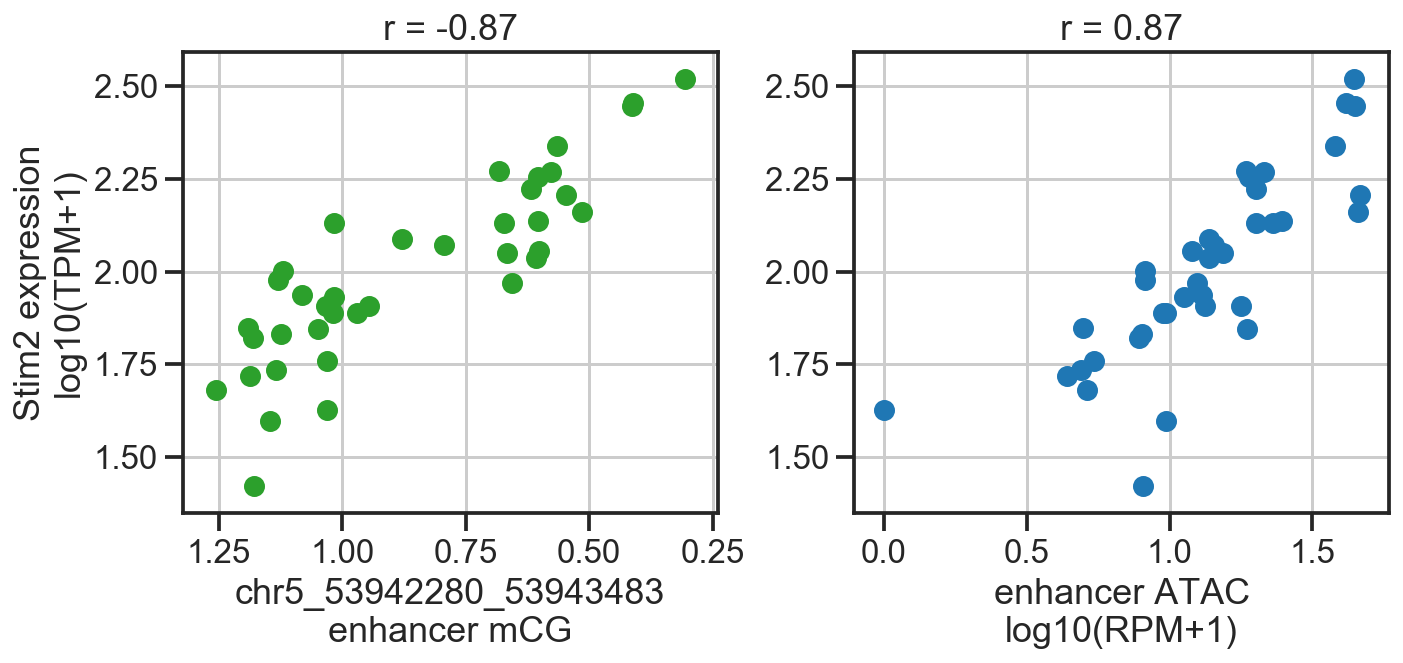

ENSMUSG00000039706 170709
Ldb2 chr5_44795308_44796375
['9-2-1', '9-1-1', '7-2-1', '7-2-2', '2-3-1', '2-3-2', '2-3-3', '7-1-2', '3-1-1', '7-1-1', '1-2-2', '8-2-1', '4-2-1', '3-1-2', '4-2-2', '4-1-1', '3-2-1', '2-1-2', '2-2-1', '3-3-1', '2-1-1', '1-2-1', '1-1-1', '8-1-1', '4-2-3', '5-2-2', '6-4-2', '6-4-1', '6-1-2', '6-3', '5-1-2', '6-1-1', '5-3-1', '5-2-1', '5-1-1', '6-5', '6-2-1', '5-3-2']


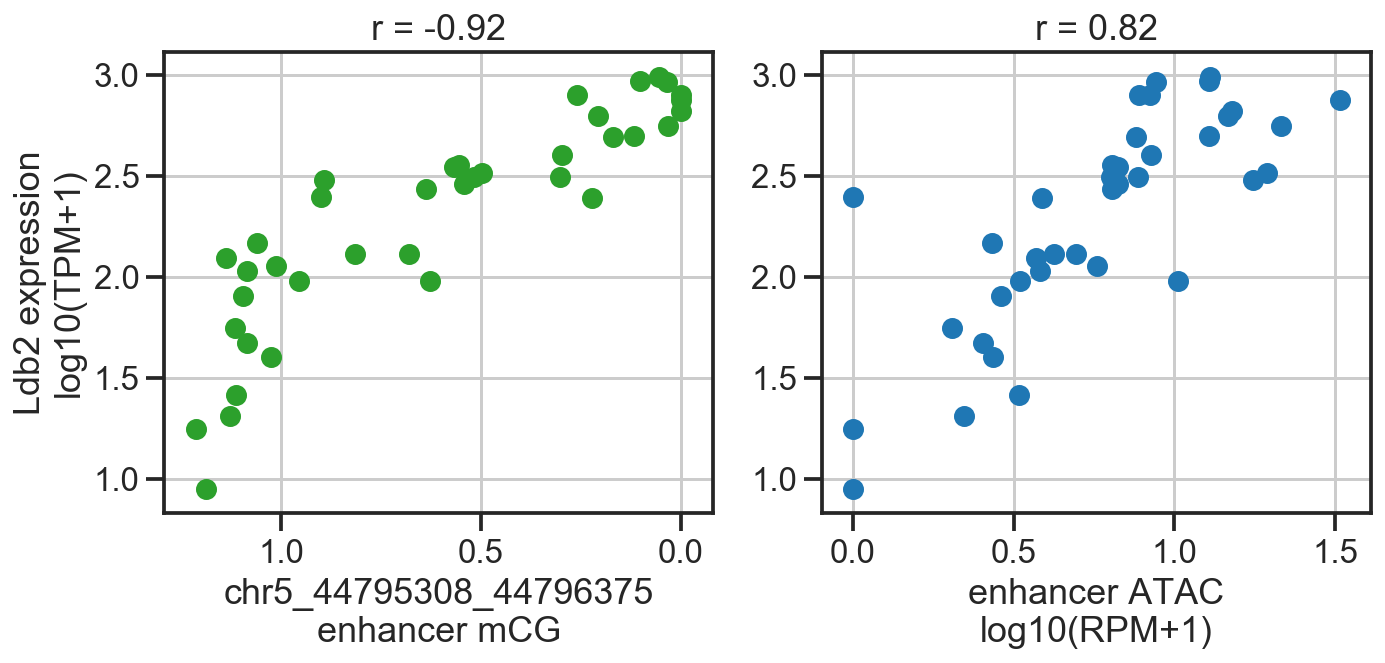

ENSMUSG00000008489 160142
Elavl2 chr4_91362228_91363375
['5-1-2', '5-1-1', '5-2-2', '6-5', '5-2-1', '5-3-1', '5-3-2', '2-3-2', '8-2-1', '6-4-2', '2-3-1', '9-1-1', '2-3-3', '9-2-1', '6-2-1', '6-4-1', '1-2-1', '3-1-2', '3-2-1', '1-1-1', '6-3', '8-1-1', '2-1-2', '1-2-2', '6-1-2', '7-1-2', '7-2-1', '2-1-1', '3-3-1', '7-2-2', '3-1-1', '7-1-1', '6-1-1', '2-2-1', '4-1-1', '4-2-3', '4-2-2', '4-2-1']


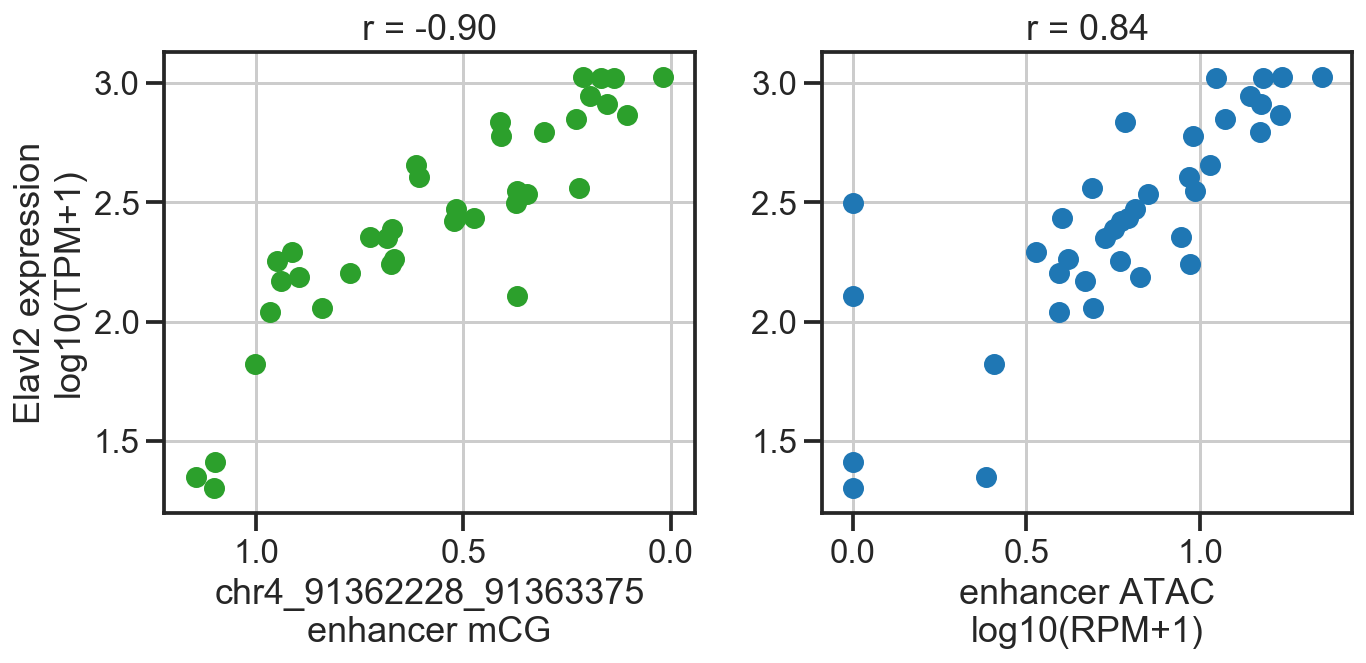

ENSMUSG00000038256 146496
Bcl9 chr3_97295335_97295698
['6-4-2', '5-3-1', '6-4-1', '5-2-1', '5-2-2', '6-3', '6-1-2', '5-3-2', '6-5', '6-2-1', '4-2-3', '5-1-2', '6-1-1', '5-1-1', '4-2-1', '4-2-2', '4-1-1', '8-1-1', '3-3-1', '9-2-1', '3-1-1', '2-3-3', '3-1-2', '2-1-1', '1-1-1', '2-1-2', '1-2-2', '2-3-2', '2-3-1', '1-2-1', '2-2-1', '3-2-1', '9-1-1', '7-1-2', '7-1-1', '8-2-1', '7-2-1', '7-2-2']


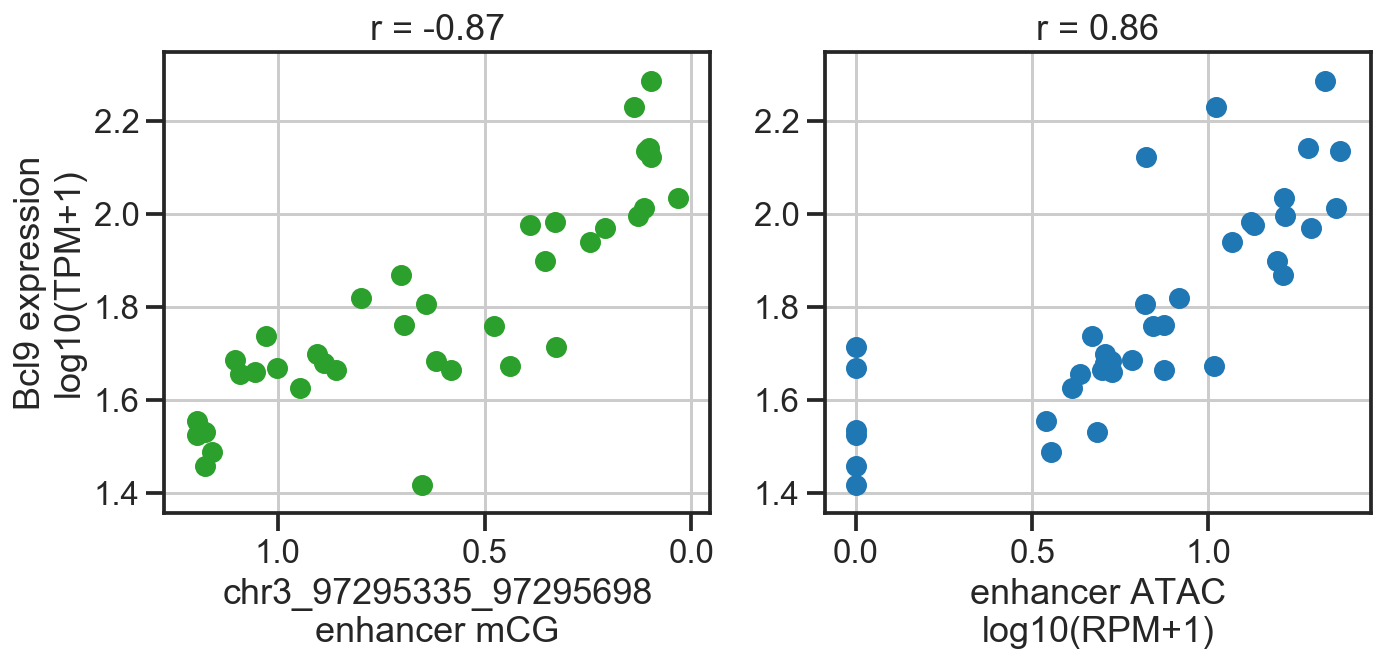

ENSMUSG00000058975 196262
Kcnc1 chr7_46405078_46406870
['6-1-2', '5-1-2', '5-1-1', '6-2-1', '6-1-1', '5-2-1', '6-3', '6-4-2', '6-5', '5-3-1', '3-3-1', '5-2-2', '6-4-1', '5-3-2', '3-1-1', '4-2-1', '8-1-1', '7-2-2', '4-2-2', '2-3-2', '4-1-1', '3-1-2', '7-1-2', '1-1-1', '2-2-1', '2-3-1', '2-1-1', '7-1-1', '2-1-2', '3-2-1', '8-2-1', '7-2-1', '1-2-1', '1-2-2', '4-2-3', '2-3-3', '9-1-1', '9-2-1']


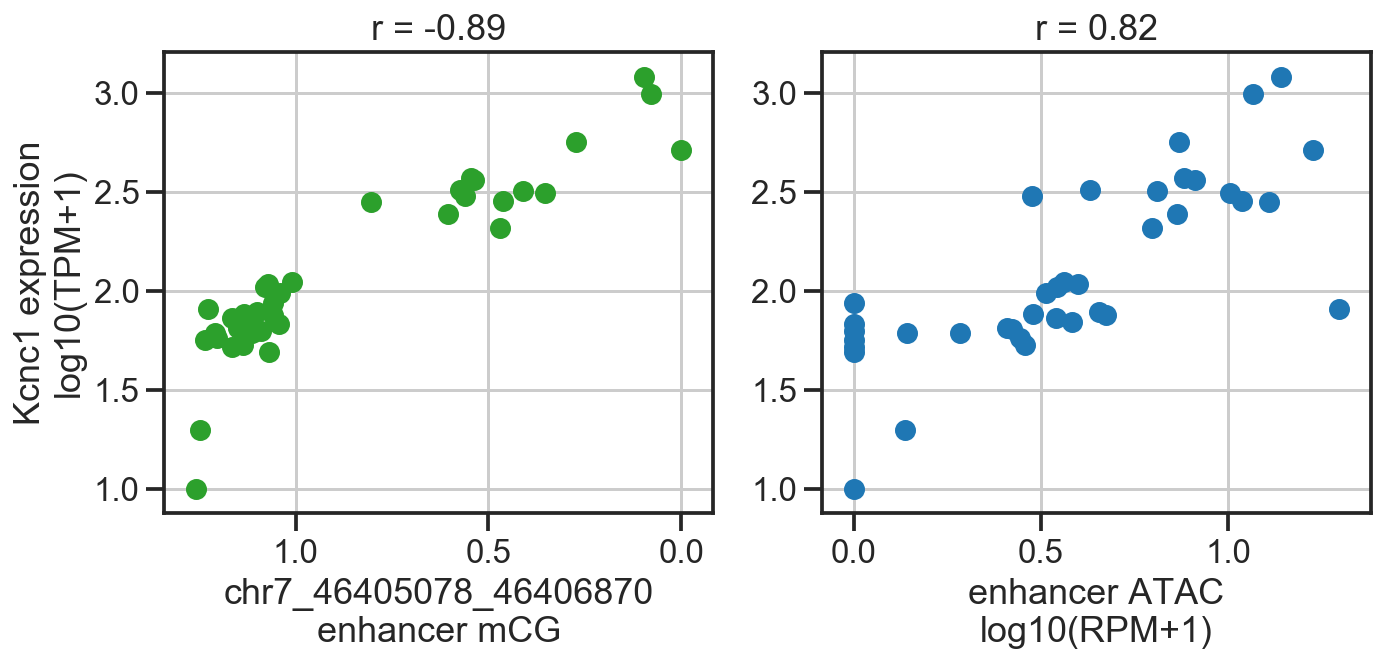

ENSMUSG00000029778 185868
Adcyap1r1 chr6_55454641_55455031
['5-1-2', '3-3-1', '6-3', '5-3-1', '6-5', '6-1-2', '5-1-1', '6-4-1', '6-2-1', '6-4-2', '5-3-2', '7-2-2', '7-2-1', '5-2-2', '5-2-1', '3-1-1', '7-1-2', '8-2-1', '6-1-1', '3-1-2', '3-2-1', '8-1-1', '2-3-2', '4-1-1', '4-2-2', '4-2-3', '4-2-1', '7-1-1', '1-1-1', '1-2-2', '2-2-1', '1-2-1', '2-1-2', '2-3-1', '2-1-1', '2-3-3', '9-1-1', '9-2-1']


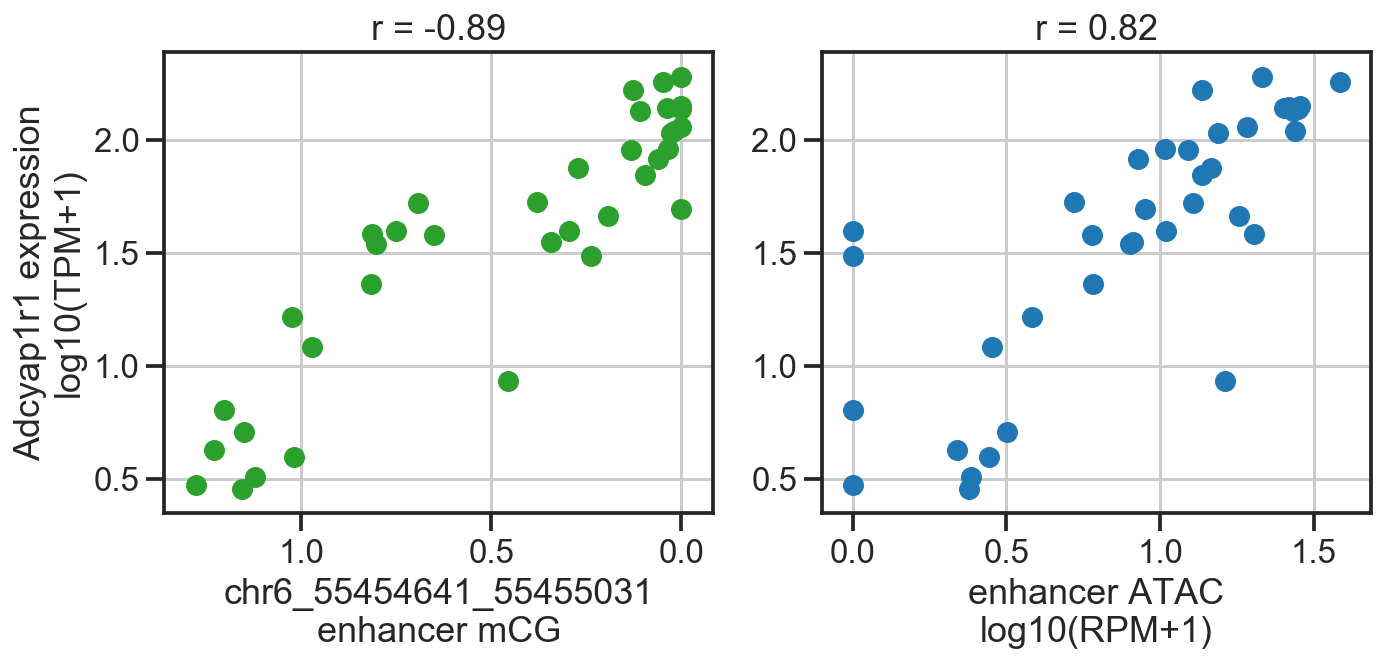

ENSMUSG00000062078 97738
Qk chr17_10313652_10314818
['6-2-1', '6-4-1', '6-5', '6-4-2', '5-1-1', '5-1-2', '5-3-1', '5-2-2', '5-3-2', '5-2-1', '6-3', '6-1-1', '7-2-1', '2-2-1', '2-1-1', '6-1-2', '2-3-3', '3-3-1', '7-1-2', '7-2-2', '2-1-2', '7-1-1', '2-3-2', '3-1-1', '9-1-1', '3-2-1', '2-3-1', '3-1-2', '4-2-2', '4-2-3', '4-2-1', '1-2-2', '4-1-1', '1-1-1', '9-2-1', '8-2-1', '1-2-1', '8-1-1']


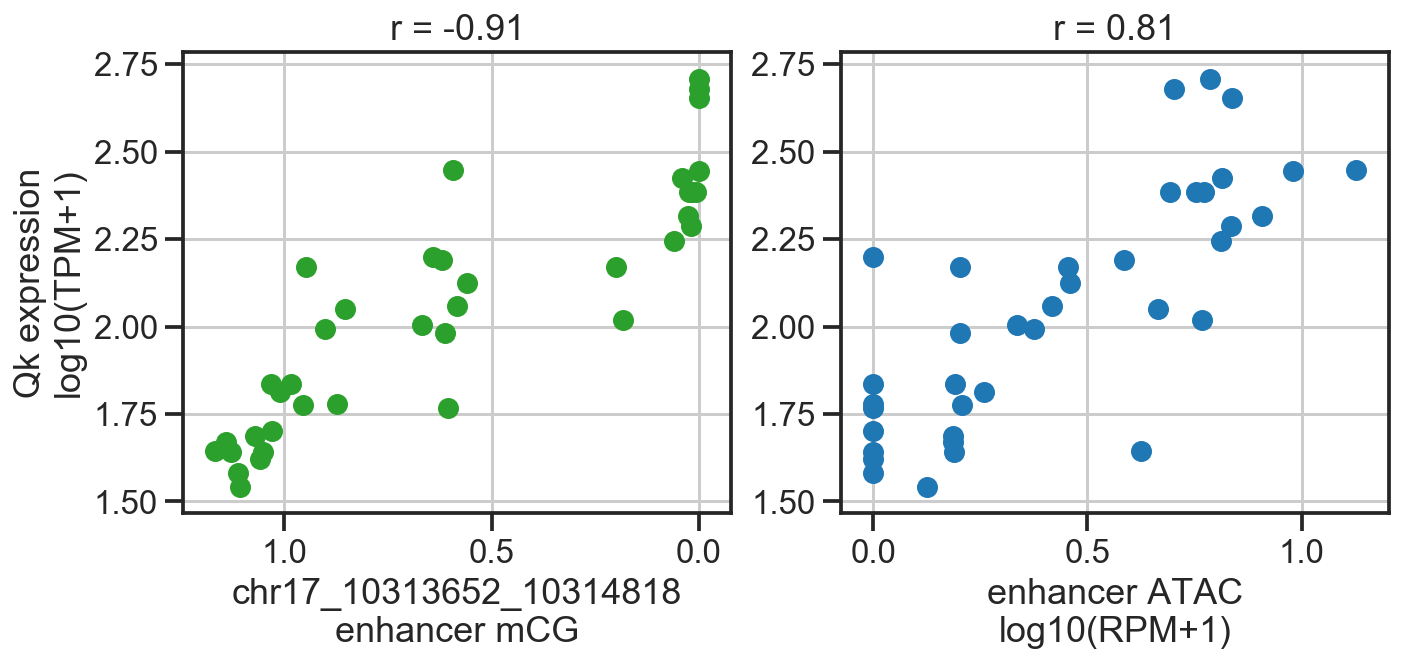

ENSMUSG00000039156 171583
Stim2 chr5_53941798_53942254
['2-1-1', '2-1-2', '2-2-1', '2-3-1', '4-2-1', '1-2-2', '4-2-2', '4-2-3', '8-1-1', '3-1-2', '9-1-1', '4-1-1', '1-1-1', '1-2-1', '7-1-1', '7-2-2', '3-1-1', '2-3-3', '5-3-2', '3-2-1', '6-4-2', '6-3', '6-1-2', '2-3-2', '7-1-2', '9-2-1', '3-3-1', '6-2-1', '6-1-1', '7-2-1', '5-1-2', '5-3-1', '5-1-1', '6-5', '5-2-1', '5-2-2', '6-4-1', '8-2-1']


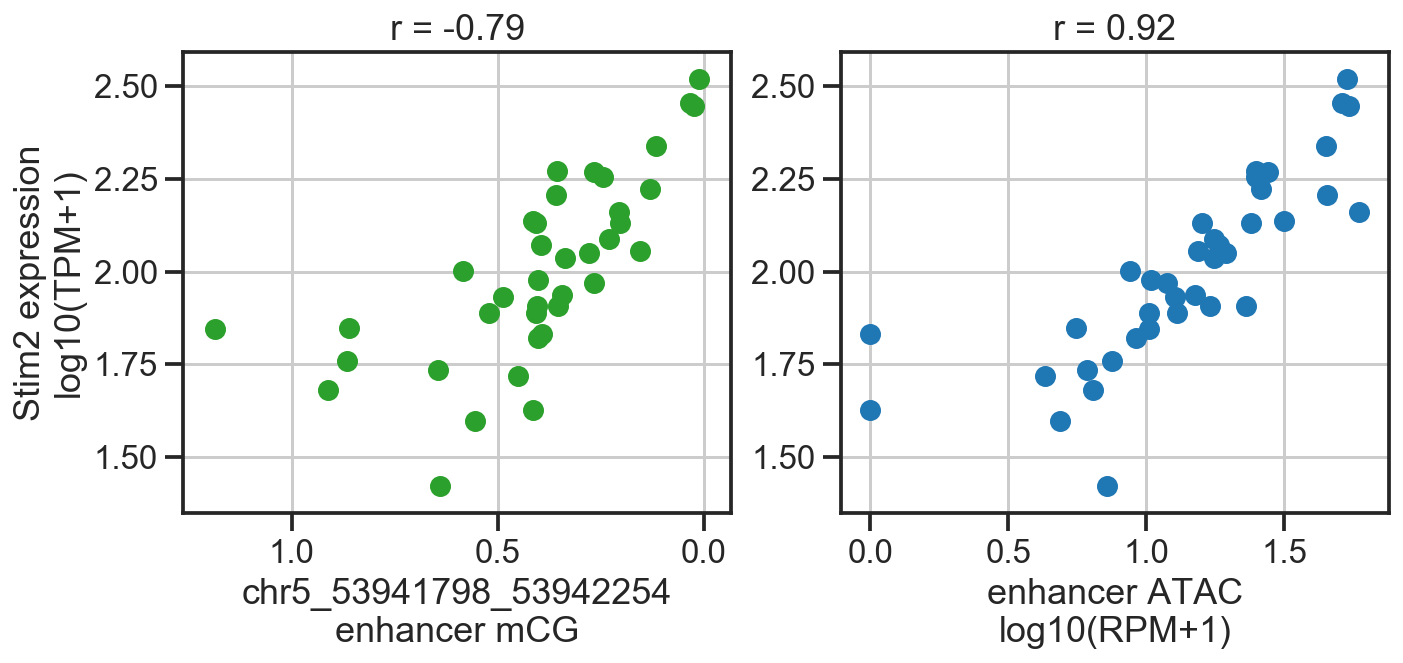

ENSMUSG00000049907 173240
Rasl11b chr5_74252560_74253006
['2-3-1', '2-1-1', '1-1-1', '1-2-1', '2-1-2', '3-3-1', '4-1-1', '1-2-2', '9-1-1', '3-2-1', '2-2-1', '3-1-2', '3-1-1', '9-2-1', '4-2-2', '4-2-1', '2-3-2', '8-1-1', '6-1-2', '2-3-3', '4-2-3', '8-2-1', '7-1-1', '7-1-2', '7-2-1', '5-1-2', '5-2-2', '6-4-1', '6-5', '5-1-1', '7-2-2', '5-3-1', '6-1-1', '6-3', '5-3-2', '5-2-1', '6-4-2', '6-2-1']


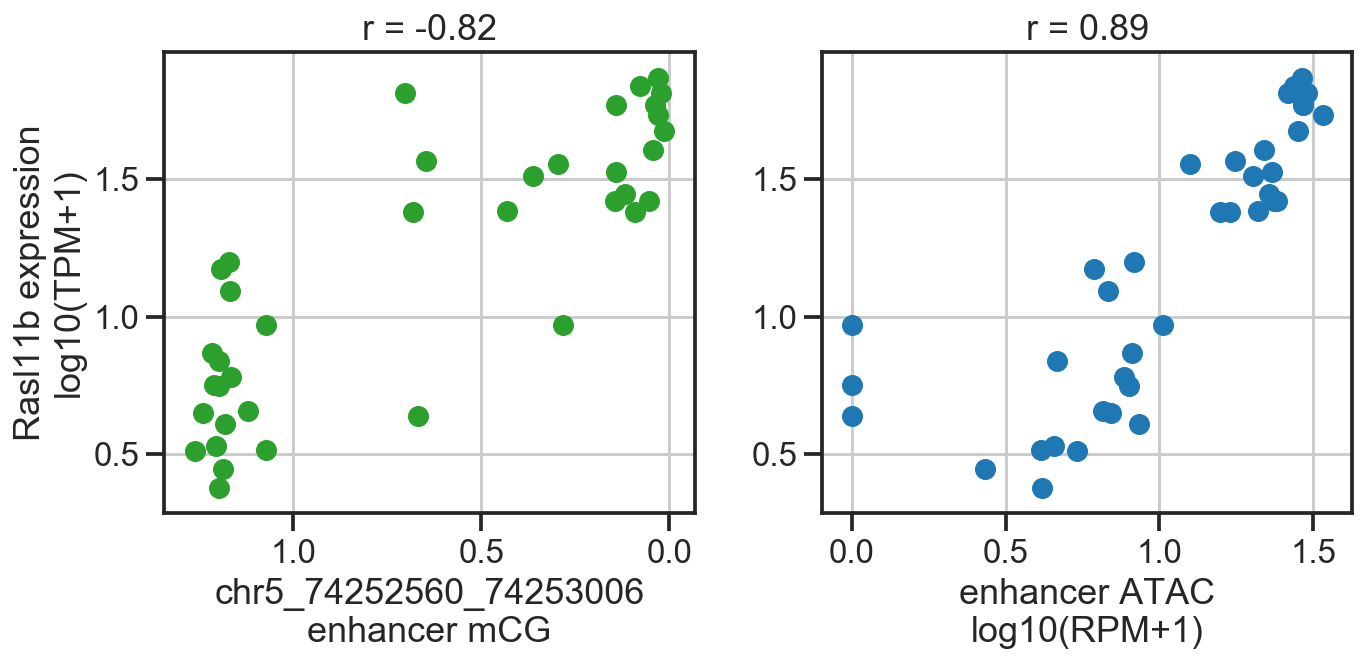

ENSMUSG00000028161 150013
Ppp3ca chr3_135972577_135973294
['4-2-2', '2-1-1', '4-2-1', '4-1-1', '2-1-2', '4-2-3', '2-2-1', '3-1-1', '2-3-1', '3-1-2', '3-2-1', '1-1-1', '1-2-1', '9-1-1', '1-2-2', '8-2-1', '2-3-3', '6-1-2', '3-3-1', '8-1-1', '2-3-2', '9-2-1', '7-1-1', '6-1-1', '5-2-2', '5-1-2', '6-4-1', '6-3', '7-1-2', '5-3-1', '5-2-1', '7-2-1', '7-2-2', '6-4-2', '6-5', '5-3-2', '5-1-1', '6-2-1']


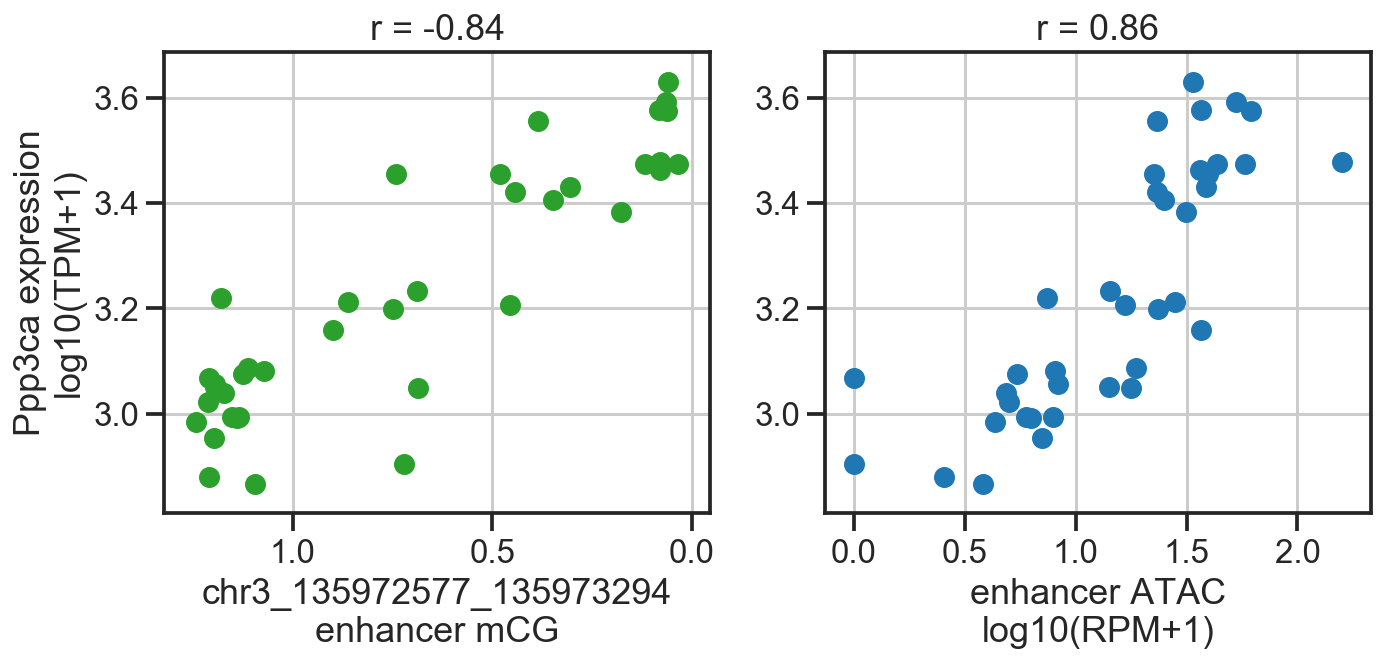

In [179]:
for idx, row in to_evals.sort_values('val_both').head(10).iterrows():
    gene = row['gene']
    enh = row['ens']
    print(gene, enh)
    
    gene_name = gid_to_name.loc[gene]
    enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())
    output = 'scatter_{}_{}'.format(gene, enh_name)
    print(gene_name, enh_name)
    scatter_gene_enh_example(gene, gene_name, enh, enh_name, output=output)
    

### Compare with nearest gene 

In [180]:
print(top_sig.shape)
top_sig.head()

(11343, 27)


gene     ens  in_gene       val      val2  \
0  ENSMUSG00000049556  221845     True -0.963891  0.656855   
1  ENSMUSG00000049556  221868     True -0.962140  0.710909   
2  ENSMUSG00000022332   83016     True -0.952730  0.168837   
3  ENSMUSG00000049556  221849     True -0.951198  0.431666   
4  ENSMUSG00000022332   83063     True -0.948134  0.636503   

   val_clustershuffled  val2_clustershuffled    dist       pvalues  fdr<100kb  \
0            -0.085458              0.323121  172329  0.000000e+00    0.00000   
1            -0.183280              0.130321  115681  0.000000e+00    0.00000   
2             0.135792             -0.122661  104705  0.000000e+00    0.00000   
3            -0.066637              0.010614  169279  0.000000e+00    0.00000   
4             0.077580              0.111719  159432  5.843406e-08    0.00455   

   ...  fdr2<100kb shuffled (cluster label)  gene_name   index    chr  \
0  ...                           429.207247     Lingo1  221845   chr9   
1  ...                           136.727057     Lingo1  221868   chr9   
2  ...                             1.647945    Khdrbs3   83016  chr15   
3  ...                            15.512834     Lingo1  221849   chr9   
4  ...                           365.485811    Khdrbs3   83063  chr15   

      start       end  clsts  length chrom    center  
0  56623683  56624596    NaN     913     9  56624139  
1  56680091  56681484    NaN    1393     9  56680787  
2  69032853  69033398    NaN     545    15  69033125  
3  56626636  56627742    NaN    1106     9  56627189  
4  69087116  69088589    NaN    1473    15  69087852  

[5 rows x 27 columns]

In [181]:
regions_info.head()

chr    start      end         transcript_id    transcript_name  \
0  chr1  3083769  3083816  ENSMUST00000193812.1  4933401J01Rik-201   
1  chr1  3112234  3112467  ENSMUST00000082908.1        Gm26206-201   
2  chr1  3112770  3112986  ENSMUST00000082908.1        Gm26206-201   
3  chr1  3113717  3114035  ENSMUST00000082908.1        Gm26206-201   
4  chr1  3118790  3118935  ENSMUST00000082908.1        Gm26206-201   

                gene_id      gene_name  distance  clsts  length  index chrom  
0  ENSMUSG00000102693.1  4933401J01Rik     10516    NaN      47      0     1  
1  ENSMUSG00000064842.1        Gm26206     10218    NaN     233      1     1  
2  ENSMUSG00000064842.1        Gm26206     10754    NaN     216      2     1  
3  ENSMUSG00000064842.1        Gm26206     11701    NaN     318      3     1  
4  ENSMUSG00000064842.1        Gm26206     16774    NaN     145      4     1

In [182]:
top_sig.head()

gene     ens  in_gene       val      val2  \
0  ENSMUSG00000049556  221845     True -0.963891  0.656855   
1  ENSMUSG00000049556  221868     True -0.962140  0.710909   
2  ENSMUSG00000022332   83016     True -0.952730  0.168837   
3  ENSMUSG00000049556  221849     True -0.951198  0.431666   
4  ENSMUSG00000022332   83063     True -0.948134  0.636503   

   val_clustershuffled  val2_clustershuffled    dist       pvalues  fdr<100kb  \
0            -0.085458              0.323121  172329  0.000000e+00    0.00000   
1            -0.183280              0.130321  115681  0.000000e+00    0.00000   
2             0.135792             -0.122661  104705  0.000000e+00    0.00000   
3            -0.066637              0.010614  169279  0.000000e+00    0.00000   
4             0.077580              0.111719  159432  5.843406e-08    0.00455   

   ...  fdr2<100kb shuffled (cluster label)  gene_name   index    chr  \
0  ...                           429.207247     Lingo1  221845   chr9   
1  ...                           136.727057     Lingo1  221868   chr9   
2  ...                             1.647945    Khdrbs3   83016  chr15   
3  ...                            15.512834     Lingo1  221849   chr9   
4  ...                           365.485811    Khdrbs3   83063  chr15   

      start       end  clsts  length chrom    center  
0  56623683  56624596    NaN     913     9  56624139  
1  56680091  56681484    NaN    1393     9  56680787  
2  69032853  69033398    NaN     545    15  69033125  
3  56626636  56627742    NaN    1106     9  56627189  
4  69087116  69088589    NaN    1473    15  69087852  

[5 rows x 27 columns]

In [183]:
def match_gene(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

In [185]:
# get nn gene information
top_sig['nearest_gene'] = (regions_info.set_index('index')
                                       .reindex(top_sig['ens'].values)
                                       ['gene_id']
                                       .apply(match_gene)
                                       .values
                          )

n_nngenes = (top_sig['gene'] == top_sig['nearest_gene']).sum()
print("{}/{}={:.2f} pairs are from the nearest genes, {} non-trivial pairs"
      .format(n_nngenes, n_pair, n_nngenes/n_pair, n_pair-n_nngenes))
    
nontr_top_sig = top_sig.loc[(top_sig['gene'] != top_sig['nearest_gene'])].sort_values('dist', ascending=False)
print(nontr_top_sig.shape)
nontr_top_sig.head()

2545/11343=0.22 pairs are from the nearest genes, 8798 non-trivial pairs
(8798, 28)


gene     ens  in_gene       val      val2  \
3152  ENSMUSG00000035735  115700    False -0.799978  0.539993   
2788  ENSMUSG00000020923   40378    False -0.806981  0.195754   
119   ENSMUSG00000106515  151586    False -0.846373  0.208666   
2057  ENSMUSG00000049907  173299    False -0.820987  0.613306   
1043  ENSMUSG00000049907  173297    False -0.848561  0.636065   

      val_clustershuffled  val2_clustershuffled    dist   pvalues  fdr<100kb  \
3152             0.011489              0.207572  498956  0.000512   0.060407   
2788            -0.070577             -0.091148  498506  0.000404   0.053684   
119             -0.156582              0.018711  496862  0.000080   0.025259   
2057             0.048474              0.141919  496837  0.000244   0.042826   
1043             0.012802              0.160740  496033  0.000070   0.023629   

      ...  gene_name   index    chr      start        end  clsts  length  \
3152  ...      Dagla  115700  chr19   10803643   10804024    NaN     381   
2788  ...       Ubtf   40378  chr11  101820952  101821521    NaN     569   
119   ...    Gm30382  151586   chr3  148947820  148949059    NaN    1239   
2057  ...    Rasl11b  173299   chr5   74691880   74692366    NaN     486   
1043  ...    Rasl11b  173297   chr5   74691115   74691523    NaN     408   

      chrom     center        nearest_gene  
3152     19   10803833                      
2788     11  101821236                      
119       3  148948439  ENSMUSG00000028184  
2057      5   74692123  ENSMUSG00000029228  
1043      5   74691319  ENSMUSG00000029228  

[5 rows x 28 columns]

In [186]:
top_sig.columns

Index(['gene', 'ens', 'in_gene', 'val', 'val2', 'val_clustershuffled',
       'val2_clustershuffled', 'dist', 'pvalues', 'fdr<100kb', 'fdr<200kb',
       'fdr<500kb', 'fdr<100kb shuffled (cluster label)', 'pvalues2',
       'fdr2<100kb', 'fdr2<200kb', 'fdr2<500kb',
       'fdr2<100kb shuffled (cluster label)', 'gene_name', 'index', 'chr',
       'start', 'end', 'clsts', 'length', 'chrom', 'center', 'nearest_gene'],
      dtype='object')

In [188]:
# get nn gene information
top_sig2['nearest_gene'] = (regions_info.set_index('index')
                                       .reindex(top_sig2['ens'].values)
                                       ['gene_id']
                                       .apply(match_gene)
                                       .values
                          )

n_nngenes2 = (top_sig2['gene'] == top_sig2['nearest_gene']).sum()
print("{}/{}={:.2f} pairs are from the nearest genes, {} non-trivial pairs"
      .format(n_nngenes2, n_pair2, n_nngenes2/n_pair2, n_pair2-n_nngenes2))
    
nontr_top_sig2 = top_sig2.loc[(top_sig2['gene'] != top_sig2['nearest_gene'])].sort_values('dist', ascending=False)
print(nontr_top_sig2.shape)
nontr_top_sig2.head()

1153/4496=0.26 pairs are from the nearest genes, 3343 non-trivial pairs
(3343, 28)


gene     ens  in_gene       val      val2  \
208  ENSMUSG00000027601  139755    False -0.537367  0.811577   
99   ENSMUSG00000062078   97653    False -0.809607  0.827333   
289  ENSMUSG00000029580  180010    False -0.720976  0.799978   
293  ENSMUSG00000041975  127633    False -0.624467  0.799540   
189  ENSMUSG00000112663   45390    False -0.601707  0.813546   

     val_clustershuffled  val2_clustershuffled    dist   pvalues  fdr<100kb  \
208            -0.032717              0.135354  492149  0.037659   0.321876   
99             -0.179779              0.201226  489213  0.000366   0.051028   
289            -0.021775             -0.083270  486438  0.003640   0.137976   
293             0.005143             -0.048692  463089  0.015654   0.238404   
189            -0.115220              0.227268  445881  0.020162   0.260599   

     ...      gene_name   index    chr      start        end  clsts  length  \
208  ...          Mtfr1  139755   chr3   18695110   18695247    NaN     137   
99   ...             Qk   97653  chr17    9829735    9830562    NaN     827   
289  ...           Actb  180010   chr5  142419986  142420646    NaN     660   
293  ...         Mettl8  127633   chr2   70592378   70592611    NaN     233   
189  ...  C630031E19Rik   45390  chr12   29240254   29240874    NaN     620   

     chrom     center        nearest_gene  
208      3   18695178  ENSMUSG00000103264  
99      17    9830148                      
289      5  142420316  ENSMUSG00000056493  
293      2   70592494  ENSMUSG00000070880  
189     12   29240564                      

[5 rows x 28 columns]

### nearest genes vs CICERO? 

- significant genes
- nearest genes
- agreed with cicero

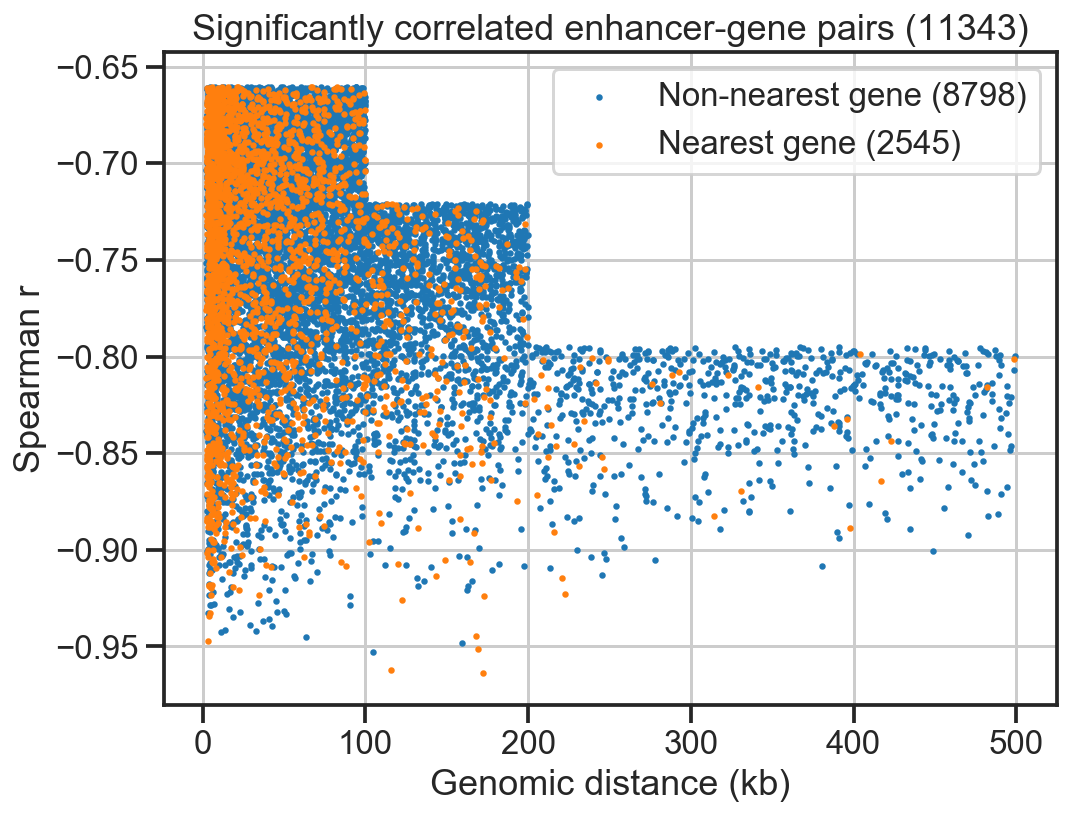

In [189]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

# plot sig 
_df = top_sig[top_sig['gene']!=top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C0',
    alpha=1,
    label='Non-nearest gene ({})'.format(n),
)

# explained by nearest genes
# plot sig 
_df = top_sig[top_sig['gene']==top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C1',
    alpha=1,
    label='Nearest gene ({})'.format(n),
)


ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()

(5794, 28)


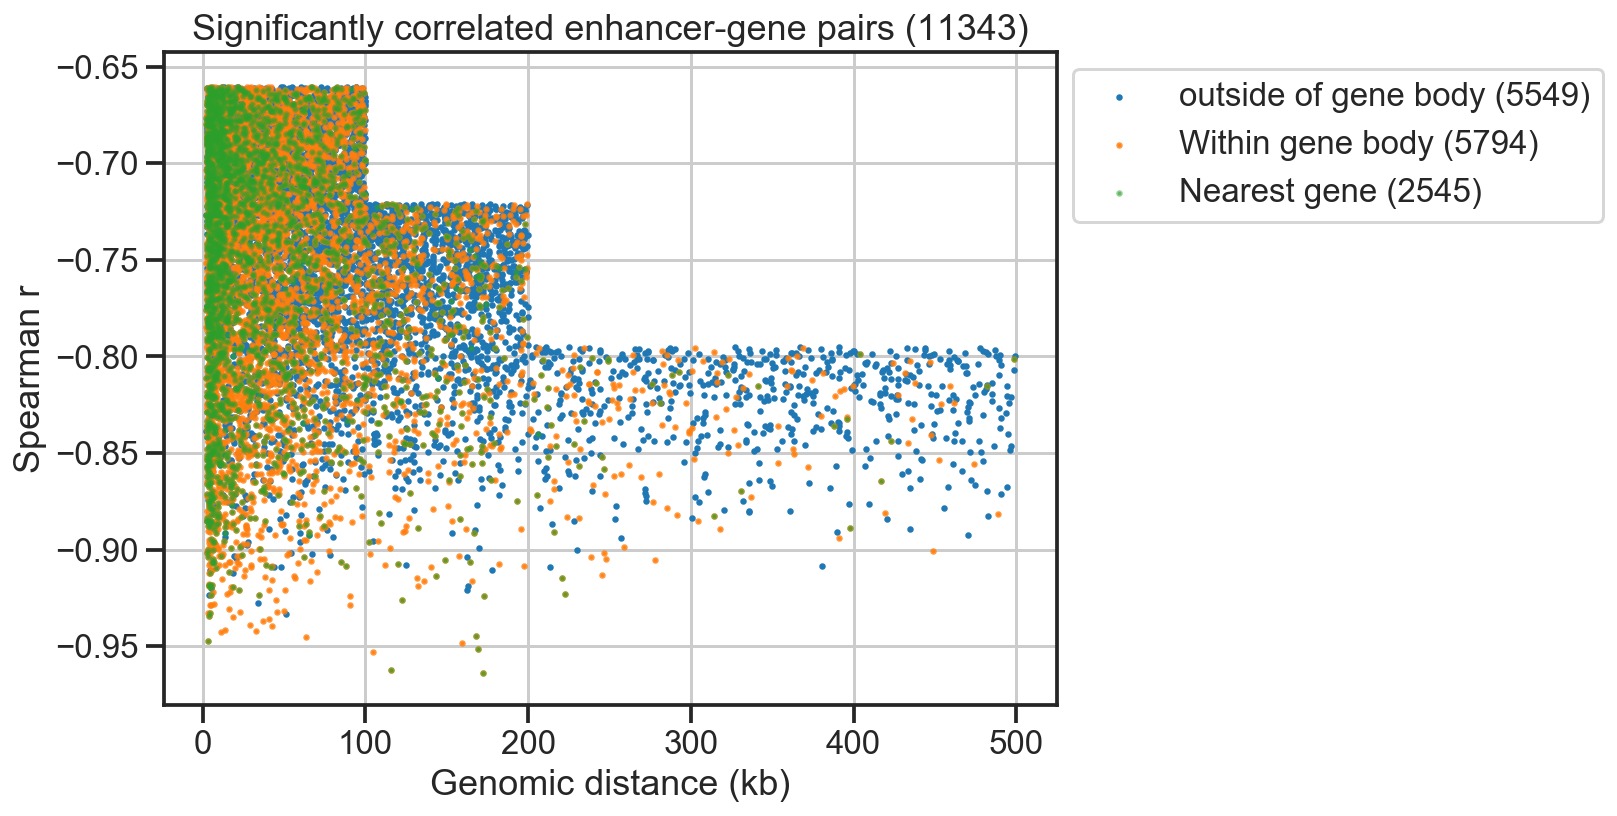

In [190]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

# plot sig 
_df = top_sig[~top_sig['in_gene'].values] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C0',
    alpha=1,
    label='outside of gene body ({})'.format(n),
)

# explained by nearest genes
# plot sig 
_df = top_sig[top_sig['in_gene'].values] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C1',
    alpha=.8,
    label='Within gene body ({})'.format(n),
)
print(_df.shape)

_df = top_sig[top_sig['gene']==top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C2',
    alpha=.5,
    label='Nearest gene ({})'.format(n),
)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()

In [191]:
to_evals.head()

gene     ens  in_gene       val      val2  \
0  ENSMUSG00000000001  147520    False -0.416129  0.207791   
1  ENSMUSG00000000001  147522    False -0.048692 -0.142357   
2  ENSMUSG00000000001  147523    False -0.109531  0.267535   
3  ENSMUSG00000000001  147527    False -0.134916  0.096838   
4  ENSMUSG00000000001  147528    False -0.355291  0.098807   

   val_clustershuffled  val2_clustershuffled    dist   pvalues  fdr<100kb  \
0             0.071233             -0.002079  995118  0.090151   0.428458   
1             0.120473             -0.145858  985740  0.414462   0.719874   
2             0.027902             -0.259875  983725  0.346690   0.676042   
3             0.201007             -0.100120  970444  0.319497   0.657509   
4             0.248714             -0.124412  969372  0.127221   0.482321   

   fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  \
0   0.520486   0.669566                           32.735334  0.230154   
1   0.777051   0.859596                            1.183878  0.716560   
2   0.740894   0.834201                            1.570314  0.166588   
3   0.725010   0.823293                            1.817085  0.375447   
4   0.570199   0.709733                           14.019220  0.372630   

   fdr2<100kb  fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  \
0    0.605463    0.678469    0.795896                             2.014674   
1    0.871078    0.898293    0.937717                             0.868963   
2    0.549899    0.630306    0.760320                             2.956335   
3    0.704613    0.763367    0.854526                             1.237911   
4    0.702923    0.761896    0.853526                             1.245585   

   val_both  
0 -0.623919  
1  0.093665  
2 -0.377065  
3 -0.231754  
4 -0.454098

In [192]:
to_evals.shape

(1710144, 19)

In [193]:
13365/to_evals.shape[0] * 100

0.781513135735938

In [194]:
to_evals.in_gene.sum()

77336

In [195]:
5989/89681 *100

6.678114650817898

In [196]:
top_sig.head()

gene     ens  in_gene       val      val2  \
0  ENSMUSG00000049556  221845     True -0.963891  0.656855   
1  ENSMUSG00000049556  221868     True -0.962140  0.710909   
2  ENSMUSG00000022332   83016     True -0.952730  0.168837   
3  ENSMUSG00000049556  221849     True -0.951198  0.431666   
4  ENSMUSG00000022332   83063     True -0.948134  0.636503   

   val_clustershuffled  val2_clustershuffled    dist       pvalues  fdr<100kb  \
0            -0.085458              0.323121  172329  0.000000e+00    0.00000   
1            -0.183280              0.130321  115681  0.000000e+00    0.00000   
2             0.135792             -0.122661  104705  0.000000e+00    0.00000   
3            -0.066637              0.010614  169279  0.000000e+00    0.00000   
4             0.077580              0.111719  159432  5.843406e-08    0.00455   

   ...  gene_name   index    chr     start       end  clsts  length  chrom  \
0  ...     Lingo1  221845   chr9  56623683  56624596    NaN     913      9   
1  ...     Lingo1  221868   chr9  56680091  56681484    NaN    1393      9   
2  ...    Khdrbs3   83016  chr15  69032853  69033398    NaN     545     15   
3  ...     Lingo1  221849   chr9  56626636  56627742    NaN    1106      9   
4  ...    Khdrbs3   83063  chr15  69087116  69088589    NaN    1473     15   

     center        nearest_gene  
0  56624139  ENSMUSG00000049556  
1  56680787  ENSMUSG00000049556  
2  69033125                      
3  56627189  ENSMUSG00000049556  
4  69087852                      

[5 rows x 28 columns]

In [197]:
genes_list.head()

gid                gene_id gene_name    chr      start  \
0  ENSMUSG00000000001   ENSMUSG00000000001.4     Gnai3   chr3  108107280   
1  ENSMUSG00000000056   ENSMUSG00000000056.7      Narf  chr11  121237253   
2  ENSMUSG00000000058   ENSMUSG00000000058.6      Cav2   chr6   17281185   
3  ENSMUSG00000000078   ENSMUSG00000000078.7      Klf6  chr13    5861482   
4  ENSMUSG00000000085  ENSMUSG00000000085.16     Scmh1   chr4  120405281   

         end strand       gene_type chrom  length        tss  
0  108146146      -  protein_coding     3   38866  108146146  
1  121255856      +  protein_coding    11   18603  121237253  
2   17289115      +  protein_coding     6    7930   17281185  
3    5870394      +  protein_coding    13    8912    5861482  
4  120530186      +  protein_coding     4  124905  120405281

In [198]:
tmp = genes_list.set_index('gid')
tmp = tmp.loc[top_sig.gene]

Text(0.5, 1.0, 'Distribution of correlated gene length')

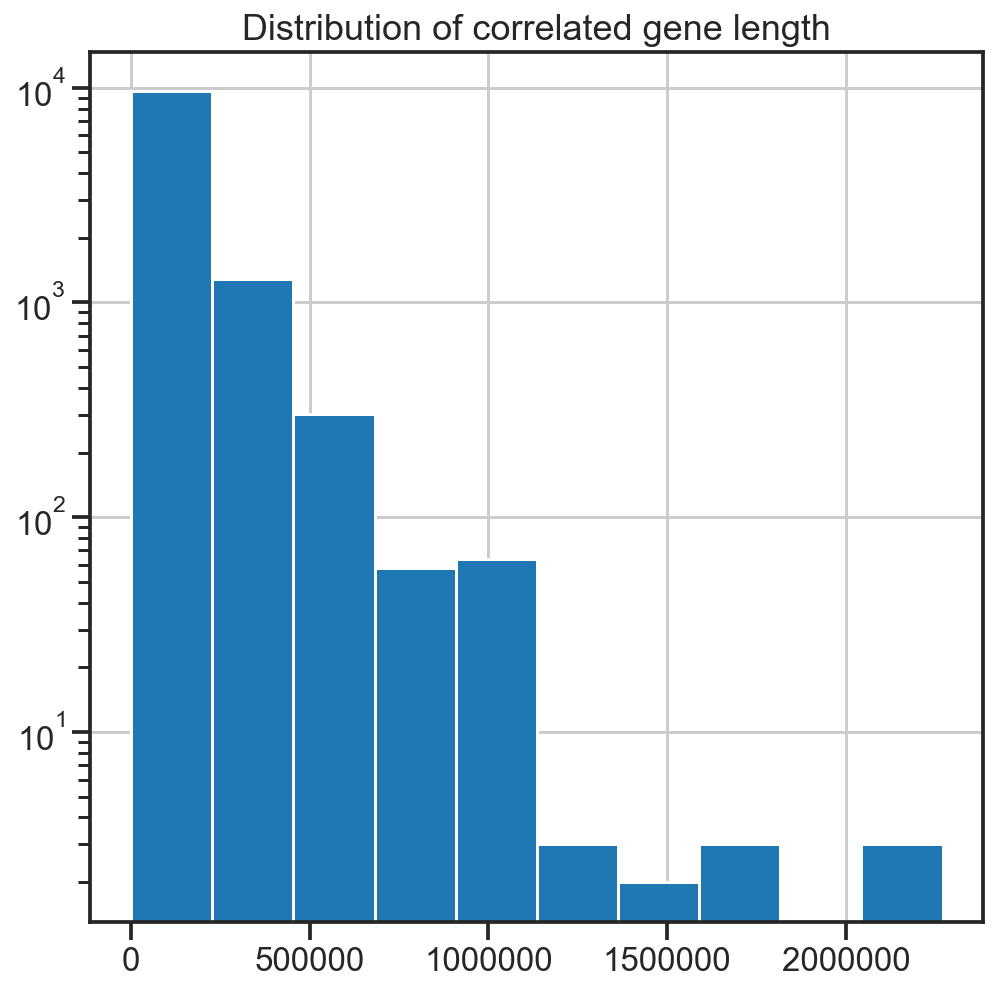

In [199]:

fig, ax = plt.subplots(figsize=(8, 8))
plt.hist(tmp.length)
plt.yscale('log')
plt.title("Distribution of correlated gene length")

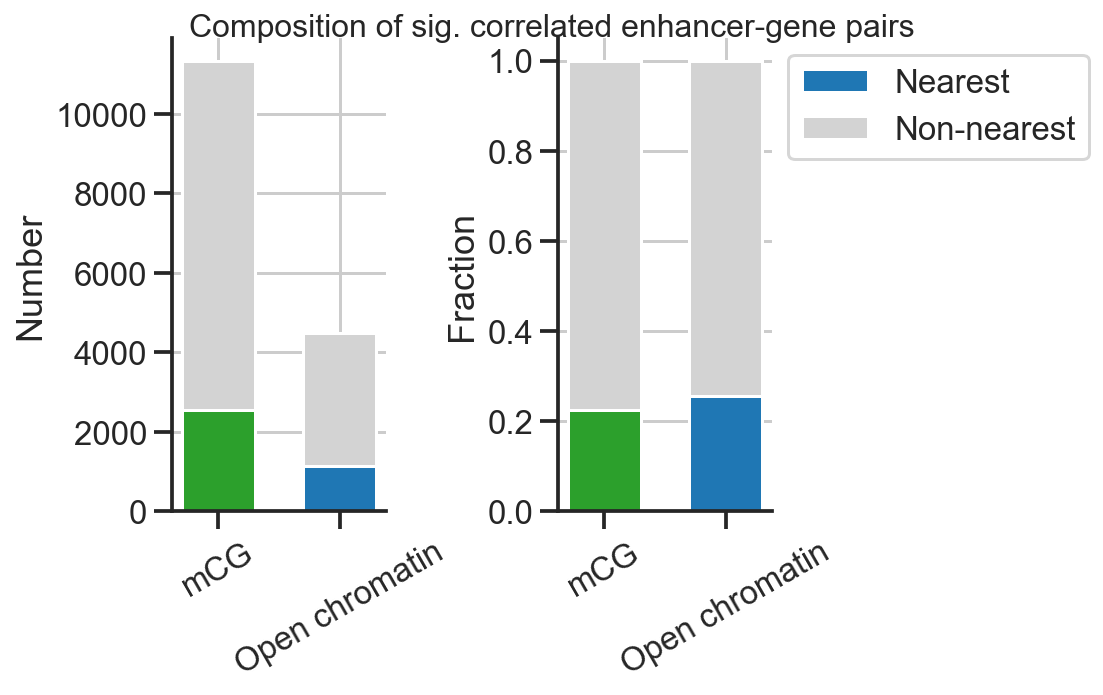

In [200]:
# numbers 
track1 = [0, 
          len(top_sig[top_sig['gene']==top_sig['nearest_gene']]), 
          len(top_sig[top_sig['gene']!=top_sig['nearest_gene']]),
         ]
track1_colors = [mod_palette['mc'], 'lightgray']
# track1_colors = ['black', 'lightgray']
track1_labels = ['Nearest', 'Non-nearest']

track2 = [0, 
          len(top_sig2[top_sig2['gene']==top_sig2['nearest_gene']]), 
          len(top_sig2[top_sig2['gene']!=top_sig2['nearest_gene']]),
         ]
# track2_colors = ['black', 'lightgray']
track2_colors = [mod_palette['atac'], 'lightgray']
track2_labels = ['Nearest', 'Non-nearest']

fig, axs = plt.subplots(1, 2, figsize=(4*2,5))
ax = axs[0]
for i in range(len(track1)-1):
    color = track1_colors[i]
    ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
for i in range(len(track2)-1):
    color = track2_colors[i]
    ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    
ax.set_xticks([0, 1])
ax.set_xticklabels(['mCG', 'Open chromatin'], rotation=30)
ax.set_ylabel('Number')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

    
# plot 2 fraction 
track1 = np.array(track1)
track1 = track1/track1.sum()

track2 = np.array(track2)
track2 = track2/track2.sum()


ax = axs[1]
for i in range(len(track1)-1):
    color = track1_colors[i]
    ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
for i in range(len(track2)-1):
    color = track2_colors[i]
    ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    
ax.set_xticks([0, 1])
ax.set_xticklabels(['mCG', 'Open chromatin'], rotation=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction')
snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))

fig.suptitle('Composition of sig. correlated enhancer-gene pairs', fontsize=16)
output_name = 'frac_nngenes' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
fig.tight_layout()

In [201]:
top_sig.head()

gene     ens  in_gene       val      val2  \
0  ENSMUSG00000049556  221845     True -0.963891  0.656855   
1  ENSMUSG00000049556  221868     True -0.962140  0.710909   
2  ENSMUSG00000022332   83016     True -0.952730  0.168837   
3  ENSMUSG00000049556  221849     True -0.951198  0.431666   
4  ENSMUSG00000022332   83063     True -0.948134  0.636503   

   val_clustershuffled  val2_clustershuffled    dist       pvalues  fdr<100kb  \
0            -0.085458              0.323121  172329  0.000000e+00    0.00000   
1            -0.183280              0.130321  115681  0.000000e+00    0.00000   
2             0.135792             -0.122661  104705  0.000000e+00    0.00000   
3            -0.066637              0.010614  169279  0.000000e+00    0.00000   
4             0.077580              0.111719  159432  5.843406e-08    0.00455   

   ...  gene_name   index    chr     start       end  clsts  length  chrom  \
0  ...     Lingo1  221845   chr9  56623683  56624596    NaN     913      9   
1  ...     Lingo1  221868   chr9  56680091  56681484    NaN    1393      9   
2  ...    Khdrbs3   83016  chr15  69032853  69033398    NaN     545     15   
3  ...     Lingo1  221849   chr9  56626636  56627742    NaN    1106      9   
4  ...    Khdrbs3   83063  chr15  69087116  69088589    NaN    1473     15   

     center        nearest_gene  
0  56624139  ENSMUSG00000049556  
1  56680787  ENSMUSG00000049556  
2  69033125                      
3  56627189  ENSMUSG00000049556  
4  69087852                      

[5 rows x 28 columns]

In [202]:
top_sig['pair'] = top_sig['gene'] + top_sig['ens'].astype(str)
top_sig2['pair'] = top_sig2['gene'] + top_sig2['ens'].astype(str)

In [203]:
both_sig = top_sig.loc[top_sig['pair'].isin(top_sig2['pair'].values)]

In [204]:
both_sig.shape

(1521, 29)

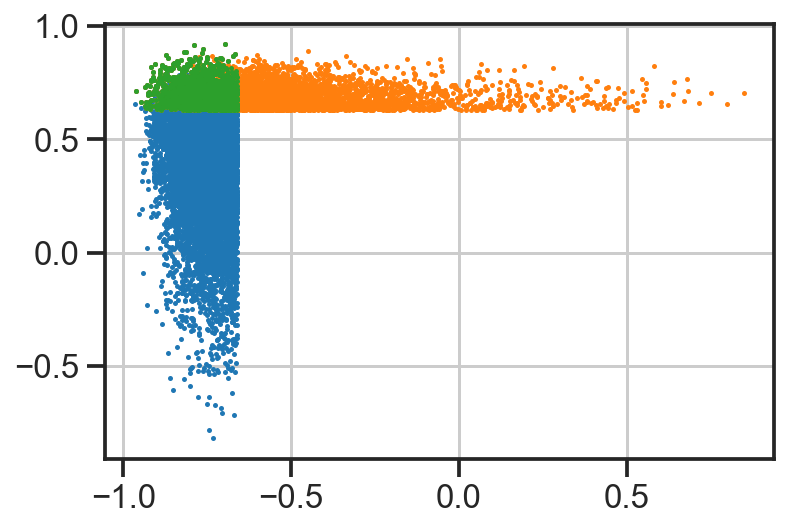

In [205]:
plt.scatter(top_sig['val'], top_sig['val2'], s=1)
plt.scatter(top_sig2['val'], top_sig2['val2'], s=1)
plt.scatter(both_sig['val'], both_sig['val2'], s=1)


In [206]:
to_evals.head()

gene     ens  in_gene       val      val2  \
0  ENSMUSG00000000001  147520    False -0.416129  0.207791   
1  ENSMUSG00000000001  147522    False -0.048692 -0.142357   
2  ENSMUSG00000000001  147523    False -0.109531  0.267535   
3  ENSMUSG00000000001  147527    False -0.134916  0.096838   
4  ENSMUSG00000000001  147528    False -0.355291  0.098807   

   val_clustershuffled  val2_clustershuffled    dist   pvalues  fdr<100kb  \
0             0.071233             -0.002079  995118  0.090151   0.428458   
1             0.120473             -0.145858  985740  0.414462   0.719874   
2             0.027902             -0.259875  983725  0.346690   0.676042   
3             0.201007             -0.100120  970444  0.319497   0.657509   
4             0.248714             -0.124412  969372  0.127221   0.482321   

   fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  \
0   0.520486   0.669566                           32.735334  0.230154   
1   0.777051   0.859596                            1.183878  0.716560   
2   0.740894   0.834201                            1.570314  0.166588   
3   0.725010   0.823293                            1.817085  0.375447   
4   0.570199   0.709733                           14.019220  0.372630   

   fdr2<100kb  fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  \
0    0.605463    0.678469    0.795896                             2.014674   
1    0.871078    0.898293    0.937717                             0.868963   
2    0.549899    0.630306    0.760320                             2.956335   
3    0.704613    0.763367    0.854526                             1.237911   
4    0.702923    0.761896    0.853526                             1.245585   

   val_both  
0 -0.623919  
1  0.093665  
2 -0.377065  
3 -0.231754  
4 -0.454098

In [207]:
def scatter_density(x, y, p=1):
    """
    """
    from scipy.stats import gaussian_kde
    
    n = len(x)
    assert n == len(y)
    if p < 1:
        selected = np.random.rand(n) < p
        _x = x[selected]
        _y = y[selected]
    else:
        _x = x
        _y = y
        
    _xy = np.vstack([_x, _y])
    xy = np.vstack([x, y])
    z = gaussian_kde(_xy)(xy)
    return z 

In [208]:
z = scatter_density(to_evals['val'].values, to_evals['val2'].values, p=.001)

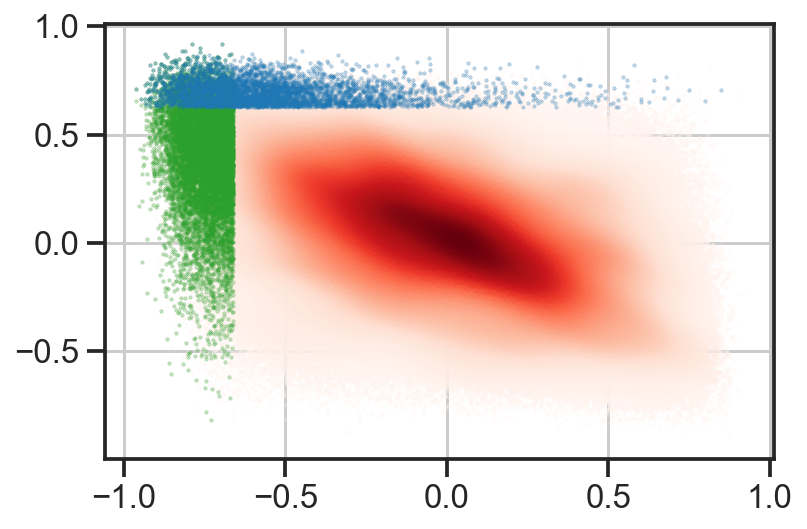

In [209]:
plt.scatter(to_evals['val'], to_evals['val2'], s=.3, 
            alpha=.4, c=z+.3,  cmap='Reds')
plt.scatter(top_sig['val'], top_sig['val2'], alpha=.4,
            s=.3, label='Significant mCG', c=mod_palette['mc'])
plt.scatter(top_sig2['val'], top_sig2['val2'], alpha=.4,
            s=.3, label = 'Significant ATAC', c=mod_palette['atac'])



Text(0, 0.5, 'corr ATAC')

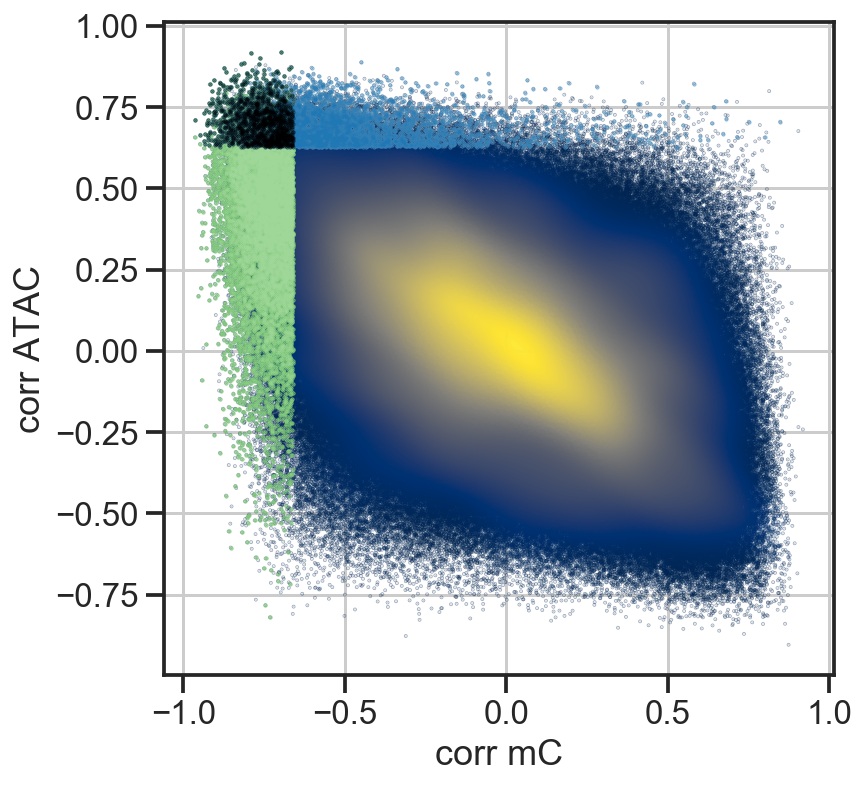

In [211]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(to_evals['val'], to_evals['val2'], s=.15, 
            alpha=.4, c=z,  cmap='cividis', rasterized=True)
ax.scatter(top_sig['val'], top_sig['val2'], alpha=.4,
            s=.3, label='corr mCG', c=colors[5], rasterized=True)
ax.scatter(top_sig2['val'], top_sig2['val2'], alpha=.4,
            s=.3, label = 'corr ATAC', c=colors2[5], rasterized=True)
ax.scatter(top_sig['val'], top_sig['val2'], alpha=.4,
            s=.3, label='linked mCG', c=mod_palette['mc'], rasterized=True)
ax.scatter(top_sig['val'], top_sig['val2'], alpha=.4,
            s=.3, label='linked mCG', c=colors[5], rasterized=True)
ax.scatter(top_sig2['val'], top_sig2['val2'], alpha=.4,
            s=.3, label = 'Significant ATAC', c=mod_palette['atac'], rasterized=True)
ax.scatter(both_sig['val'], both_sig['val2'], alpha=.4, s=.31, c='black', rasterized=True)
ax.set_xlabel('corr mC')
ax.set_ylabel('corr ATAC')



Text(0, 0.5, 'corr ATAC')

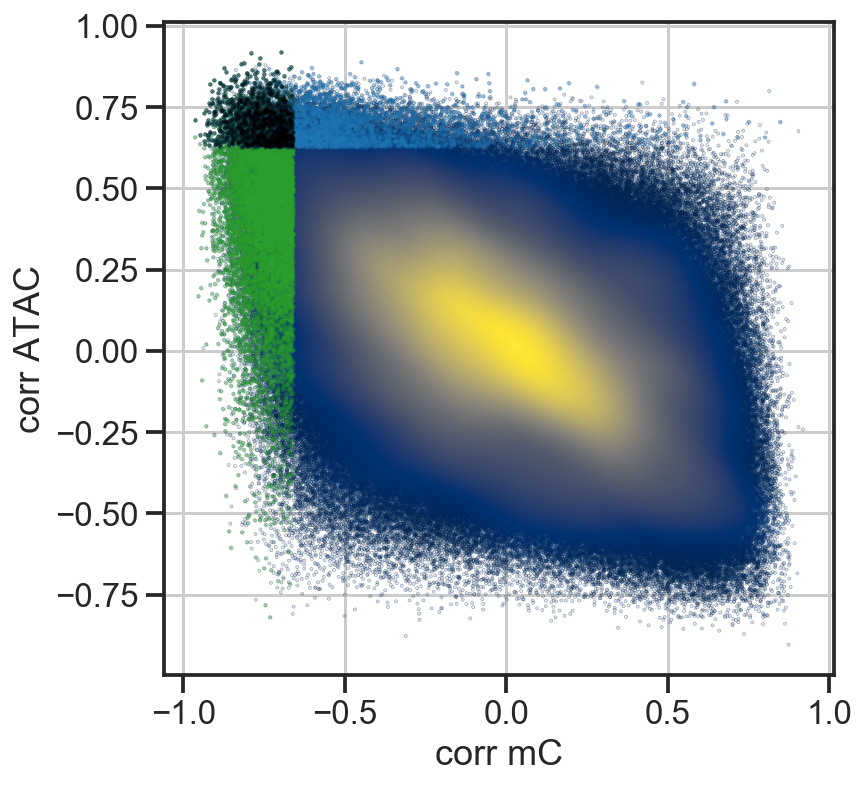

In [212]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(to_evals['val'], to_evals['val2'], s=.15, 
            alpha=.4, c=z,  cmap='cividis')
ax.scatter(top_sig['val'], top_sig['val2'], alpha=.4,
            s=.3, label='Significant mCG', c=mod_palette['mc'])
ax.scatter(top_sig2['val'], top_sig2['val2'], alpha=.4,
            s=.3, label = 'Significant ATAC', c=mod_palette['atac'])
ax.scatter(both_sig['val'], both_sig['val2'], alpha=.4, s=.31, c='black', rasterized=True)
ax.set_xlabel('corr mC')
ax.set_ylabel('corr ATAC')



In [213]:
fig.savefig(output_figures.format('corr_vals_scatter', 'pdf'), bbox_inches='tight', dpi=300)

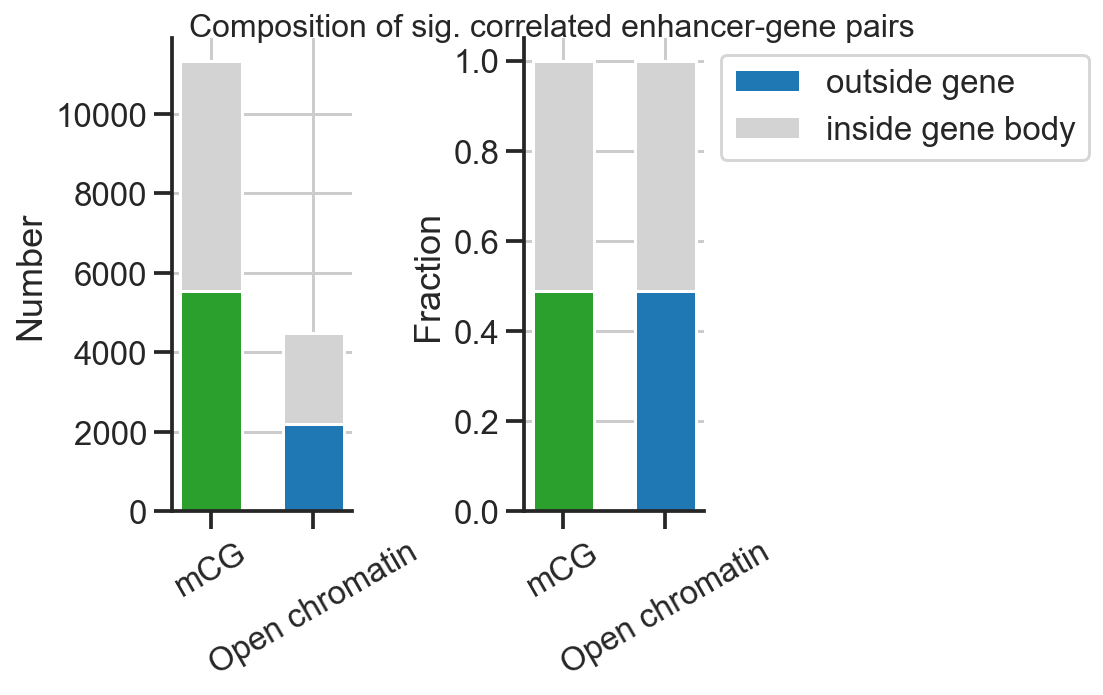

In [214]:
# numbers 
track1 = [0, 
          len(top_sig[~top_sig['in_gene'].values]), 
          len(top_sig[top_sig['in_gene'].values]),
         ]
track1_colors = [mod_palette['mc'], 'lightgray']
# track1_colors = ['black', 'lightgray']
track1_labels = ['outside gene', 'inside gene body']

track2 = [0, 
          len(top_sig2[~top_sig2['in_gene'].values]), 
          len(top_sig2[top_sig2['in_gene'].values]),
         ]
# track2_colors = ['black', 'lightgray']
track2_colors = [mod_palette['atac'], 'lightgray']
track2_labels = ['outside gene', 'inside gene body']

fig, axs = plt.subplots(1, 2, figsize=(4*2,5))
ax = axs[0]
for i in range(len(track1)-1):
    color = track1_colors[i]
    ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
for i in range(len(track2)-1):
    color = track2_colors[i]
    ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    
ax.set_xticks([0, 1])
ax.set_xticklabels(['mCG', 'Open chromatin'], rotation=30)
ax.set_ylabel('Number')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

    
# plot 2 fraction 
track1 = np.array(track1)
track1 = track1/track1.sum()

track2 = np.array(track2)
track2 = track2/track2.sum()


ax = axs[1]
for i in range(len(track1)-1):
    color = track1_colors[i]
    ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
for i in range(len(track2)-1):
    color = track2_colors[i]
    ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    
ax.set_xticks([0, 1])
ax.set_xticklabels(['mCG', 'Open chromatin'], rotation=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction')
snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))

fig.suptitle('Composition of sig. correlated enhancer-gene pairs', fontsize=16)
output_name = 'frac_nngenes' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
fig.tight_layout()

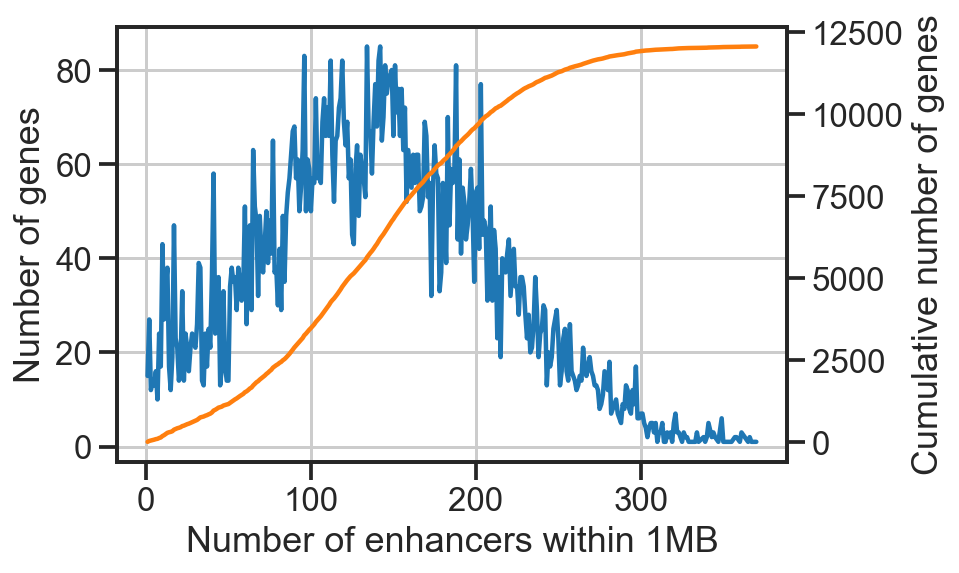

In [215]:
a = to_evals.groupby('gene').size().sort_values() #.values
a = a.value_counts().sort_index() #.values

with sns.plotting_context('talk'):
    fig, ax = plt.subplots()
    ax.plot(a.index.values, a.values)
    ax.set_xlabel('Number of enhancers within 1MB')
    ax.set_ylabel('Number of genes')
    ax2 = ax.twinx()
    ax2.plot(a.index.values, np.cumsum(a.values), color='C1', label='Cumulative')
    ax2.grid(False)
    ax2.set_ylabel('Cumulative number of genes')
    
    output_name = 'distribution-num-enhancers-per-gene' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')


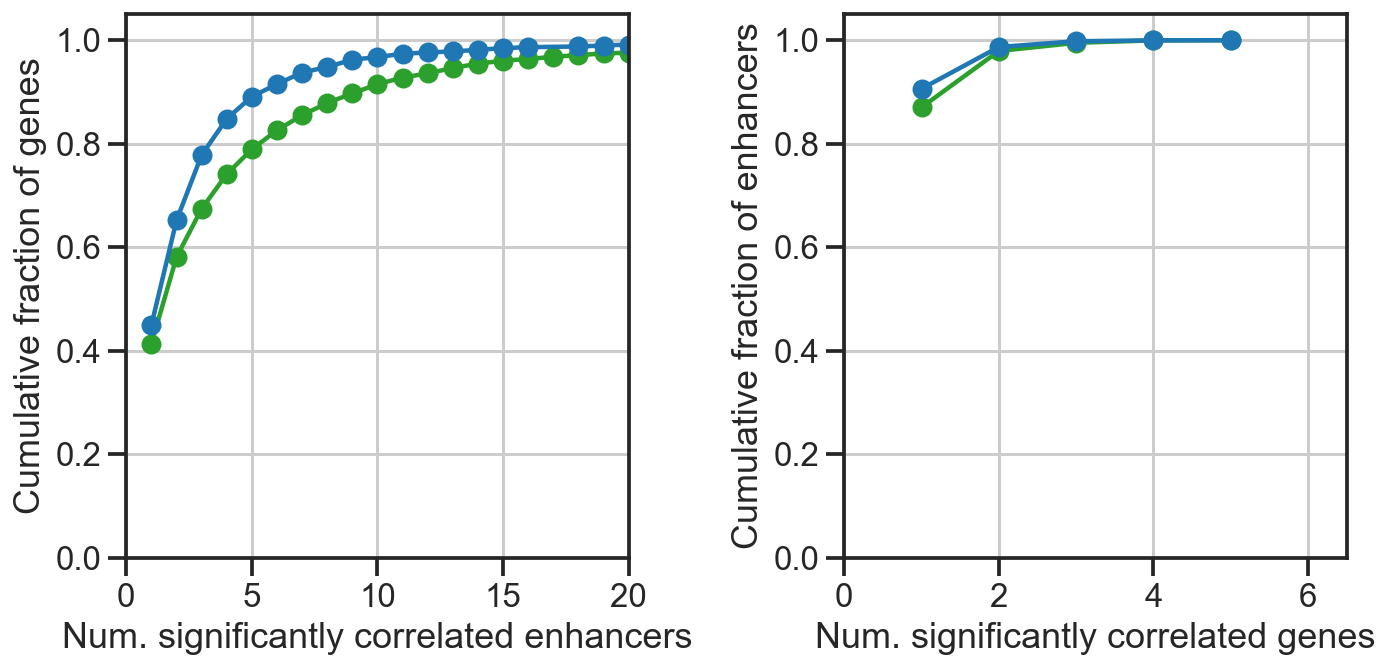

In [216]:

fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1))
ax = axs[0]
for mod, _df in zip(['mc', 'atac'], 
                    [top_sig, top_sig2], 
                    ):
    a = _df.groupby('gene').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated enhancers')
ax.set_ylabel('Cumulative fraction of genes')
ax.set_xlim([0, 20])
ax.set_ylim([0, 1.05])

ax = axs[1]
for mod, _df in zip(['mc', 'atac'], 
                    [top_sig, top_sig2], 
                    ):
    a = _df.groupby('ens').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated genes')
ax.set_ylabel('Cumulative fraction of enhancers')
ax.set_xlim([0, 6.5])
ax.set_ylim([0, 1.05])



fig.tight_layout()
output_name = 'cdf_enh_per_gene' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')

## Number of enhancers and number of genes 

In [217]:
print(len(to_evals['gene'].unique()))
print(len(to_evals['ens'].unique()))
print(enh_mcg_clsts.shape)

12070
150747
(152104, 38)


## Unorganized 

### super enhancers 
start from ```to_evals```
- statistics on gene - cumulative effect of enhancers

In [218]:
th = -0.3
_tmp = to_evals.groupby('gene')
gene_score = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score = gene_score.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score.sort_values('val_score').head()

val_score  val_num
gene                                  
ENSMUSG00000002107 -81.104246      229
ENSMUSG00000032503 -76.288938      202
ENSMUSG00000022332 -74.830452      195
ENSMUSG00000061751 -68.869887      223
ENSMUSG00000053477 -66.883521      205

In [219]:
_tmp = to_evals_shuffled.groupby('gene')
gene_score_shuffled = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score_shuffled = gene_score_shuffled.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score_shuffled.sort_values('val_score').head()

val_score  val_num
gene                                  
ENSMUSG00000053641 -45.985392      165
ENSMUSG00000038807 -43.780884      155
ENSMUSG00000039375 -41.951964      150
ENSMUSG00000026782 -41.924664      135
ENSMUSG00000019467 -41.806248      161

In [220]:
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1)[:30])
# sns.distplot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1))
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score_shuffled.sort_values('val').index.values)].sum(axis=1)[:100])

In [221]:
corr_tracks = np.array([
    gene_score_shuffled['val_score'].values,
    gene_score['val_score'].values,
])

labels = np.array([
    'Gene score shuffled',
    'Gene score',
])

colors = np.array([
    'C0',
    'C1',
])

subsample_rates = np.array([
    1,
    1,
])

In [222]:
# FDR
bins_eval = np.linspace(-30, 0, 1000)

# background
x_bck = np.sort(corr_tracks[0])
y_bck = np.arange(len(x_bck))/len(x_bck)

# fore-ground - 1
x_fr = np.sort(corr_tracks[1])
y_fr = np.arange(len(x_fr))/len(x_fr)

# ratio 0
fdr_multi = fdr(bins_eval, x_bck, y_bck, x_fr, y_fr)

# plt.plot(bins_eval, fdr_multi)

    

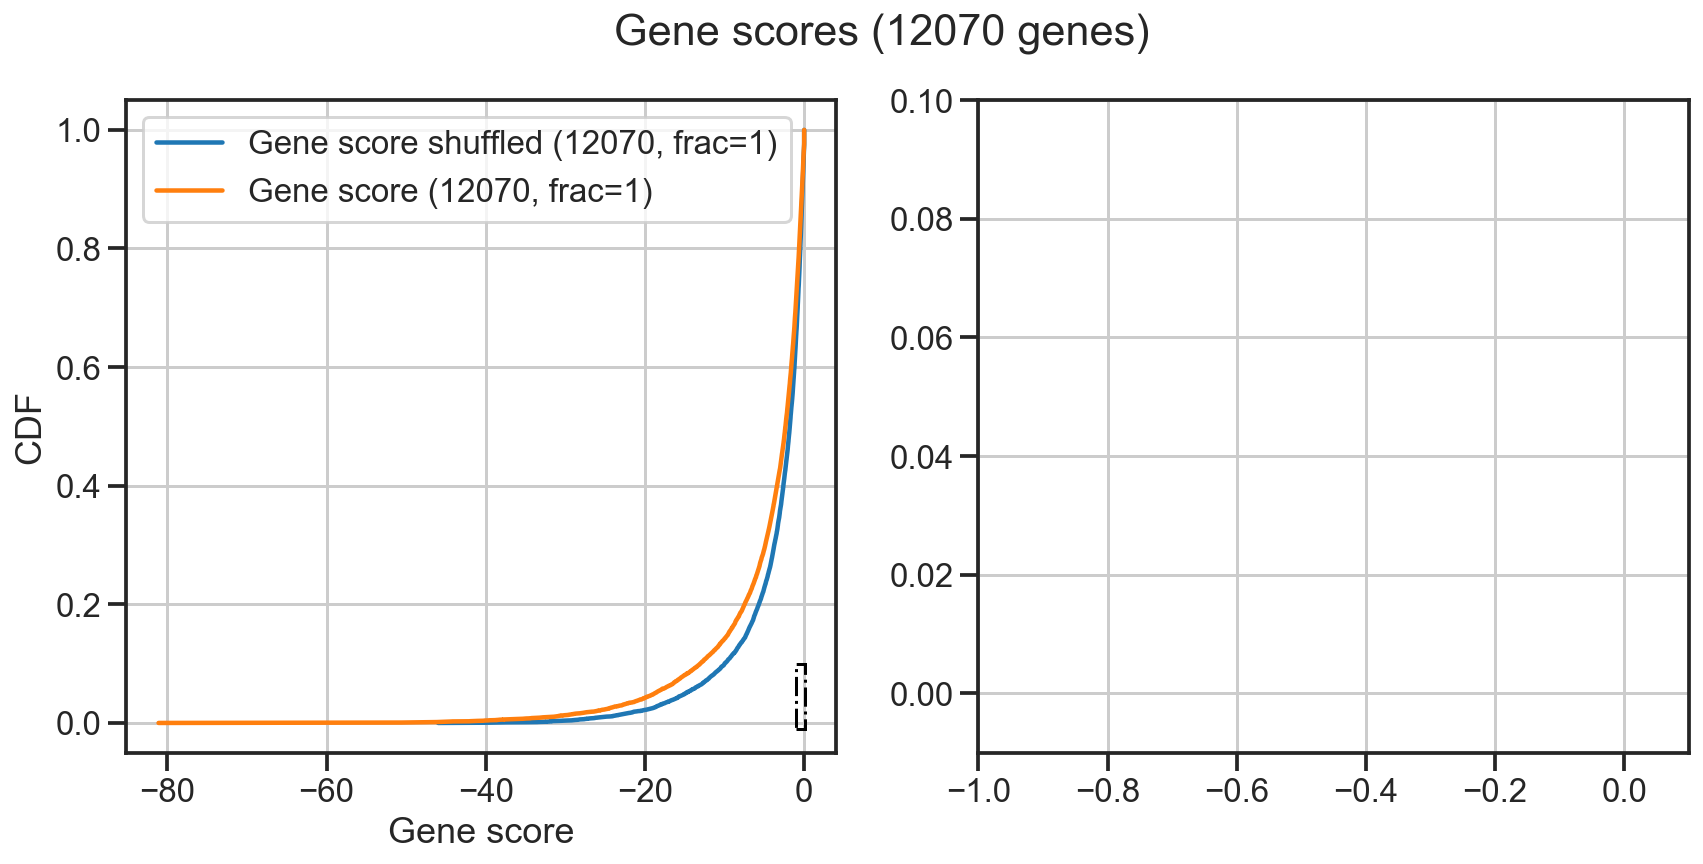

In [223]:
# plot
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('CDF')
    
    xmin, xmax, ymin, ymax = -1, 0.1, -0.01, 0.1
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    
    fig.suptitle('Gene scores ({} genes)'.format(len(gene_score)), 
                )
    
#     fig.tight_layout()
    output_name = '30-super-enhancers-score' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

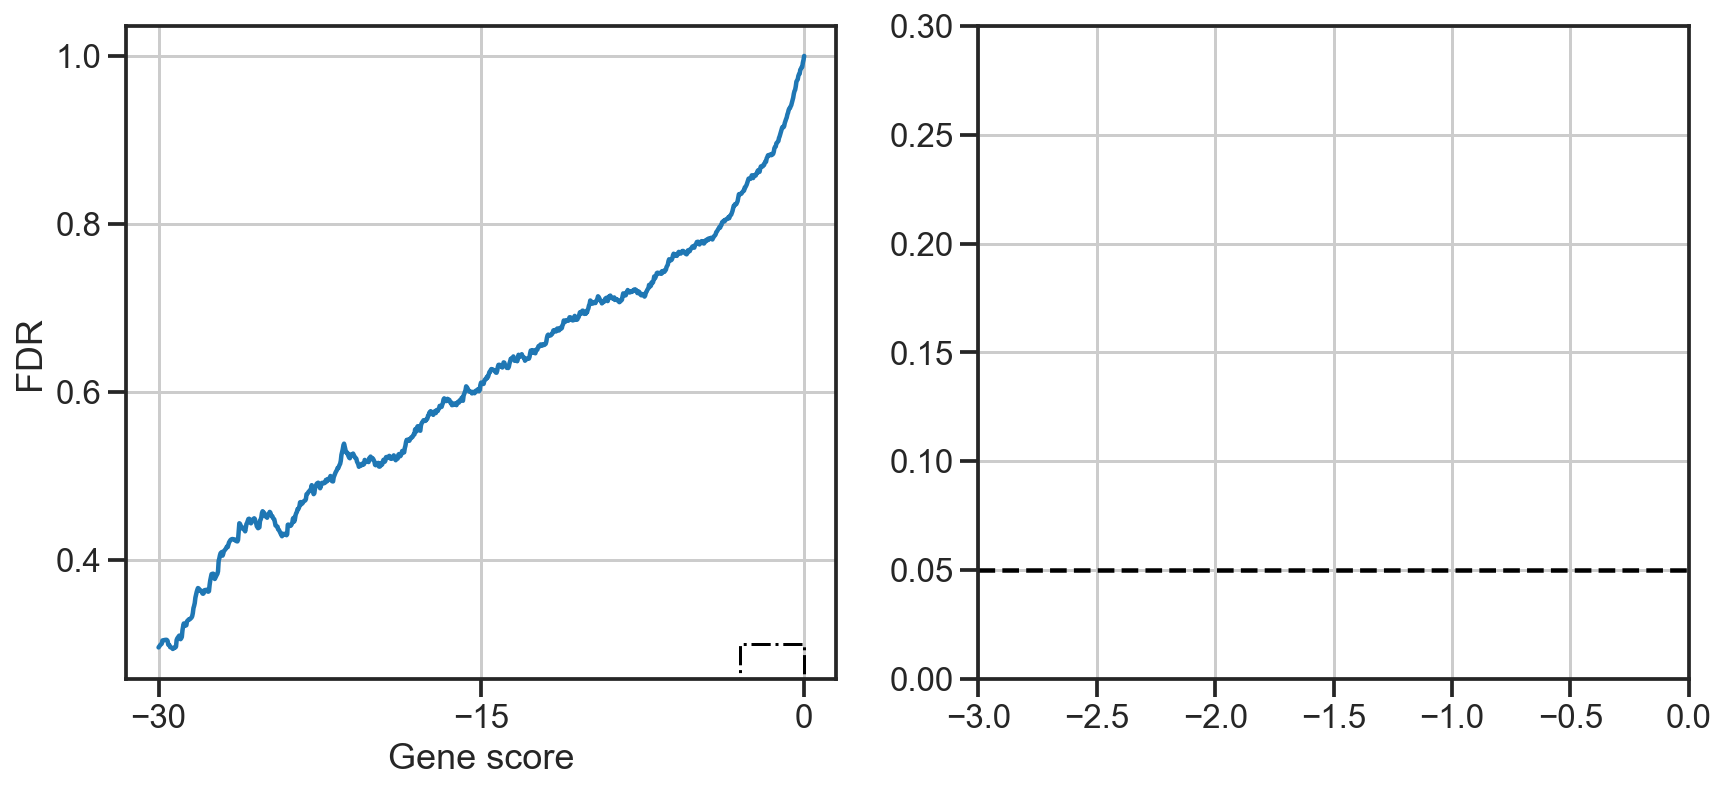

In [224]:
from matplotlib.patches import Rectangle
with sns.plotting_context('talk'):
    # inner box
#     xmin_1, xmax_1, ymin_1, ymax_1 = -0.8, 0.8, 0, 1 
    xmin, xmax, ymin, ymax = -3, 0, 0, 0.3 
    
    fig, axs = plt.subplots(1, 2, figsize=(7*2, 6*1))
    ax = axs[0]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
#     ax.set_xlim([xmin_1, xmax_1])
#     ax.set_ylim([ymin_1, ymax_1])
#     ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('FDR')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))

    ax = axs[1]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    ax.axhline(0.05, color='black', linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    output_name = '31-super-enhancers-fdrs' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [225]:
th = 0.3
gene_score['fdr'] = gene_score['val_score'].apply(lambda x: fdr(x, x_bck, y_bck, x_fr, y_fr))
res_multi = gene_score[gene_score['fdr']<th].sort_values('val_score')
print(res_multi.shape)
res_multi.head()

(161, 3)


val_score  val_num  fdr
gene                                       
ENSMUSG00000002107 -81.104246      229  0.0
ENSMUSG00000032503 -76.288938      202  0.0
ENSMUSG00000022332 -74.830452      195  0.0
ENSMUSG00000061751 -68.869887      223  0.0
ENSMUSG00000053477 -66.883521      205  0.0

### Lots of heatmaps 

In [226]:
th2 = -0.3
to_plot = to_evals[to_evals['val']<th2] 

to_plot.shape
to_plot.head()

gene     ens  in_gene       val      val2  \
0    ENSMUSG00000000001  147520    False -0.416129  0.207791   
4    ENSMUSG00000000001  147528    False -0.355291  0.098807   
68   ENSMUSG00000000001  147628    False -0.346318  0.317212   
85   ENSMUSG00000000001  147652    False -0.379363  0.089178   
136  ENSMUSG00000000001  147720    False -0.378488  0.040158   

     val_clustershuffled  val2_clustershuffled    dist   pvalues  fdr<100kb  \
0               0.071233             -0.002079  995118  0.090151   0.428458   
4               0.248714             -0.124412  969372  0.127221   0.482321   
68              0.301674             -0.287449  388279  0.133319   0.489592   
85             -0.088741             -0.249590  295181  0.111681   0.461809   
136             0.290951             -0.033592  287529  0.112227   0.462609   

     fdr<200kb  fdr<500kb  fdr<100kb shuffled (cluster label)  pvalues2  \
0     0.520486   0.669566                           32.735334  0.230154   
4     0.570199   0.709733                           14.019220  0.372630   
68    0.577189   0.715577                           12.470872  0.122494   
85    0.551781   0.694447                           19.504568  0.386419   
136   0.552499   0.695043                           19.281220  0.457934   

     fdr2<100kb  fdr2<200kb  fdr2<500kb  fdr2<100kb shuffled (cluster label)  \
0      0.605463    0.678469    0.795896                             2.014674   
4      0.702923    0.761896    0.853526                             1.245585   
68     0.500842    0.586425    0.727048                             4.453074   
85     0.711126    0.768926    0.858277                             1.208174   
136    0.750248    0.801522    0.879491                             1.059357   

     val_both  
0   -0.623919  
4   -0.454098  
68  -0.663530  
85  -0.468541  
136 -0.418645

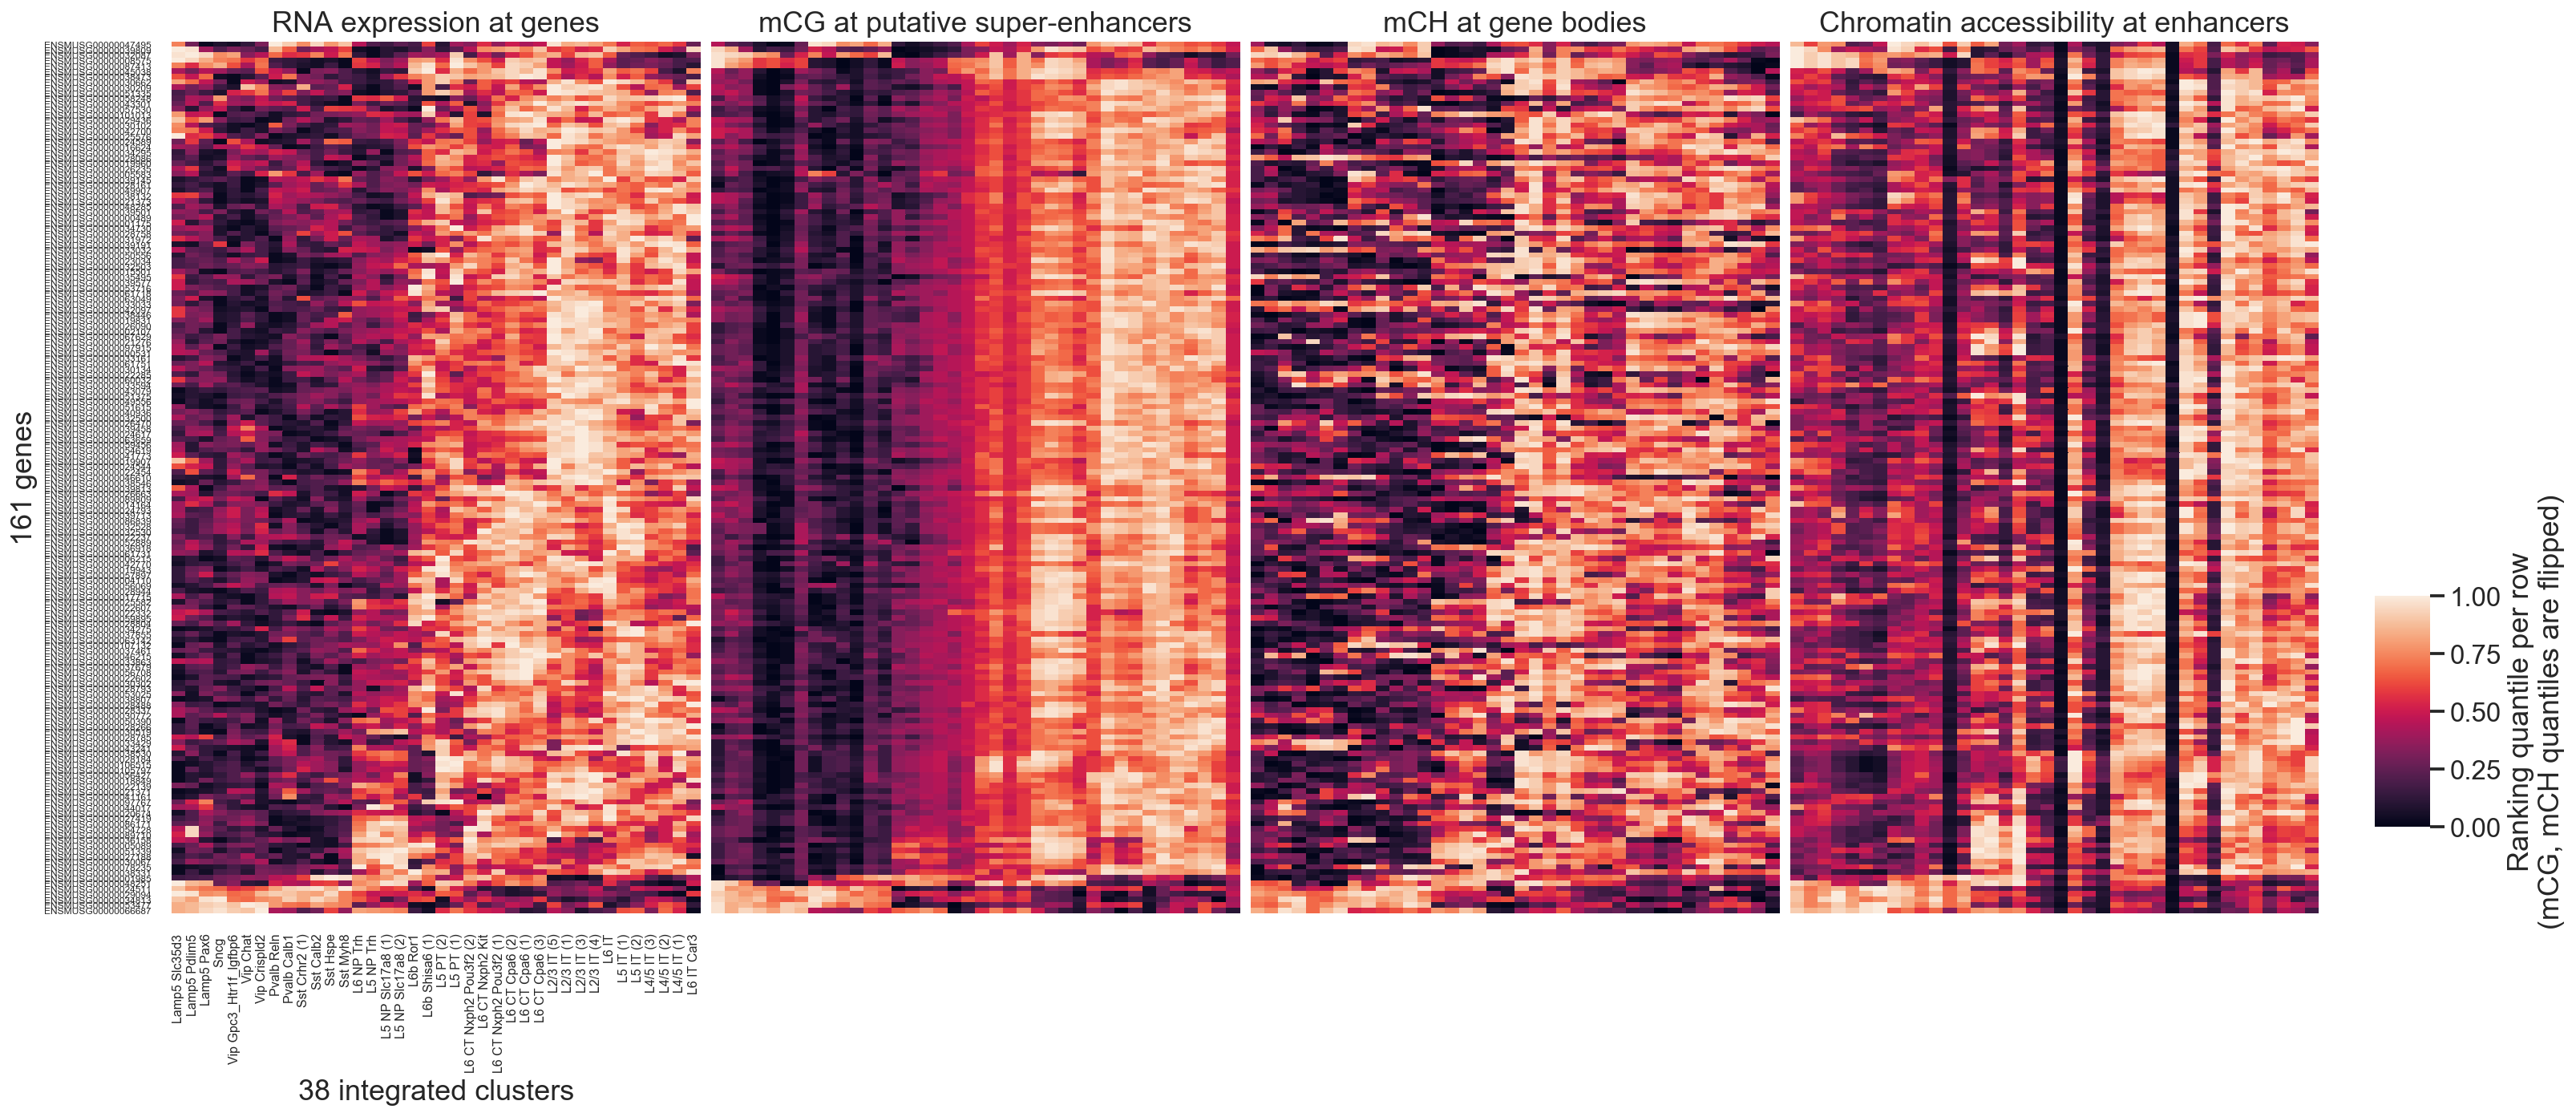

In [227]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[res_multi.index.values, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = to_plot.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(1, 4, figsize=(6*4,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    ax = axs[0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
#                     xticklabels=False,
                    yticklabels=True,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                   )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))

    ax = axs[1]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at putative super-enhancers')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[2]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']],
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[3]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
    output_name = '32-heatmap-examples-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [228]:
gene = 'Kcnc1'
gid = df_genes.groupby('gene_name').first().loc[gene, 'gid']
gid

'ENSMUSG00000058975'